### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [1]:
#import sklearn
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [2]:
#import os
#os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [3]:
# Restart the Kernel. 

#import IPython

#IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

In [4]:
#!python -m pip install --upgrade scikit-learn
#import sklearn
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [5]:
# Now you can import and use OneHotEncoder
#from sklearn.preprocessing import OneHotEncoder
# your code goes here

In [6]:
# Similarly, should you need any other package, they can install it as:
#!python -m pip install 'tensorflow-tensorboard<0.2.0,>=0.1.0'

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [7]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Additional Libraries:

# Path
from pathlib import Path


# magic word for producing visualizations in notebook
%matplotlib inline


# Additional Magic Words:
# magic word for reloading modules before executing code
%load_ext autoreload
%autoreload 2


'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [8]:
from WGU_D499_P2_DCook.dataset import load_csv_with_parameters

# Load in the general demographics data.
azdias_general_demographics_original_df = load_csv_with_parameters("Udacity_AZDIAS_Subset.csv", sep=";", na_values=np.nan)

# Load in the feature summary file.
features_summary_original_df = load_csv_with_parameters("AZDIAS_Feature_Summary.csv", sep=";")


2025-06-17 19:15:13.163 | INFO     | WGU_D499_P2_DCook.config:<module>:11 - PROJ_ROOT path is: D:\WGU\D499\WGU_D499_P2_DCook


2025-06-17 19:15:17.696 | INFO     | WGU_D499_P2_DCook.dataset:load_csv_with_parameters:68 - Loaded dataset from D:\WGU\D499\WGU_D499_P2_DCook\data\raw\Udacity_AZDIAS_Subset.csv with 891221 rows and 85 columns.
2025-06-17 19:15:17.702 | INFO     | WGU_D499_P2_DCook.dataset:load_csv_with_parameters:68 - Loaded dataset from D:\WGU\D499\WGU_D499_P2_DCook\data\raw\AZDIAS_Feature_Summary.csv with 85 rows and 4 columns.


In [9]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Priting the shape of the general demographics dataframe
print(f"AZDIAS General Demographics shape: {azdias_general_demographics_original_df.shape}")

# Printing the shape of the features summary dataframe
print(f"AZDIAS Feature Summary shape: {features_summary_original_df.shape}")


AZDIAS General Demographics shape: (891221, 85)
AZDIAS Feature Summary shape: (85, 4)


AZDIAS General Demographics Details:

In [10]:
azdias_general_demographics_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [11]:
azdias_general_demographics_original_df.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [12]:
azdias_general_demographics_original_df.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,2,1943,1.0,0,3,8.0,2.0,1.0,1.0,4.0,2.0,1,3,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0,0.0,0.0,2,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,4,0,12.0,0,2,2.0,1.0,1.0,1.0,2.0,1.0,1,10,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1,0.0,0.0,1,4,0.0,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,5,1964,9.0,0,1,5.0,2.0,1.0,1.0,1.0,1.0,1,8,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0,0.0,0.0,1,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,6,1974,3.0,1,3,10.0,3.0,1.0,1.0,10.0,5.0,1,11,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3,0.0,0.0,2,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,1,1975,12.0,1,2,4.0,1.0,1.0,1.0,3.0,2.0,1,15,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3,0.0,0.0,2,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


AZDIAS Feature Summary Details:

In [13]:
features_summary_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


In [14]:
features_summary_original_df.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,AGER_TYP,person,ordinal,[-1]
freq,1,43,49,26


In [15]:
features_summary_original_df.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [16]:
# Identify missing or unknown data values and convert them to NaNs.

# Total Number of existing Missing/Null Values in the dataset or Natural Nulls
azdias_general_demographics_original_df.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [17]:
# Initializing a dictionary variable to hold the count of natural nulls for each column
nat_null_count = {}

# For Loop to iterate through each column in the azdias_general_demographics_original_df
# and calculate the total number of natural nulls (NaN values) in each column.
# Storing the results in the nat_null_count dictionary.
for column in azdias_general_demographics_original_df.columns:
    
    column_total_nat_nulls = azdias_general_demographics_original_df[column].isna().sum()
    nat_null_count[column] = column_total_nat_nulls

In [18]:
# For Loop to iterate through the nat_null_count dictionary
# and print the column name along with the total number of natural nulls in descending order.

for column_name, nat_null_count in sorted(nat_null_count.items(), key=lambda item: item[1], reverse=True):
    #print(column_name, null_count)
    if nat_null_count > 0:
        print(f" Column Name: '{column_name}' has a total of '{nat_null_count:,}' natural null/missing values.")

print(f"\nAll other columns have '0' natural null/missing values")

 Column Name: 'KK_KUNDENTYP' has a total of '584,612' natural null/missing values.
 Column Name: 'KBA05_ANTG1' has a total of '133,324' natural null/missing values.
 Column Name: 'KBA05_ANTG2' has a total of '133,324' natural null/missing values.
 Column Name: 'KBA05_ANTG3' has a total of '133,324' natural null/missing values.
 Column Name: 'KBA05_ANTG4' has a total of '133,324' natural null/missing values.
 Column Name: 'KBA05_BAUMAX' has a total of '133,324' natural null/missing values.
 Column Name: 'KBA05_GBZ' has a total of '133,324' natural null/missing values.
 Column Name: 'MOBI_REGIO' has a total of '133,324' natural null/missing values.
 Column Name: 'KKK' has a total of '121,196' natural null/missing values.
 Column Name: 'REGIOTYP' has a total of '121,196' natural null/missing values.
 Column Name: 'PLZ8_ANTG1' has a total of '116,515' natural null/missing values.
 Column Name: 'PLZ8_ANTG2' has a total of '116,515' natural null/missing values.
 Column Name: 'PLZ8_ANTG3' has

In [19]:
# Create a new copy of the features summary dataframe to work with.
features_summary_cleaned_df = features_summary_original_df.copy()

In [20]:
# Generated a list of unique values in the 'missing_or_unknown' column.
features_summary_cleaned_df['missing_or_unknown'].unique()


array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [21]:
# Capture the data type of the 'missing_or_unknown' column
features_summary_cleaned_df['missing_or_unknown'].dtype


dtype('O')

In [22]:
# Capture the data type of the 'missing_or_unknown' column's first value
type(features_summary_cleaned_df['missing_or_unknown'][0])


str

In [23]:

# What this tells us is that allthough the values in the 'missing_or_unknown' column are stored as if they were lists 
# They are actually stored as a string data type. This means that if we were to attempt to iterate over the values in 
# each row of the 'missing_or_unknown' column, we would be iterating over each character in the string, rather than
# the individual values in the list. To fix this, we need to convert the string representation of the list into an actual  .

In [24]:
from WGU_D499_P2_DCook.utils import convert_string_to_list, get_fs_string_conversions_failed

# Convert the 'missing_or_unknown' column from string representation of lists to actual lists.
features_summary_cleaned_df['missing_or_unknown'] = features_summary_cleaned_df.apply(convert_string_to_list, axis=1)

In [25]:

# Get the list of features that failed the string conversion
fs_string_conversion_failed = get_fs_string_conversions_failed()

fs_string_conversion_failed   

[('CAMEO_DEUG_2015', '[-1,X]'),
 ('CAMEO_DEU_2015', '[XX]'),
 ('CAMEO_INTL_2015', '[-1,XX]')]

In [26]:
# Manually correcting these list items

features_summary_cleaned_df.at[57, 'missing_or_unknown'] = ['-1' , 'X']
features_summary_cleaned_df.at[58, 'missing_or_unknown'] = ['XX']
features_summary_cleaned_df.at[59, 'missing_or_unknown'] = ['-1' , 'XX']

In [27]:
# This features dataframe will be used during the manual transformation and cleaning phase of this project
features_summary_manual_df = features_summary_cleaned_df.copy()

In [28]:
# This features dataframe will be used during the automatic transformation and cleaning phase of this project
features_summary_auto_df = features_summary_cleaned_df.copy()

In [29]:
# Beginning NAN Conversion

missing_unknown_identifier_df = features_summary_cleaned_df[['attribute', 'missing_or_unknown']].copy()

missing_unknown_identifier_df.reset_index(drop=True)

,attribute,missing_or_unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0, 9]"
2,ANREDE_KZ,"[-1, 0]"
3,CJT_GESAMTTYP,[0]
4,FINANZ_MINIMALIST,[-1]
5,FINANZ_SPARER,[-1]
6,FINANZ_VORSORGER,[-1]
7,FINANZ_ANLEGER,[-1]
8,FINANZ_UNAUFFAELLIGER,[-1]
9,FINANZ_HAUSBAUER,[-1]


In [30]:
from WGU_D499_P2_DCook.utils import convert_unknown_missing_to_nan


azdias_general_demographics_original_df, null_changes_dict = convert_unknown_missing_to_nan(azdias_general_demographics_original_df, missing_unknown_identifier_df, verbose=True)

D:\WGU\D499\WGU_D499_P2_DCook\WGU_D499_P2_DCook\utils.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main_df[column_name].replace(to_replace=item, value=replace_with, inplace=True)


AGER_TYP: 0 --> 685843 nulls after converting 685843 values
ALTERSKATEGORIE_GROB: 0 --> 2881 nulls after converting 2881 values
ANREDE_KZ: 0 --> 0 nulls after converting 0 values
CJT_GESAMTTYP: 4854 --> 4854 nulls after converting 0 values
FINANZ_MINIMALIST: 0 --> 0 nulls after converting 0 values
FINANZ_SPARER: 0 --> 0 nulls after converting 0 values
FINANZ_VORSORGER: 0 --> 0 nulls after converting 0 values
FINANZ_ANLEGER: 0 --> 0 nulls after converting 0 values
FINANZ_UNAUFFAELLIGER: 0 --> 0 nulls after converting 0 values
FINANZ_HAUSBAUER: 0 --> 0 nulls after converting 0 values
FINANZTYP: 0 --> 0 nulls after converting 0 values
GEBURTSJAHR: 0 --> 392318 nulls after converting 392318 values
GFK_URLAUBERTYP: 4854 --> 4854 nulls after converting 0 values
GREEN_AVANTGARDE: 0 --> 0 nulls after converting 0 values
HEALTH_TYP: 0 --> 111196 nulls after converting 111196 values
LP_LEBENSPHASE_FEIN: 4854 --> 97632 nulls after converting 92778 values
LP_LEBENSPHASE_GROB: 4854 --> 94572 nulls 

D:\WGU\D499\WGU_D499_P2_DCook\WGU_D499_P2_DCook\utils.py:143: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  match_count = main_df[column_name].value_counts().get(item, 0)
D:\WGU\D499\WGU_D499_P2_DCook\WGU_D499_P2_DCook\utils.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main_df[column_name].replace(to_replace=item, value=replace_with,

OST_WEST_KZ: 93148 --> 93148 nulls after converting 168545 values
WOHNLAGE: 93148 --> 93148 nulls after converting 0 values


D:\WGU\D499\WGU_D499_P2_DCook\WGU_D499_P2_DCook\utils.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main_df[column_name].replace(to_replace=item, value=replace_with, inplace=True)
D:\WGU\D499\WGU_D499_P2_DCook\WGU_D499_P2_DCook\utils.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

CAMEO_DEUG_2015: 98979 --> 99352 nulls after converting 373 values
CAMEO_DEU_2015: 98979 --> 99352 nulls after converting 373 values


D:\WGU\D499\WGU_D499_P2_DCook\WGU_D499_P2_DCook\utils.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main_df[column_name].replace(to_replace=item, value=replace_with, inplace=True)
D:\WGU\D499\WGU_D499_P2_DCook\WGU_D499_P2_DCook\utils.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

CAMEO_INTL_2015: 98979 --> 99352 nulls after converting 373 values
KBA05_ANTG1: 133324 --> 133324 nulls after converting 0 values
KBA05_ANTG2: 133324 --> 133324 nulls after converting 0 values
KBA05_ANTG3: 133324 --> 133324 nulls after converting 0 values
KBA05_ANTG4: 133324 --> 133324 nulls after converting 0 values
KBA05_BAUMAX: 133324 --> 476524 nulls after converting 343200 values
KBA05_GBZ: 133324 --> 133324 nulls after converting 0 values
BALLRAUM: 93740 --> 93740 nulls after converting 0 values
EWDICHTE: 93740 --> 93740 nulls after converting 0 values
INNENSTADT: 93740 --> 93740 nulls after converting 0 values
GEBAEUDETYP_RASTER: 93155 --> 93155 nulls after converting 0 values
KKK: 121196 --> 158064 nulls after converting 36868 values
MOBI_REGIO: 133324 --> 133324 nulls after converting 0 values
ONLINE_AFFINITAET: 4854 --> 4854 nulls after converting 0 values
REGIOTYP: 121196 --> 158064 nulls after converting 36868 values
KBA13_ANZAHL_PKW: 105800 --> 105800 nulls after convertin

In [31]:
from WGU_D499_P2_DCook.utils import null_dict_to_dataframe

# Although we were able to see the output of the conversion above, it is not very easy to interpret the results.
# Let's convert the null changes dictionary to a DataFrame to make it easier to interpret the conversion results. 
null_conversion_results_dataframe = null_dict_to_dataframe(null_changes_dict)

In [32]:
# display the null conversion results DataFrame
null_conversion_results_dataframe

,column,pre_null_count,post_null_count
0,AGER_TYP,0,685843
1,ALTERSKATEGORIE_GROB,0,2881
2,ANREDE_KZ,0,0
3,CJT_GESAMTTYP,4854,4854
4,FINANZ_MINIMALIST,0,0
5,FINANZ_SPARER,0,0
6,FINANZ_VORSORGER,0,0
7,FINANZ_ANLEGER,0,0
8,FINANZ_UNAUFFAELLIGER,0,0
9,FINANZ_HAUSBAUER,0,0


In [33]:
# We can even be extra careful and do a manual check on the null values in the azdias_general_demographics_original_df
# These values should all line up with what we have above. 

nan_null_check_df = azdias_general_demographics_original_df.copy()

for column in nan_null_check_df.columns:

    print(f"Column Name: {column}")
    print(f"Total Null/NP.Nan Values: {nan_null_check_df[column].isnull().sum()}")
    print()

Column Name: AGER_TYP
Total Null/NP.Nan Values: 685843

Column Name: ALTERSKATEGORIE_GROB
Total Null/NP.Nan Values: 2881

Column Name: ANREDE_KZ
Total Null/NP.Nan Values: 0

Column Name: CJT_GESAMTTYP
Total Null/NP.Nan Values: 4854

Column Name: FINANZ_MINIMALIST
Total Null/NP.Nan Values: 0

Column Name: FINANZ_SPARER
Total Null/NP.Nan Values: 0

Column Name: FINANZ_VORSORGER
Total Null/NP.Nan Values: 0

Column Name: FINANZ_ANLEGER
Total Null/NP.Nan Values: 0

Column Name: FINANZ_UNAUFFAELLIGER
Total Null/NP.Nan Values: 0

Column Name: FINANZ_HAUSBAUER
Total Null/NP.Nan Values: 0

Column Name: FINANZTYP
Total Null/NP.Nan Values: 0

Column Name: GEBURTSJAHR
Total Null/NP.Nan Values: 392318

Column Name: GFK_URLAUBERTYP
Total Null/NP.Nan Values: 4854

Column Name: GREEN_AVANTGARDE
Total Null/NP.Nan Values: 0

Column Name: HEALTH_TYP
Total Null/NP.Nan Values: 111196

Column Name: LP_LEBENSPHASE_FEIN
Total Null/NP.Nan Values: 97632

Column Name: LP_LEBENSPHASE_GROB
Total Null/NP.Nan Values

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [34]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

from WGU_D499_P2_DCook.eda import column_nan_eda_total_and_percentage

# Get the total and percentage of NaN values in each column of the dataset and store them in two separate series.
column_nan_eda_total_series, column_nan_eda_percentage_series = column_nan_eda_total_and_percentage(azdias_general_demographics_original_df)


2025-06-17 19:15:35.970 | INFO     | WGU_D499_P2_DCook.plots:plot_hist_column_nan_percentage:76 - Plot saved to D:\WGU\D499\WGU_D499_P2_DCook\reports\figures\column_nan_eda_percentage_hist_plot.png


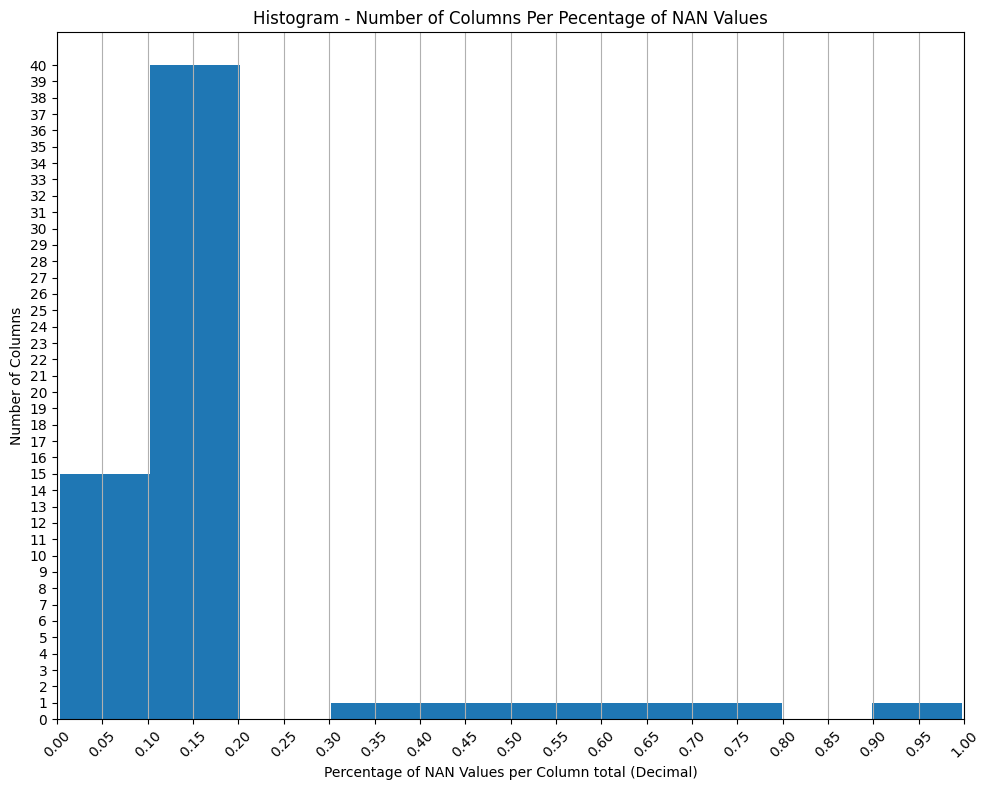

In [35]:
# Investigate patterns in the amount of missing data in each column.

from WGU_D499_P2_DCook.plots import plot_hist_column_nan_percentage, plot_bar_column_nan_percentage

# Plot the histogram of the percentage of NaN values in each column.
plot_hist_column_nan_percentage(column_nan_eda_percentage_series)

2025-06-17 19:15:37.663 | INFO     | WGU_D499_P2_DCook.plots:plot_bar_column_nan_percentage:117 - Plot saved to D:\WGU\D499\WGU_D499_P2_DCook\reports\figures\column_nan_eda_percentage_bar_plot.png


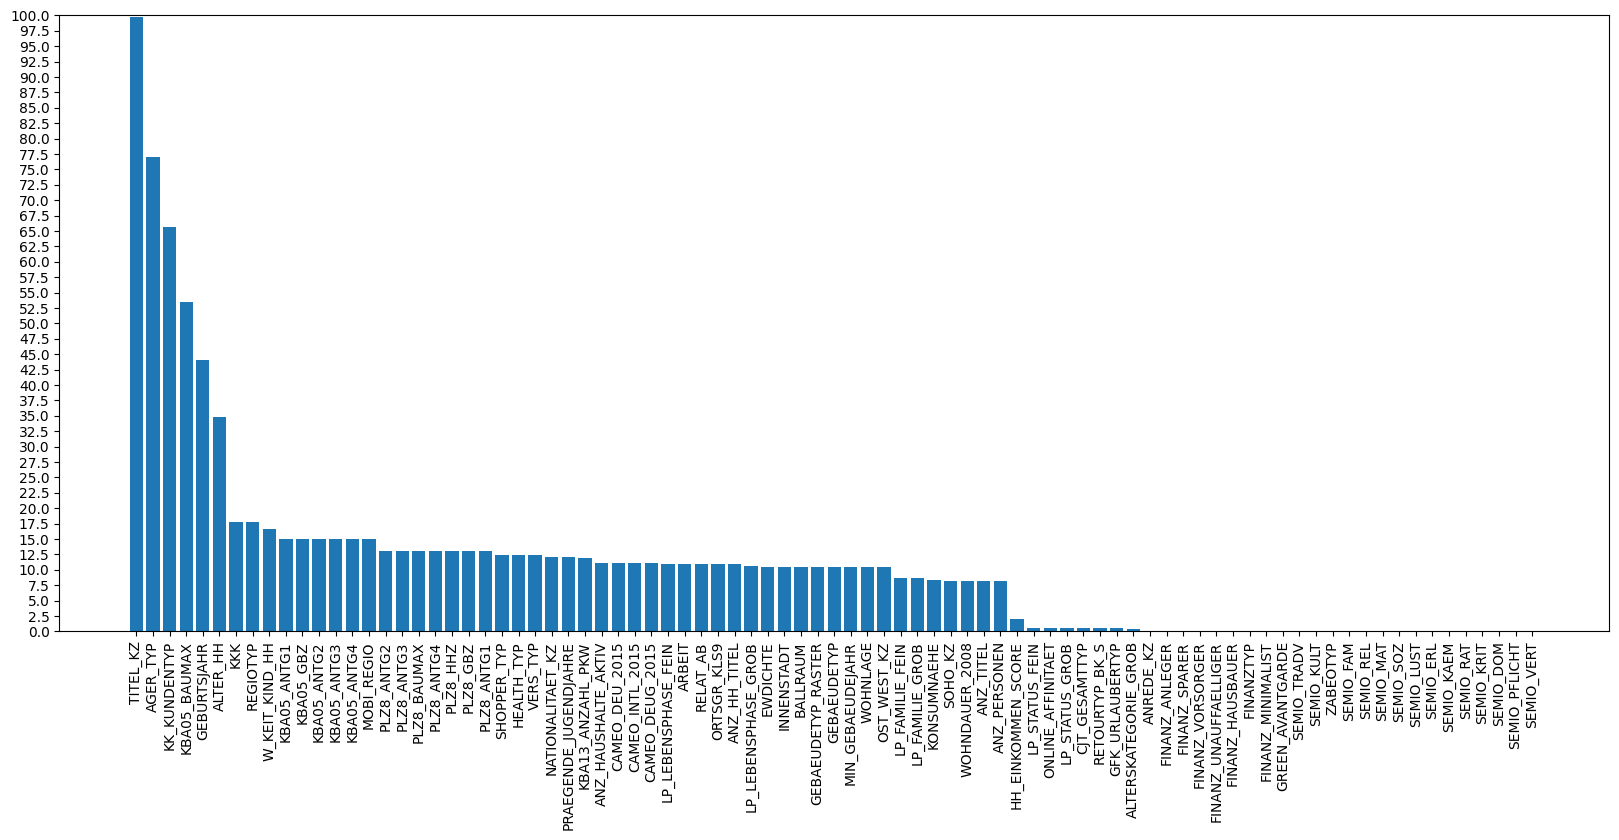

In [36]:
# Plot the percentage of NaN values in each column as a bar chart.
plot_bar_column_nan_percentage(azdias_general_demographics_original_df)

In [37]:
# Investigate patterns in the amount of missing data in each column.

from WGU_D499_P2_DCook.eda import eda_identify_outlier_columns, get_invalid_level_eda_identify_outlier_columns

# Identify columns with outliers based on the features summary and the general demographics data.
column_nan_eda_dataframe, outlier_column_name_list = eda_identify_outlier_columns(azdias_general_demographics_original_df, features_summary_manual_df, False, .2, ['Medium High','High', 'Very High'])


Mean of missing score is 0.15403309009792626


In [38]:
# The "eda_identify_outlier_columns" function above returned a dataframe with the columns that have NaN values and their respective percentage of NaN values.
# This dataframe is used to identify the columns that have a high percentage of NaN values and are considered outliers.

# Priting the top thirty rows from the 'column_nan_eda_dataframe' with the head method. 
column_nan_eda_dataframe.head(30)



,column_name,total_nan,nan_percentage,information_level,missing_score,severity_level
0,TITEL_KZ,889061,99.757636,person,0.997576,Very High
1,AGER_TYP,685843,76.955435,person,0.769554,Very High
2,KK_KUNDENTYP,584612,65.596749,household,0.655967,Very High
3,KBA05_BAUMAX,476524,53.468668,microcell_rr3,0.534687,Very High
4,GEBURTSJAHR,392318,44.020282,person,0.440203,Very High
5,ALTER_HH,310267,34.813699,household,0.348137,Very High
6,KKK,158064,17.735668,region_rr1,0.177357,Medium
7,REGIOTYP,158064,17.735668,region_rr1,0.177357,Medium
8,W_KEIT_KIND_HH,147988,16.605084,household,0.166051,Medium
9,KBA05_ANTG1,133324,14.959701,microcell_rr3,0.149597,Medium Low


2025-06-17 19:15:40.453 | INFO     | WGU_D499_P2_DCook.plots:plot_bar_eda_column_missing_severity:163 - Plot saved to D:\WGU\D499\WGU_D499_P2_DCook\reports\figures\column_nan_eda_severity_bar_plot.png


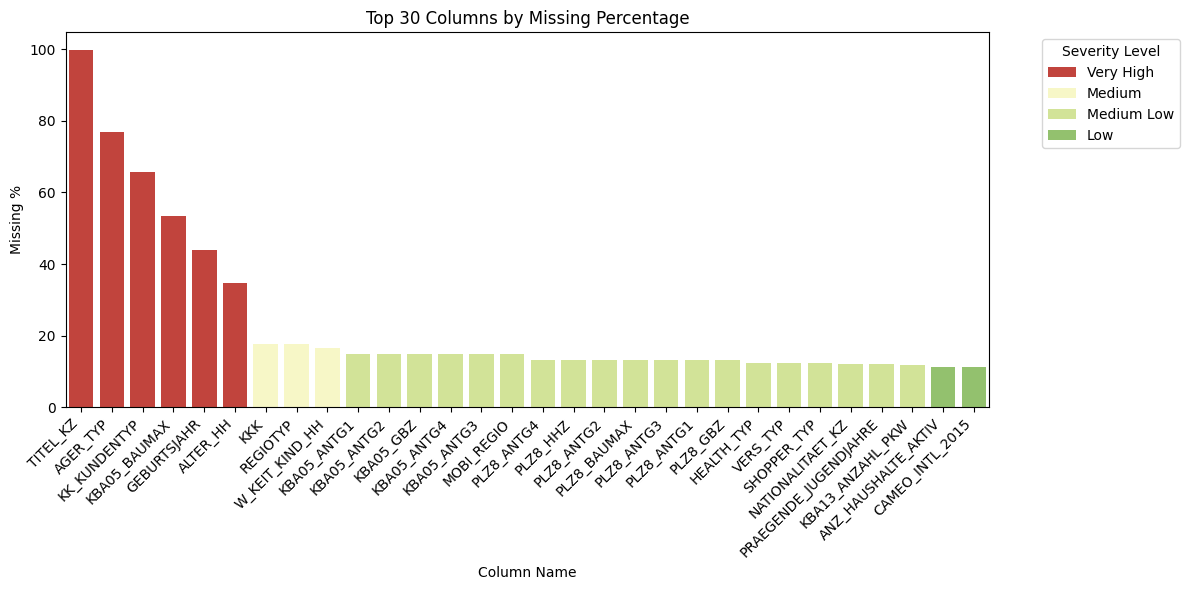

In [39]:
from WGU_D499_P2_DCook.plots import plot_bar_eda_column_missing_severity

# Plot the bar chart of the columns with NaN values and their respective percentage of NaN values.
plot_bar_eda_column_missing_severity(column_nan_eda_dataframe)

In [40]:

# The above "eda_identify_outlier_columns" method returns the outlier columns as well as the column_nan_eda_dataframe.
# While this method used a function to perform an contained/isolated get action to capture the outlier columns similar how getters/setters are used in O.O.P.
# So although we are not using this method to obtain the outlier columns, I wanted to keep the code here for reference.

# outlier_column_name_list = get_invalid_level_eda_identify_outlier_columns()

# Print the full list as a list
# outlier_column_name_list

# Print the list of outlier column names, more readable

for column_name in outlier_column_name_list:
    print(f"Outlier Column Name: {column_name}")



Outlier Column Name: TITEL_KZ
Outlier Column Name: AGER_TYP
Outlier Column Name: KK_KUNDENTYP
Outlier Column Name: KBA05_BAUMAX
Outlier Column Name: GEBURTSJAHR
Outlier Column Name: ALTER_HH


In [41]:
# Remove the outlier columns from the dataset. (You'll perform other data engineering tasks such as re-encoding and imputation later.)

from WGU_D499_P2_DCook.transformations import remove_outlier_columns, update_features_summary_dataframe

# Here we are removing the outlier columns from the original dataframe using my 'remove_outlier_columns' function. 
# This function has seven total parameters, but we are only using the first three parameters here.
    # The first parameter is the original dataframe
    # The second parameter is the list of outlier column names
    # The third parameter is a boolean value to export the outlier columns to a local file.

# The function takes the original dataframe and the list of outlier column names, and removes those listed columns from the dataframe.

# Then the 'remove_outlier_columns' function will return a new dataframe with the outlier columns removed.

azdias_general_demographics_nan_col_df = remove_outlier_columns(azdias_general_demographics_original_df, outlier_column_name_list, True)



Total of 6 were found out of a total of 85 columns
<class 'pathlib._local.WindowsPath'>
Dataset now has 79 total features


In [42]:
from WGU_D499_P2_DCook.dataset import write_checkpoints

# Here I am writing the dataframe to a local file using my 'write_checkpoints' function to store a save state of the dataframe, a checkpoint if you will. 
write_checkpoints("interim_data", "azdias_general_demographics_nan_col_df", azdias_general_demographics_nan_col_df)

<class 'pathlib._local.WindowsPath'>


In [43]:
# Here we updating the 'features_summary_manual_df' dataframe to remove the outlier columns that were removed from the original dataframe.
# My 'remove_outlier_columns' function has the ability to update the features summary dataframe as well, instead of doing this seperate function call. 
# However, I am having some issue with the function not working as expected, so I am doing this in a seperate function call.

features_summary_manual_df = update_features_summary_dataframe(features_summary_manual_df, outlier_column_name_list)

In [44]:
# Visual top-level check that the features summary dataframe has been updated correctly.

features_summary_manual_df.info()

# Six items were removed so there should be now 79 items in the features summary dataframe, which there is.

<class 'pandas.core.frame.DataFrame'>
Index: 79 entries, 1 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           79 non-null     object
 1   information_level   79 non-null     object
 2   type                79 non-null     object
 3   missing_or_unknown  79 non-null     object
dtypes: object(4)
memory usage: 3.1+ KB


In [45]:
from WGU_D499_P2_DCook.dataset import write_checkpoints

# Here I am writing the dataframe to a local file using my 'write_checkpoints' function to store a save state of the dataframe, a checkpoint if you will. 
write_checkpoints("interim_data", "features_summary_manual_df", features_summary_manual_df)

<class 'pathlib._local.WindowsPath'>


#### Discussion 1.1.2: Assess Missing Data in Each Column

It's important that we start by defining what an 'Outlier' is.  In Mathematic and Statistics, an 'Outlier' is defined as a data point that significantly deviates from the other data points in a set. 

In our case, we would define a column as an 'outlier' if said column contains a significantly larger amount of data that is considered missing compared to the rest of the columns in the dataset. 

This is not to say that missing data is not expected or at least not necessarily a sign of a larger problem or bad/invalid data, our dataset is actually a perfect example of this. Earlier, you will recall when we begin by importing our dataset, we designated that any naturally missing values in the data were to be assigned as a Numpy NaN (np.NaN) value. 

From there, we then took it a step further and converted any values that were purposefully used to label data that was considered "missing", "unknown", "unspecified" into the same Numpy NaN value, effectively taking actual present data and turning them into Numpy NaN (missing) data. 

We did this because in our use-case we are attempting to train an Unsupervised Machine Learning model, and we cannot have missing value in our dataset. Furthermore, any area where we can remove obvious signs of irrelevant data, such as data that holds no weight (like an entirely empty column), will make our training faster and result in more performant models. 

With that said, let's dive into how I determined what was an outlier and what columns were identified. 

In my exploratory data analysis, I am being by calculating the sum of total number of missing values per column. Then I took that sum and divided it by the total length of the column to create a percentage of total NaN values per column or the mean of the column's NaN. From here, I converted that number percentage to a score value by dividing it by 100, called the missing score and then created a baseline number by taking the average or mean of the all the missing scores. Using said baseline, I finished by assigning each column with a category that indicated the level of missing values, which I called this category the severity levels ( 'Very Low', 'Low', 'Medium Low', 'Medium', 'Medium High', 'High', 'Very High'). The level was determined by how far above or below the missing score was from the baseline mean that was just created. 

To make the entire process easier, I created a function to perform all the steps above and store them in a dataframe that can be reviewed or referenced if needed, which is shown above. Not only this, but my function also references the features summary and captures some extra details about each column, such as the level of data, and type of data it is, as well performing an export a list of the columns that were labeled as Outliers to a separate file to be used later. 

For this project, I decided that any column that was assigned with a severity level of 'Medium High', 'High', or 'Very High' would be considered Outlier Columns. This resulted in a total of six columns that were labeled as outlier columns, or columns with abnormally high NaN percentages, they were:
1. TITEL_KZ
2. AGER_TYP
3. KK_KUNDENTYP
4. KBA05_BAUMAX
5. GEBURTSJAHR
6. ALTER_HH
 
Our exploratory data analysis shows that the average missing amount of data in each column is roughly 15.40%. These six columns above contain a range between 35% and almost 100% missing data. Three of the columns, TITEL_KZ, AGER_TYP, GEBURTSJAHR, are of the People information level. Two of the columns, ALTER_HH and KK_KUNDENTYP, are from the Household information level. The last column, KBA05_BAUMAX, comes from the RR3 mirco-cell level of information. 

Using the Data Dictionary, we can interpret that there is strong possibly of a correlation or at least link between the AGER_TYP, GEBURTSJAHR, and ALTER_HH features. Each of these features deal with the age of the consumer, AGER_TYPE attempts to define an elderly typology, the GEBURTSJAHR is defining the consumers year of birth, and the ALTER_HH wants to know what date range the head of household's age falls in. 

For the TITEL_KZ and KBA05_BAUMAX columns, I believe their missing values follow a relatively easily prediction pattern, allow me to explain. In the TITEL_KZ column, we are indicating what level of advanced higher education degree the consumer has obtained, a Doctorate, Multiple Doctorates, Professor status, Professor Status with a Doctorate, or something similar. It is far more likely that the average consumer will not have a higher education degree. The KBA05_BAUMAX column wants to know how many and of what type of buildings exist in their Residental Rural 3 (RR3) microcell. If this information was obtained from the consumer directly/semi-indirectly, I would not expect this information to be known. 

Finally for the KK_KUNDENTYP column, this column inquiries from the user what pattern of a consumer have they been over the last 12 months. I could see this information being left out if the question was worded poorly when obtained or even intentionally left blank to prevent any potential consequence for providing feedback, i.e. If the information was gathered from a brand or service the customer likes but happens to use sparsely, they may not want to review the limited use in case that has a detrimental impact on the company-consumer relationship, etc. 

Regardless of the main reason, these columns have to go due to the amount of missing data, and so they were removed from the dataframe and exported to the archive_data directory for potential future research. 

After removing the outlier columns, we have now reduced our dataset from a total of 85 features down to 79 features. If we look back, we can see that in the beginning we had a total of 62 columns that contained missing data, but now with the six columns removed we are down to 56 columns that contain at least one missing item and 23 columns that contain 0. With that said, let's now turn our attention to the remaining columns that contained missing data and see if we can determine if there are any potential patterns. 

At initial glance, we can see a strong, potential pattern or correlation/relationship between at least several groups of features, based on the amount of missing data. 

The first of these groups contains seven features, which are: "PLZ8_ANTG1", "PLZ8_ANTG2", "PLZ8_ANTG3", "PLZ8_ANTG4", "PLZ8_HHZ", "PLZ8_BAUMAX", "PLZ8_GBZ". All seven of these features are from the same information level, macrocell_plz8, and have the exact same amount of missing data, 116,515 items or 13.0736%. 

The second of these groups contains six features, which are: "KBA05_ANTG1", "KBA05_ANTG2", "KBA05_ANTG3", "KBA05_ANTG4", "KBA05_GBZ", and "MOBI_REGIO". All six contain exactly 133,324 missing items or 14.9597% missing data. However, five of these features are from the same information level, microcell_rr3, and "MOBI_REGIO" comes from the region_rr1 information level and is related to movement patterns not building type/count like the others. We can also see that most of these columns share a similar naming scheme as the ones from the first group. 

After this, we are still able to see groupings of data with the exact same number of missing items and from the same information level. I would even consider it appropriate to for some of these features to infer that the data is significantly interconnected in some manner, most likely at the point of capture or its purpose/representation in the dataset. An example of the former would be with the "HEALTH_TYP", "SHOPPER_TYP", and "VERS_TYP" features, each have the same amount missing 111,196 or 12.1366%, each deal with the person level of data, and each asks a question about the user/consumer. For the latter, we have features like "LB_LEBENSPHASE_FEIN" and "LP_LEBENSPHASE_GROB" or "CAMEO_DEUG_2015", "CAMEO_DEU_2015", and "CAMEO_INTL_2015" or "GEBAEUDETYP" and "GEBAEUDETYP_RASTER" and several others. These features have either the same or extremely little variance in the amount missing data and have very obvious connections based their naming and descriptions in the data dictionary, such as one feature represents the rough or high level overview of that feature and its counterpart feature provides fine or very granular level detail. 

These groupings described above make up approximately roughly half of the remaining 56 columns. This initial inspection does not imply that these are an exact one to one value link (meaning the value that is missing in one group is a direct link to the other), this is just a high-level review of missing data and interpretation of the numbers. If necessary, a more in-depth analysis could be conducted into each column and the distribution of the missing values overall between all columns or even correlation studies on the features relationship. However, for now we are going to move forward with data cleanup and model training and circle back around to the process improvement/quality control aspects another time. 


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [46]:
# How much data is missing in each row of the dataset?

# The easiest way to do this would be to jut use the isnull() method with axis set to 1 for rows on the dataframe and then sum the results.

from WGU_D499_P2_DCook.eda import eda_identify_row_nan


eda_nan_row_dataframe, original_dataframe_len_ = eda_identify_row_nan(azdias_general_demographics_nan_col_df)


Proportion of Missing Values per Row:
count    891221.000000
mean          0.071518
std           0.167528
min           0.000000
25%           0.000000
50%           0.000000
75%           0.037975
max           0.620253
Name: row_nan_total_mean, dtype: float64

--------------------------------------------------

Count of Missing Values per Row:
count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
Name: row_nan_total_sum, dtype: float64


✅ Plotting histograms for missing values per row...


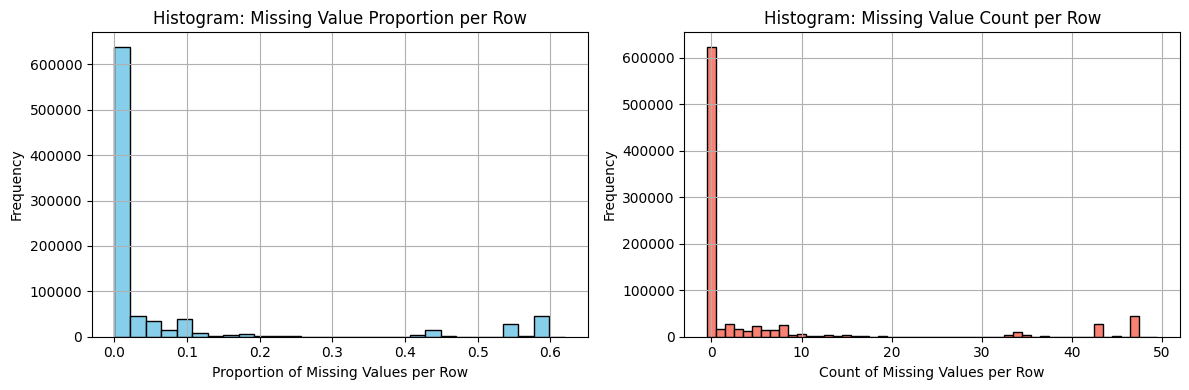

,Proportion of Missing Values,Total Number of Missing Values
count,891221.000000,891221.000000
mean,0.071518,5.649894
std,0.167528,13.234687
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.037975,3.000000
max,0.620253,49.000000


In [47]:
# Graphing the results of the eda_identify_row_nan function
# This function will plot two histograms, one for the average missing value per row as a percentage of the whole column, and the other for the total number of missing values per row as a count.

# Version 1
# from WGU_D499_P2_DCook.plots import plot_hist_row_nan_eda
# plot_hist_row_nan_eda(eda_nan_row_dataframe)

#### #### #### #### #### #### #### #### 

# Version 2
# from WGU_D499_P2_DCook.plots import plot_hist_row_nan_eda_v2
# plot_hist_row_nan_eda_v2(eda_nan_row_dataframe)

#### #### #### #### #### #### #### #### 

# Final Version
from WGU_D499_P2_DCook.plots import plot_hist_row_nan_eda_side_by_side
from WGU_D499_P2_DCook.utils import display_describe_column_comparison_side_by_side

plot_hist_row_nan_eda_side_by_side(eda_nan_row_dataframe)

display_describe_column_comparison_side_by_side(eda_nan_row_dataframe, 'row_nan_total_mean', 'row_nan_total_sum', dc1_name = 'Proportion of Missing Values', dc2_name = 'Total Number of Missing Values')   

In [48]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

from WGU_D499_P2_DCook.eda import eda_row_nan_divide_by_threshold

# The 'eda_row_nan_divide_by_threshold' function will divide the dataframe into two subsets, low row NaN and high row NaN, based on a threshold value.

eda_low_row_nan_df, eda_high_row_nan_df, eda_row_nan_common_columns, eda_threshold_source, eda_threshold = eda_row_nan_divide_by_threshold(azdias_general_demographics_nan_col_df, max_loss_allowed=0.20, max_nan_per_row=0.10, method='kmeans', return_common_columns=True, allow_noise=False, noise_threshold=0.05, plot_graph=False)

Entered Method
Threshold Value: 0.21811074791738036
Actual Loss Value: 0.1074391200386885
If Skipped: threshold is set by previous if check - method vs default - threshold: 0.21811074791738036
Low NaN Dataframe has a shape of: (795469, 81)
High NaN Dataframe has a shape of: (95752, 81)

Threshold final value: 0.21811074791738036

Percentage to be removed is: 0.1074391200386885
Return Common Columns - Enabled
Generating with zero allowed noise


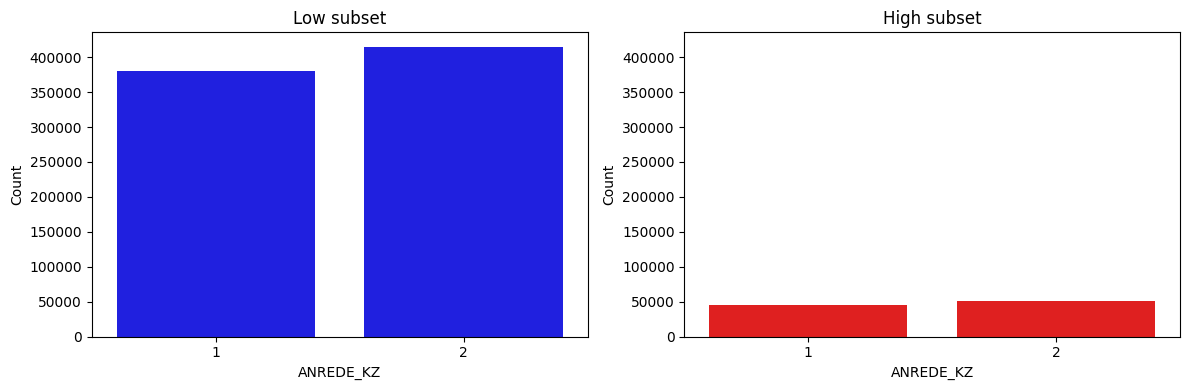

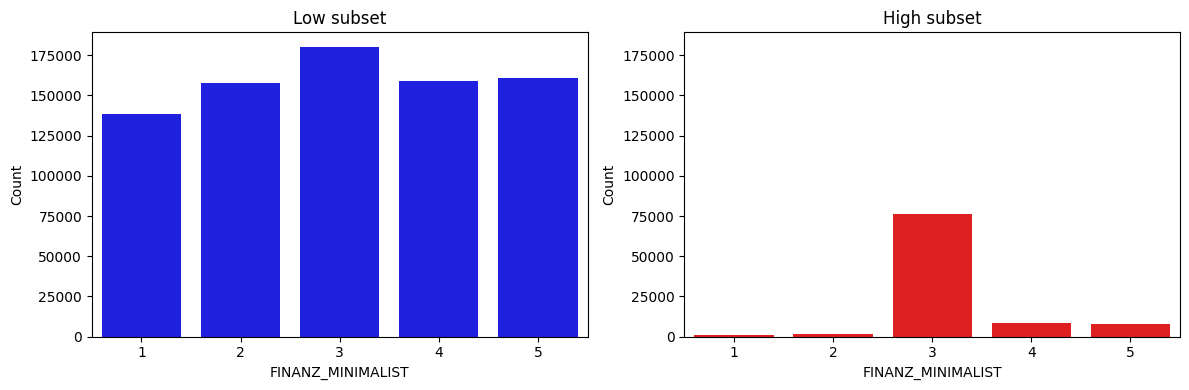

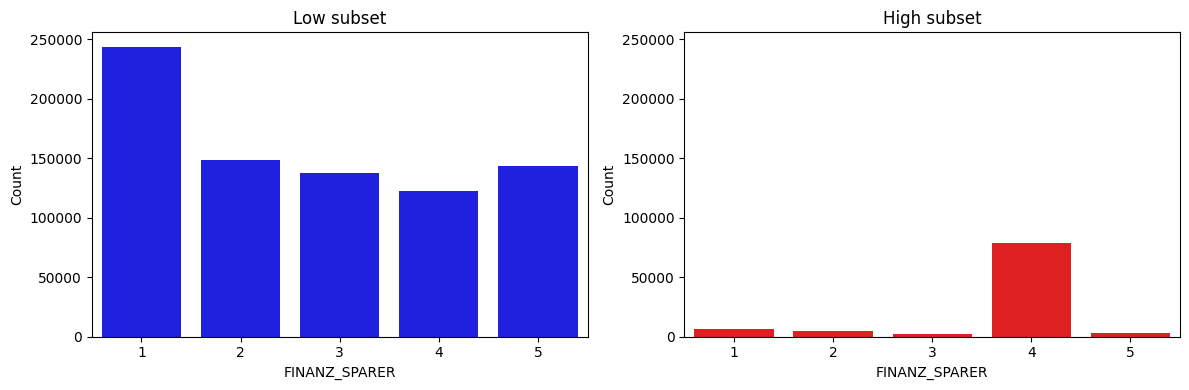

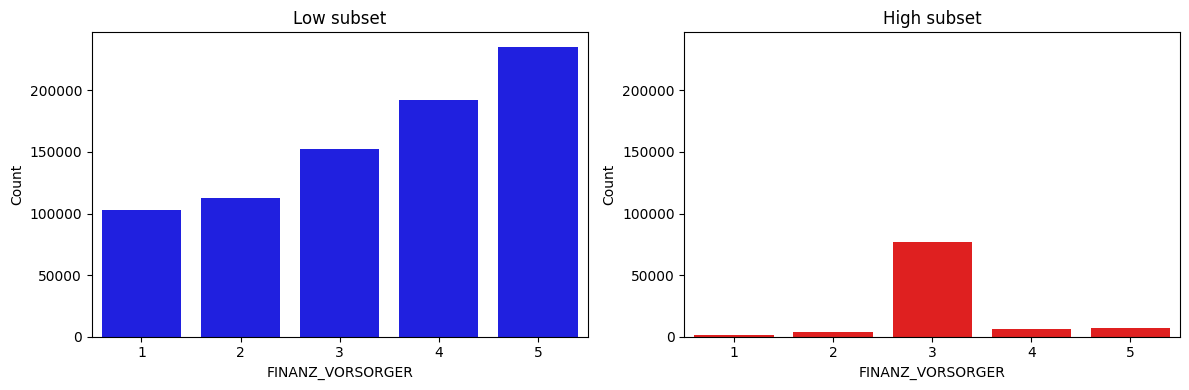

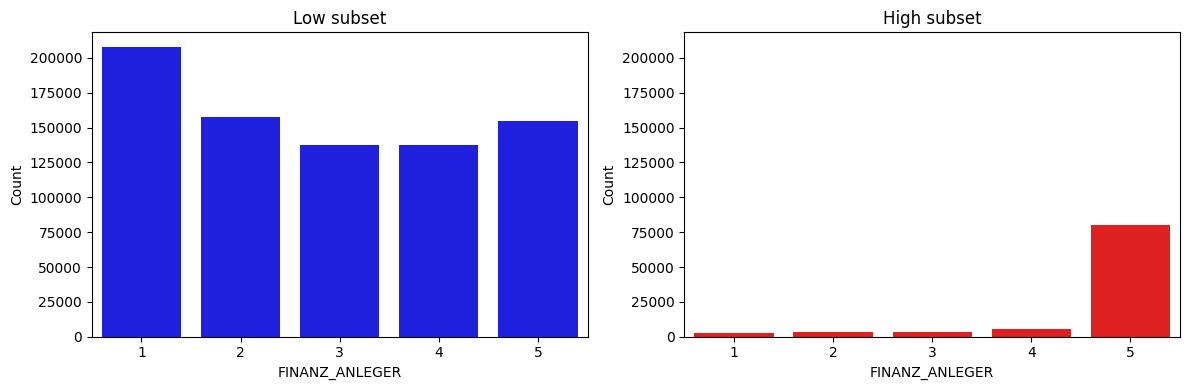

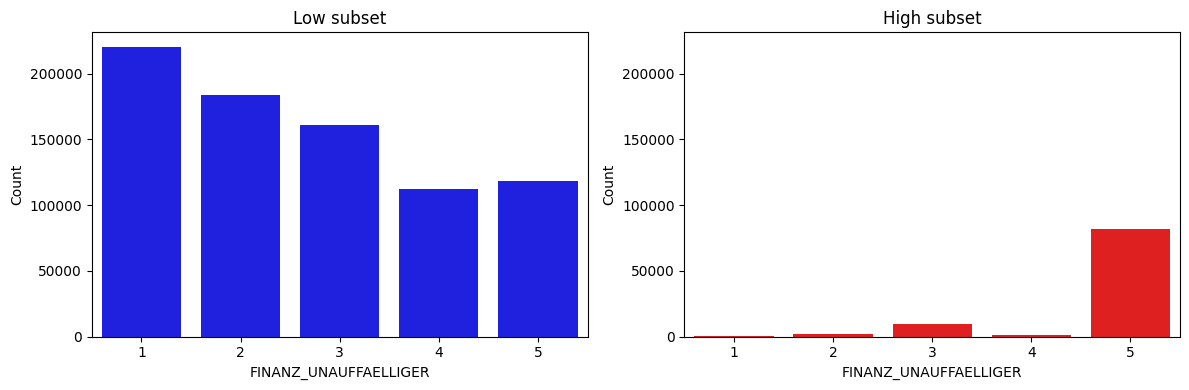

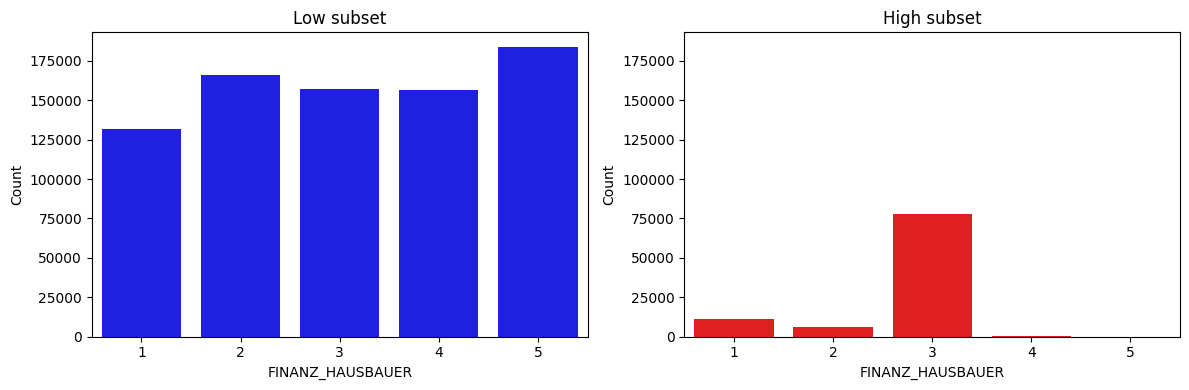

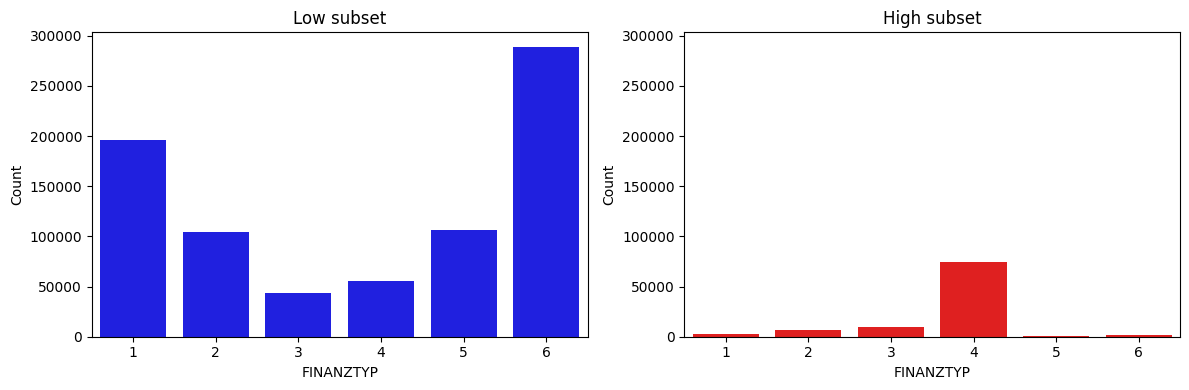

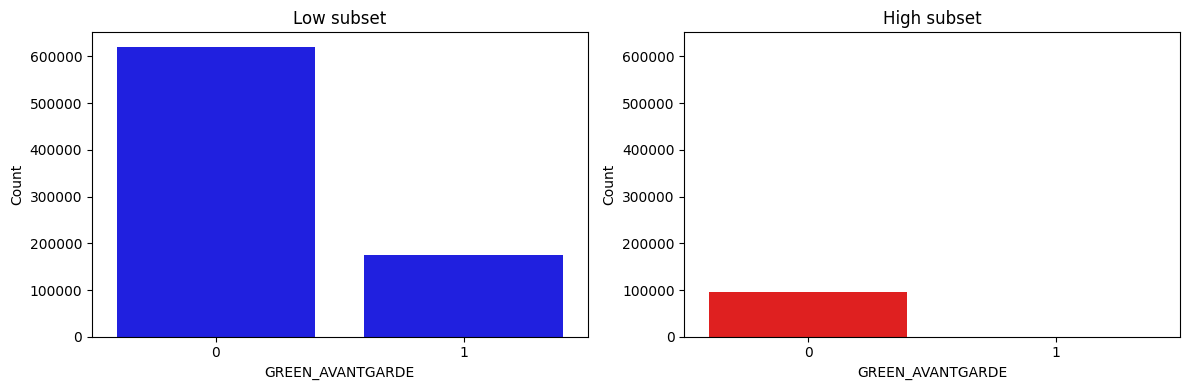

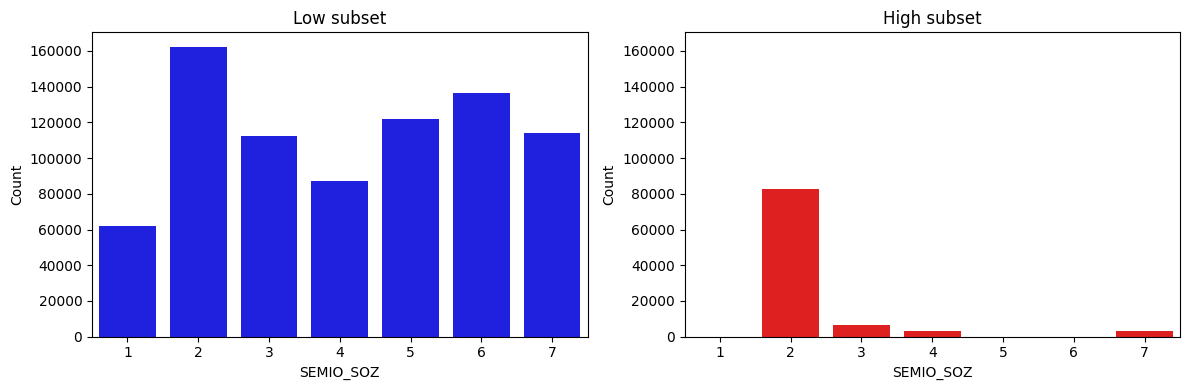

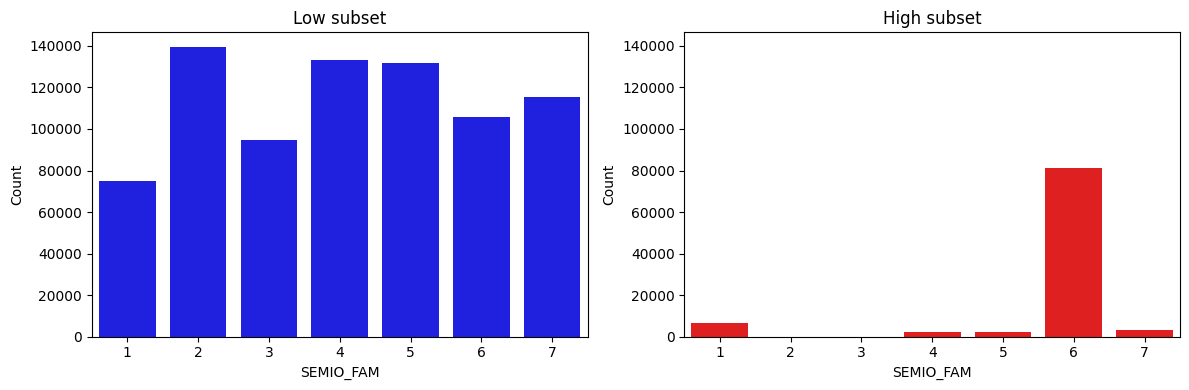

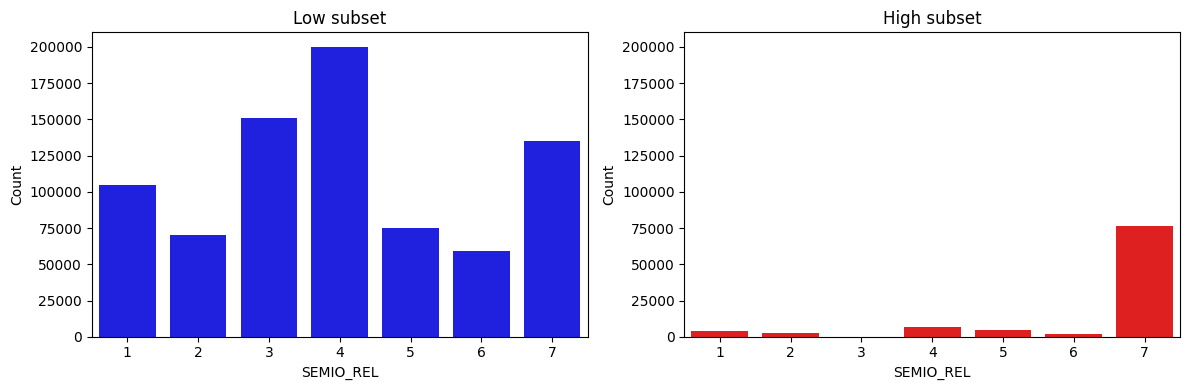

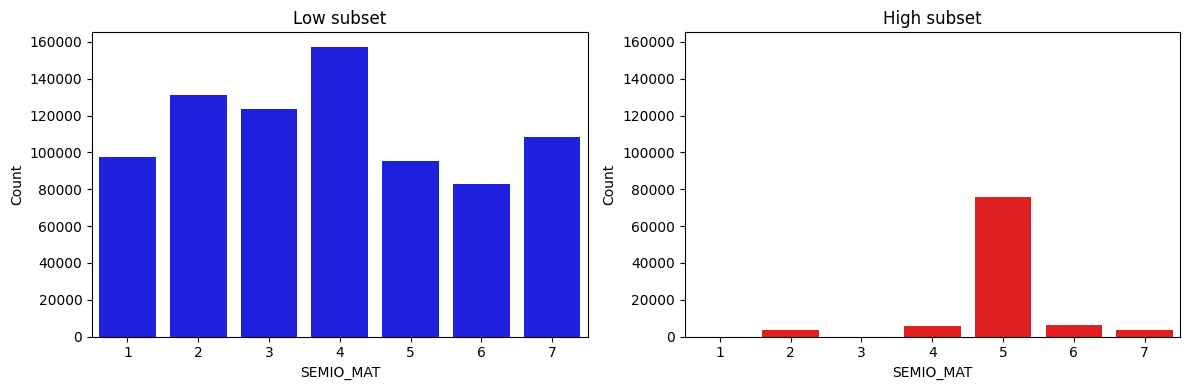

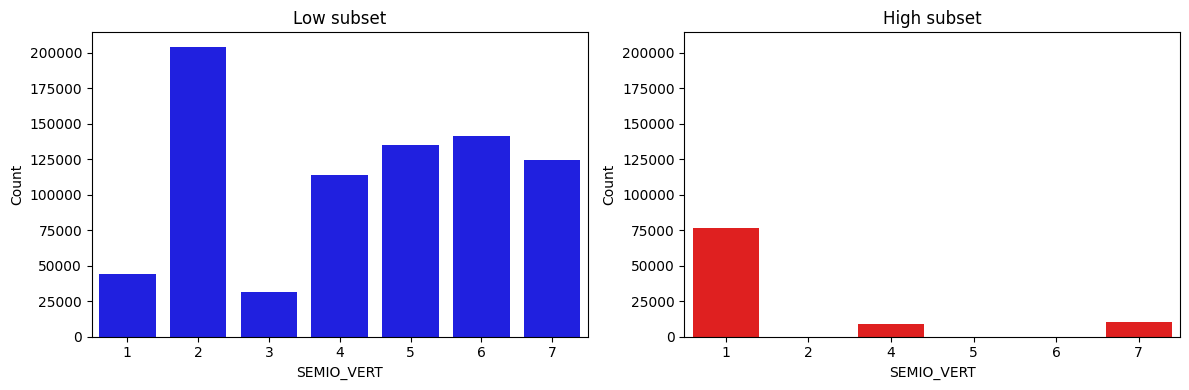

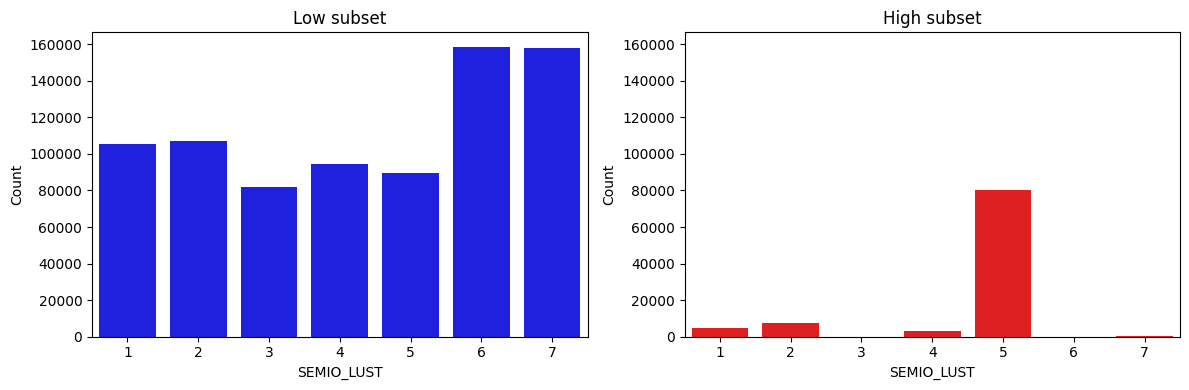

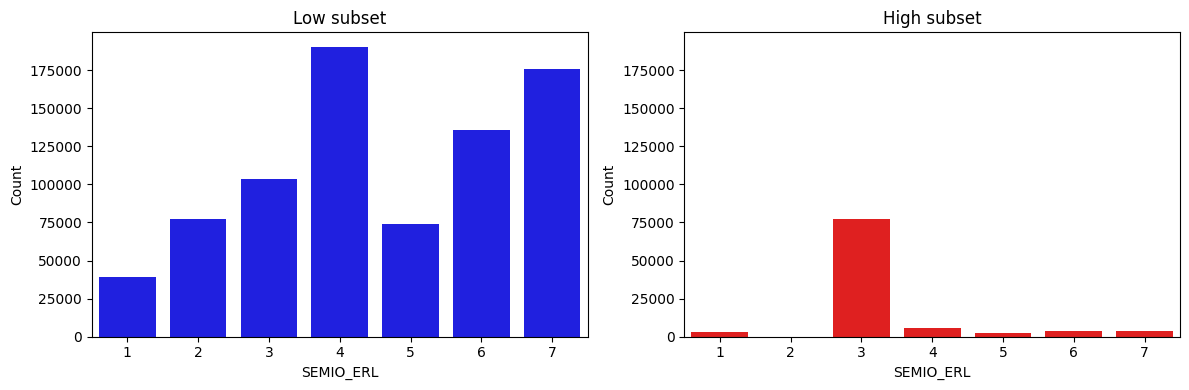

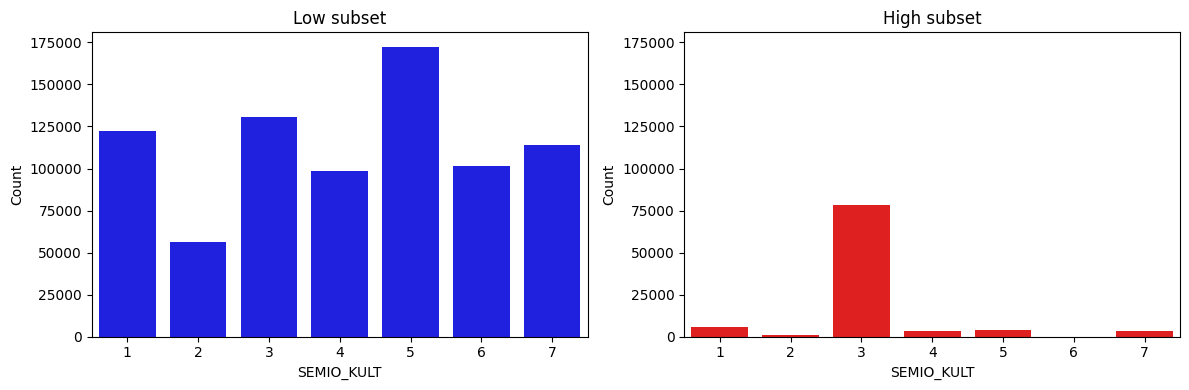

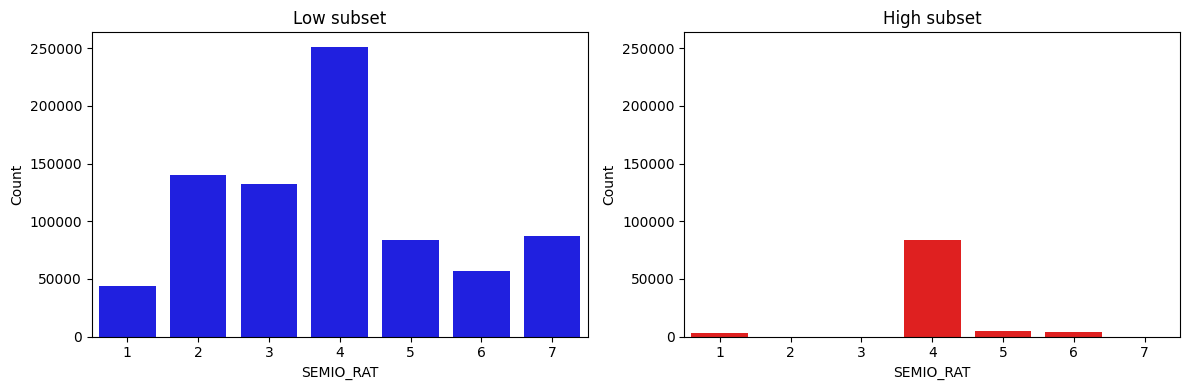

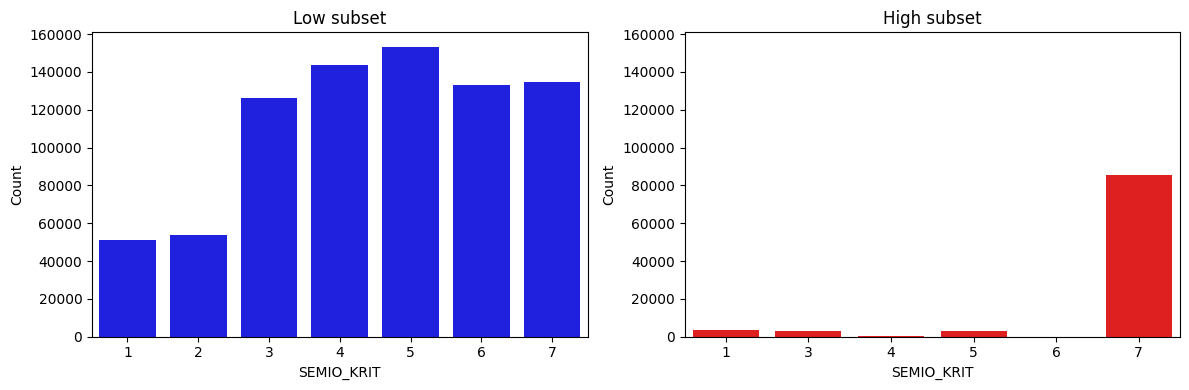

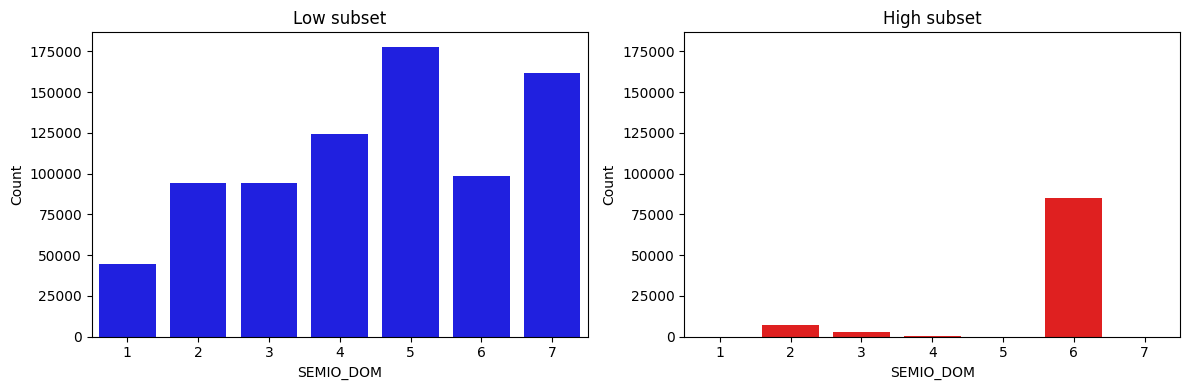

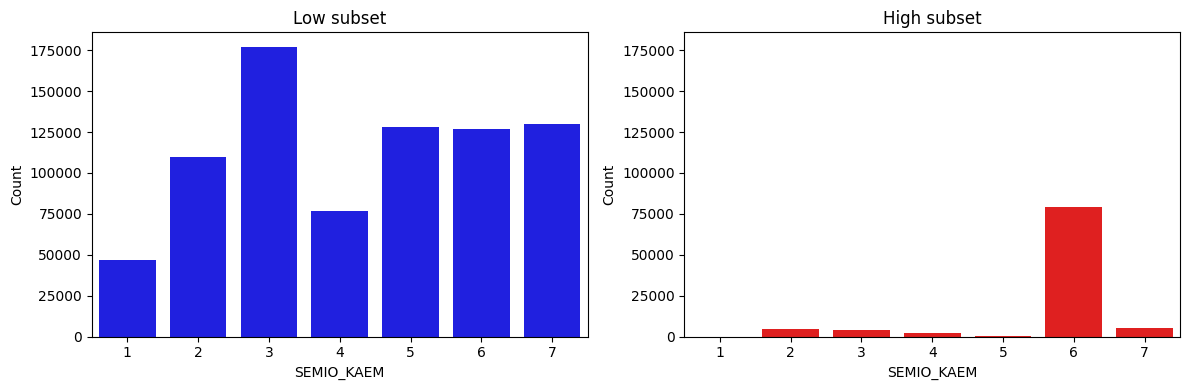

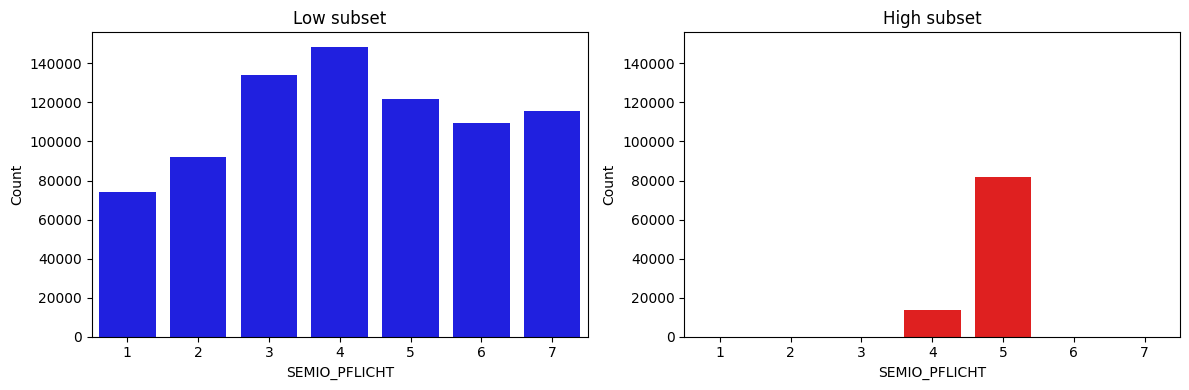

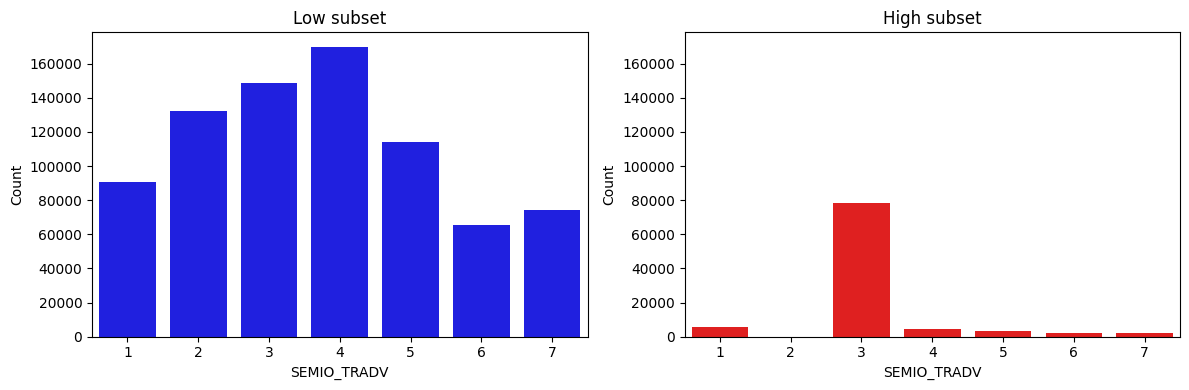

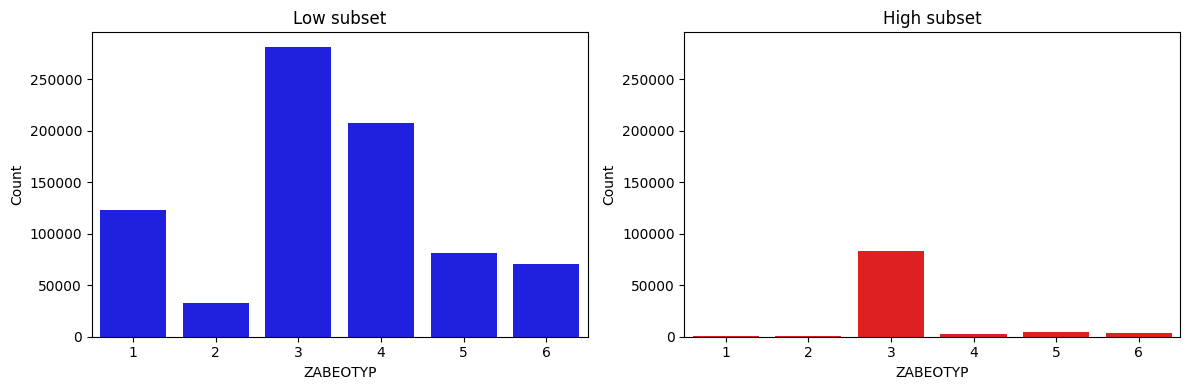

In [49]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

from WGU_D499_P2_DCook.plots import plot_countplout_compare_row_nan_distribution_per_column

# The 'plot_countplout_compare_row_nan_distribution_per_column' function will plot the distribution of values for a given column that is in both exists in both the eda_low_row_nan and eda_high_row_NaN dataframes.

for column in eda_row_nan_common_columns:
    plot_countplout_compare_row_nan_distribution_per_column(eda_low_row_nan_df, eda_high_row_nan_df, column)

In [50]:
# Split the dataset into the two subsets

from WGU_D499_P2_DCook.transformations import row_nan_find_dynamic_nan_threshold, row_nan_divide_by_threshold

# The 'row_nan_find_dynamic_nan_threshold' function will find the optimal threshold value for dividing the dataset into two subsets based on the number of missing values in each row.
threshold = row_nan_find_dynamic_nan_threshold(azdias_general_demographics_nan_col_df, num_clusters = 3, num_init = 'auto', rand_stat = 5654)

# Output the determined threshold value
threshold

np.float64(0.21811074791738036)

Entered Method
Threshold Value: 0.21811074791738036
Actual Loss Value: 0.1074391200386885
If Skipped: threshold is set by previous if check - method vs default - threshold: 0.21811074791738036
Low NaN Dataframe has a shape of: (795469, 81)
High NaN Dataframe has a shape of: (95752, 81)

Threshold final value: 0.21811074791738036

Percentage to be removed is: 0.1074391200386885
Return Common Columns - Enabled
Generating with zero allowed noise
Generating Graph Output


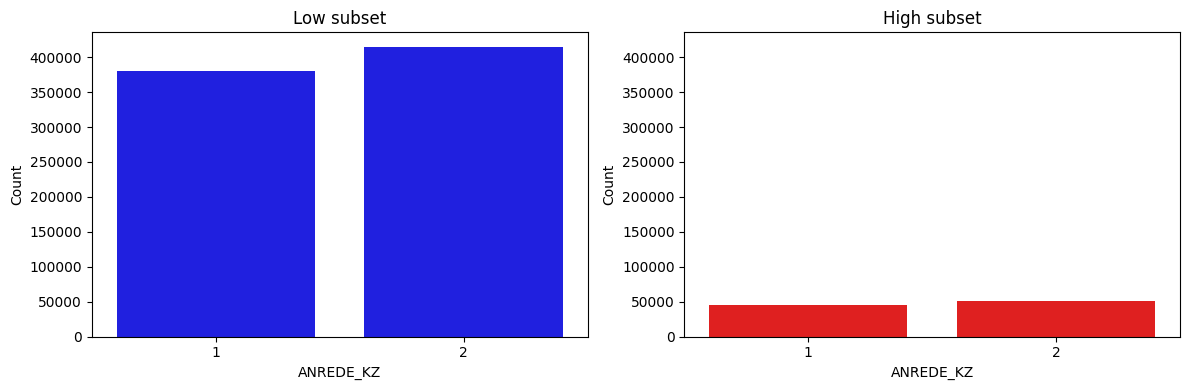

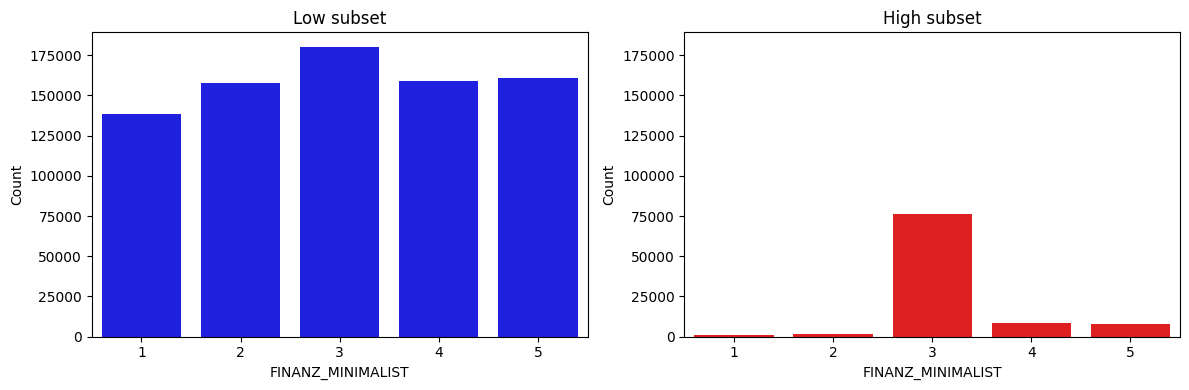

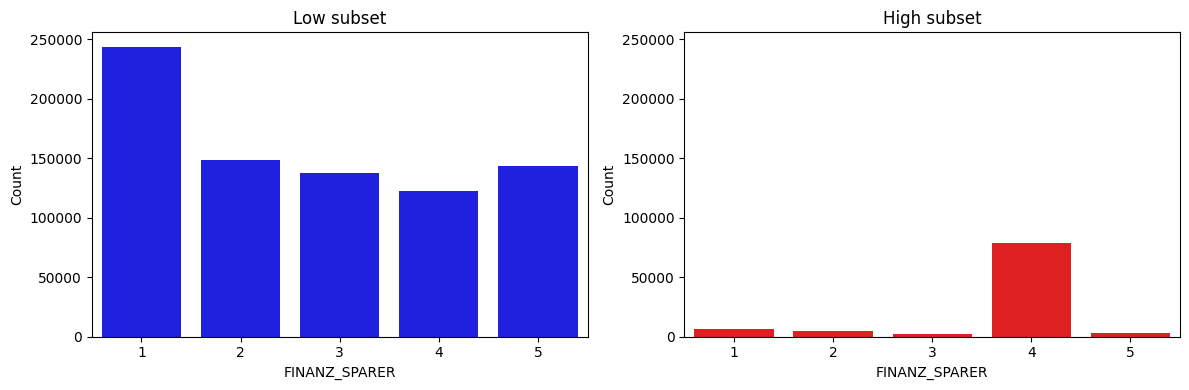

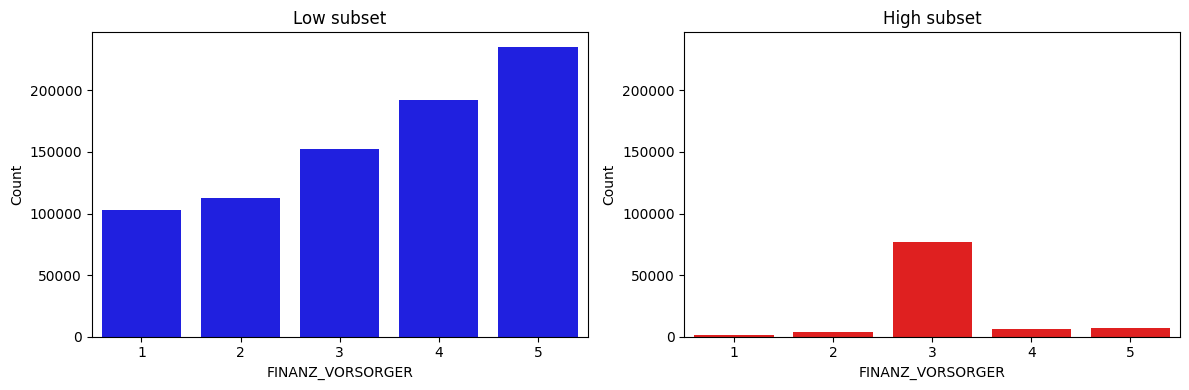

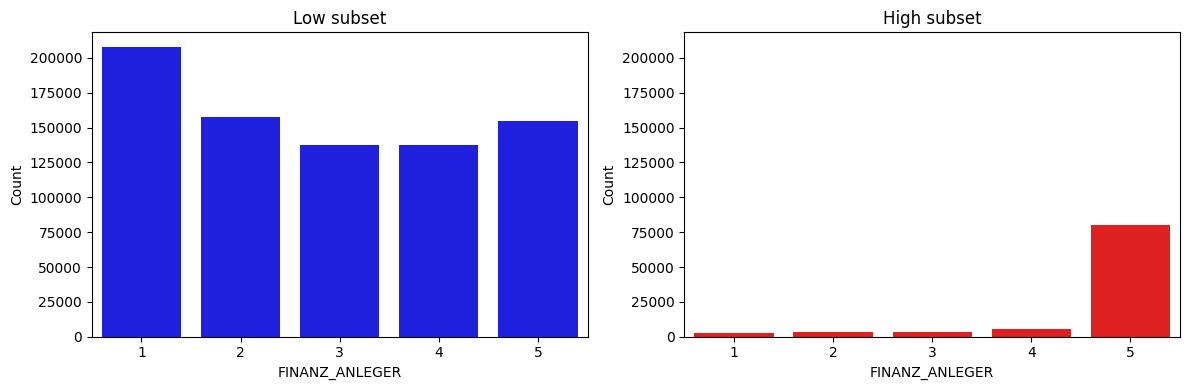

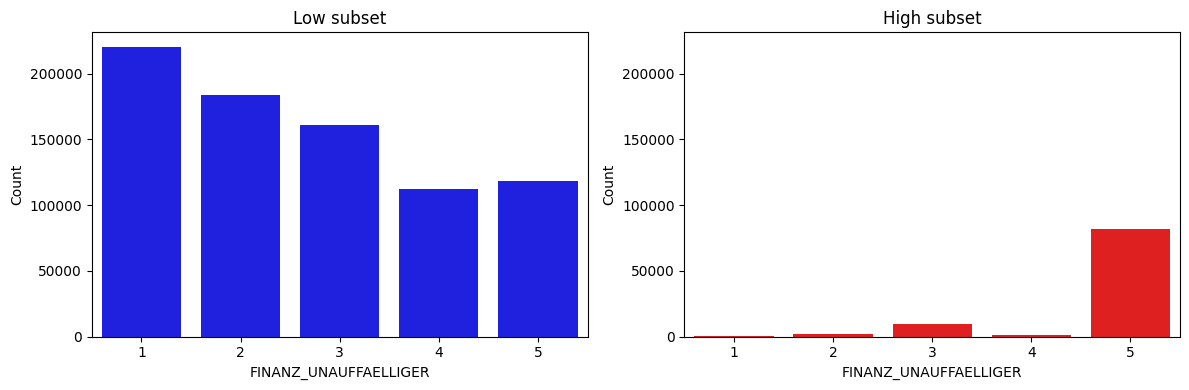

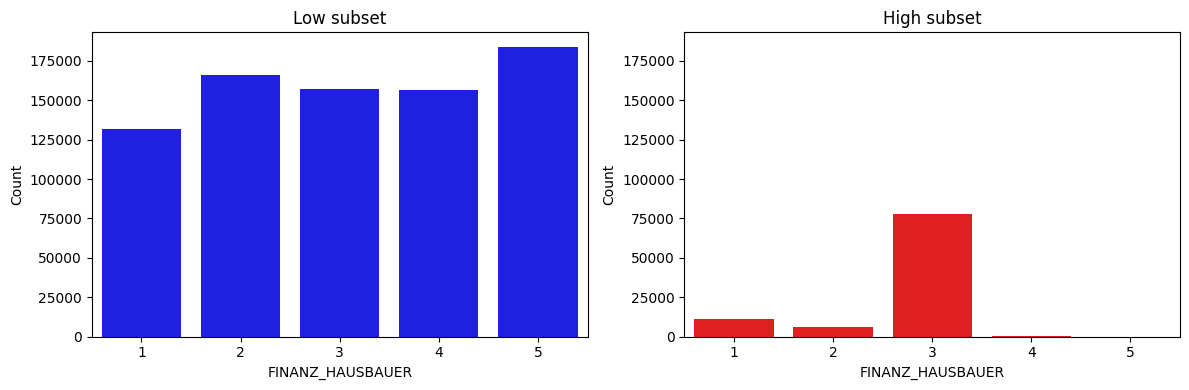

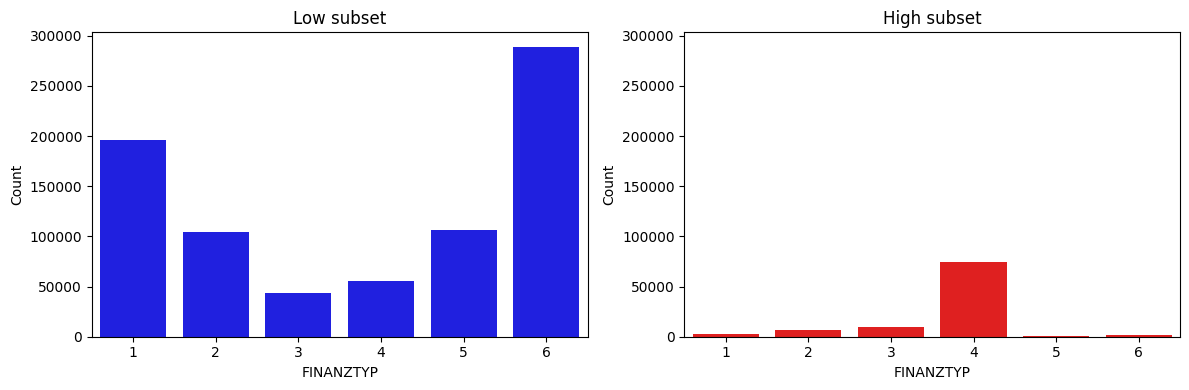

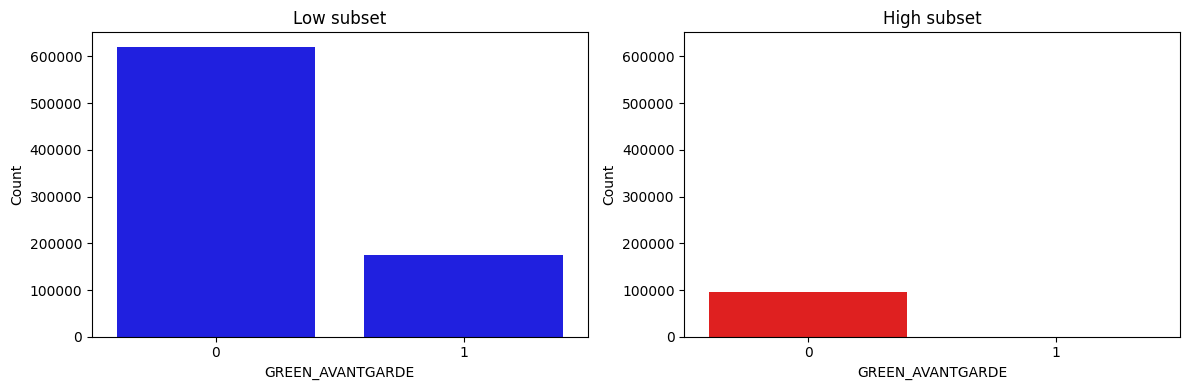

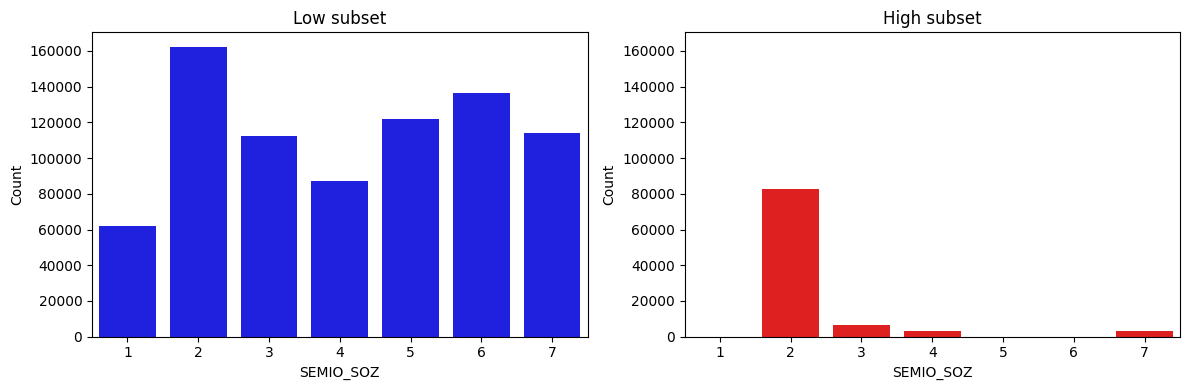

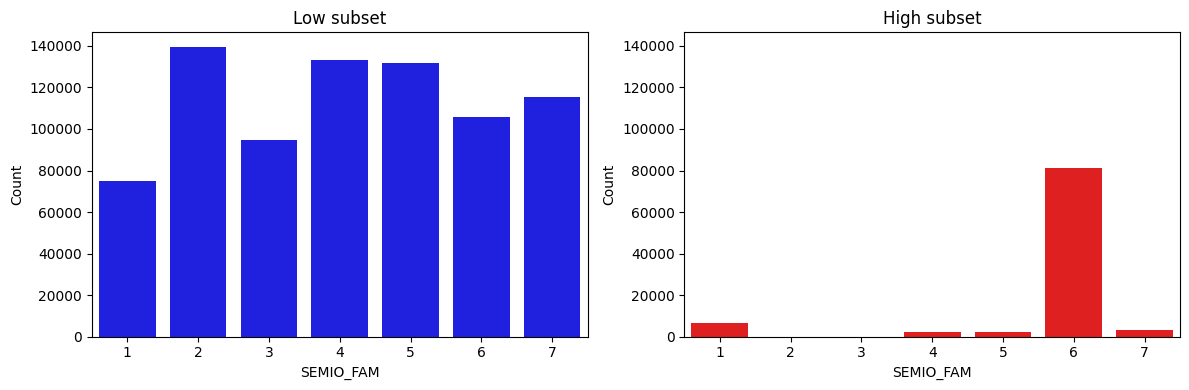

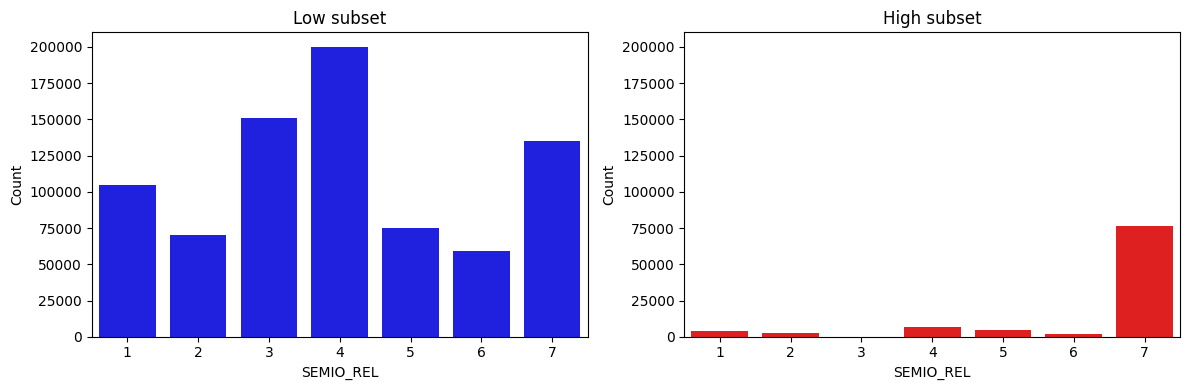

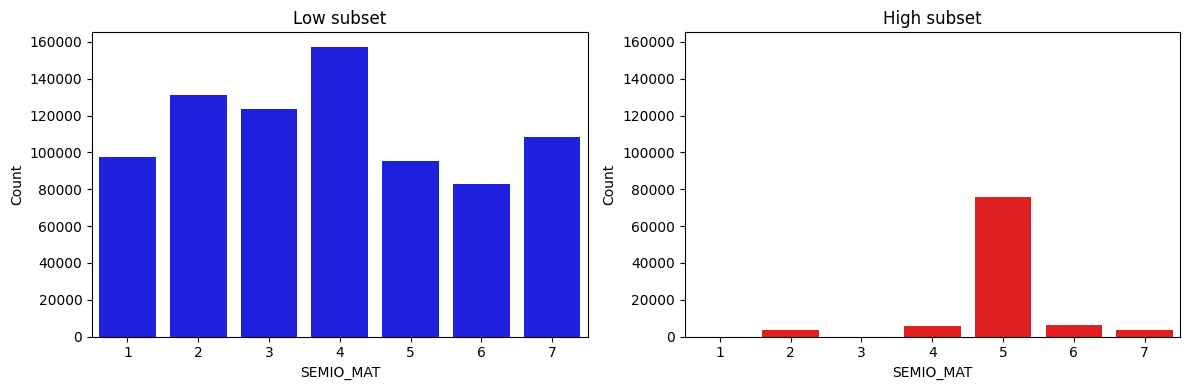

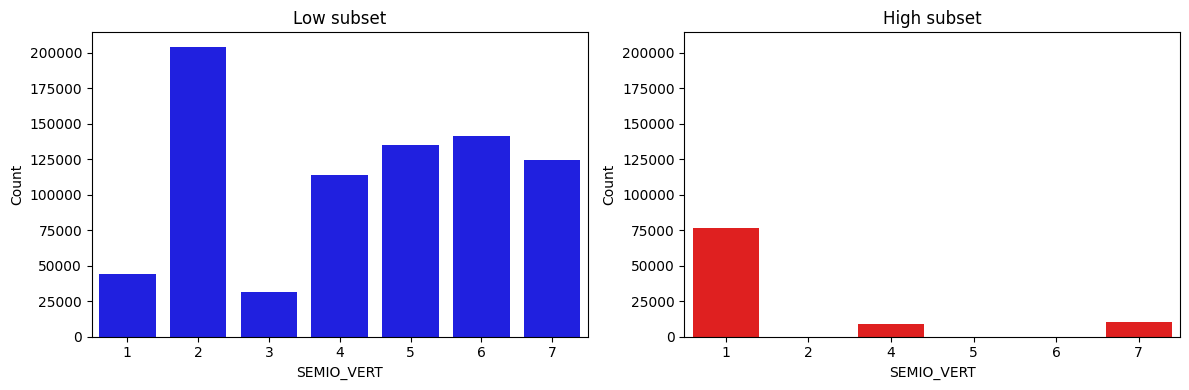

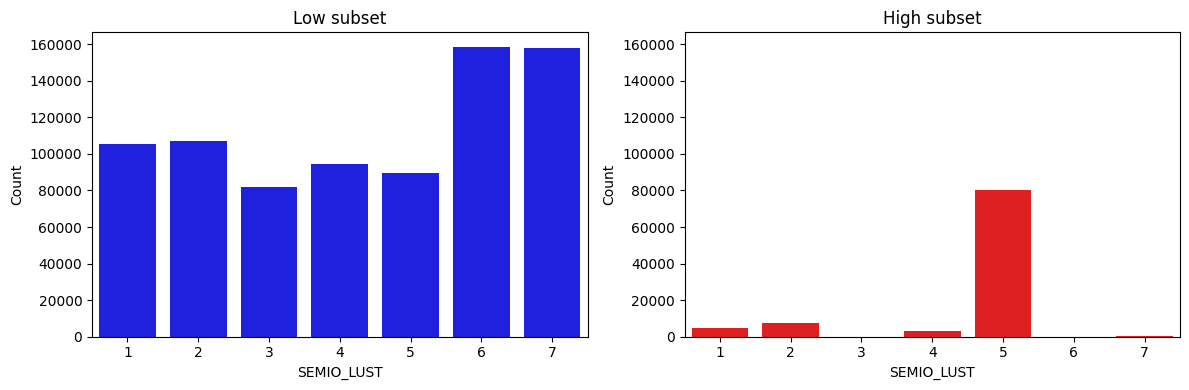

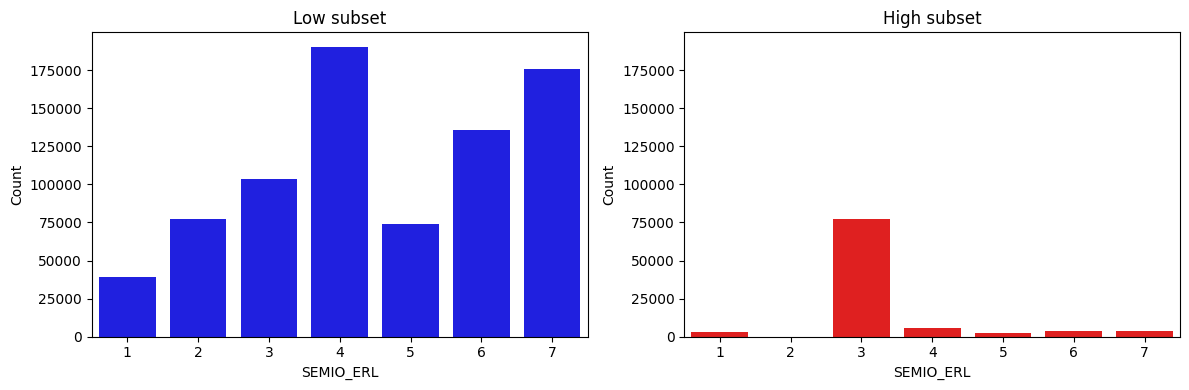

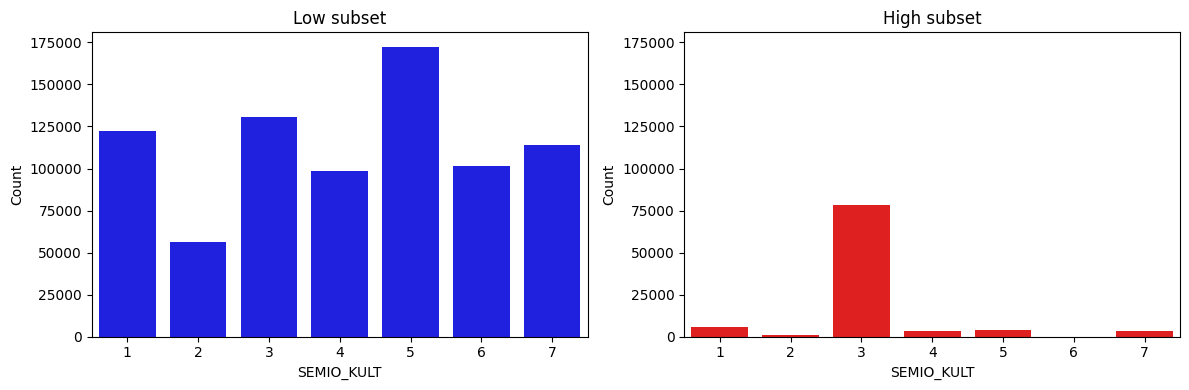

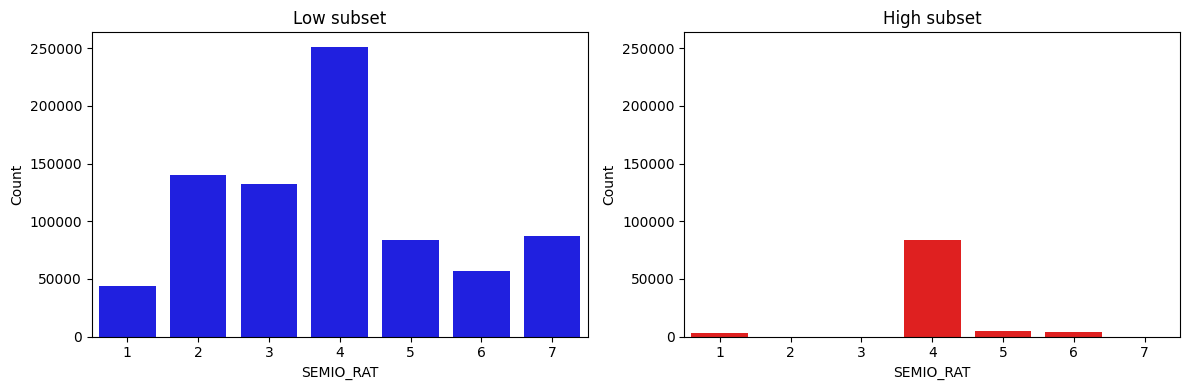

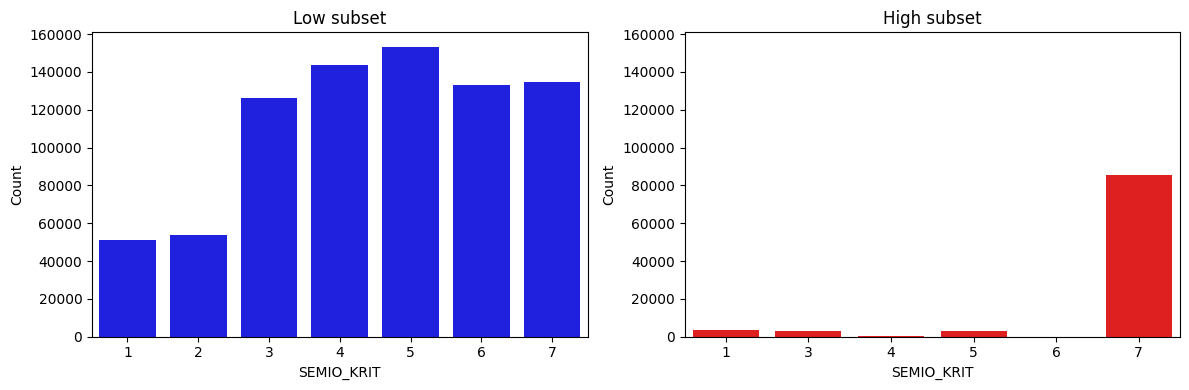

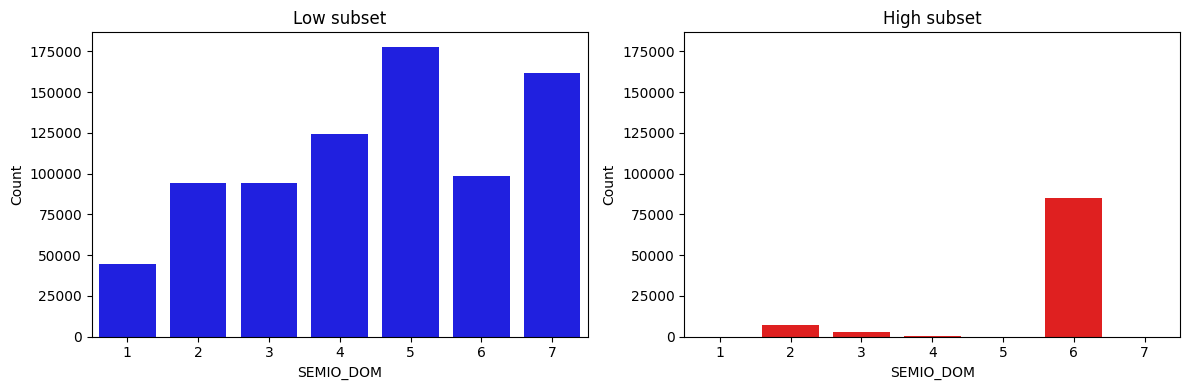

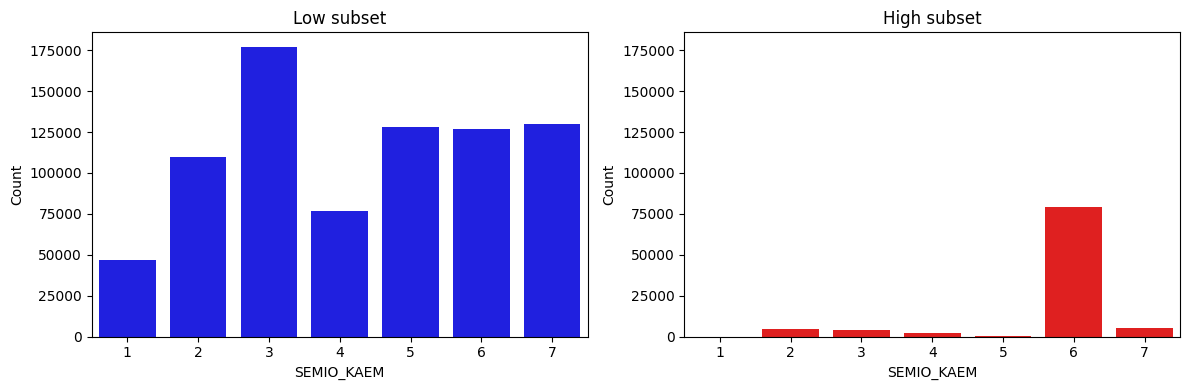

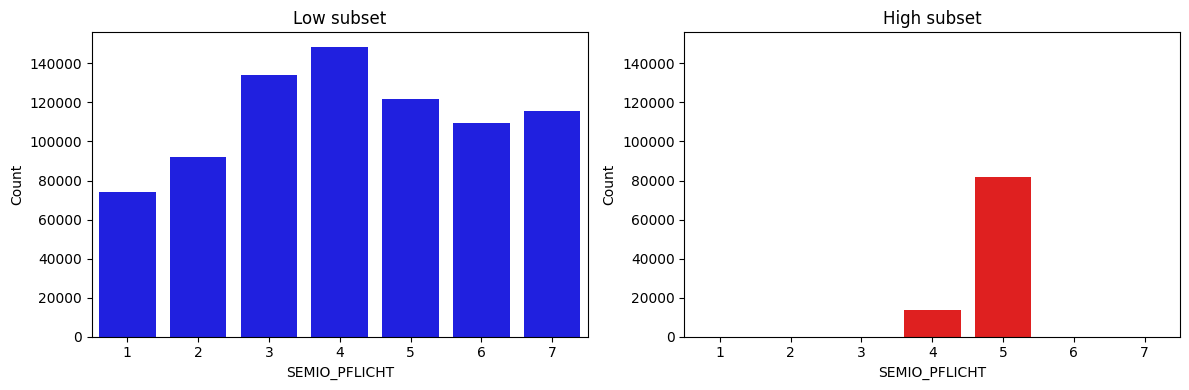

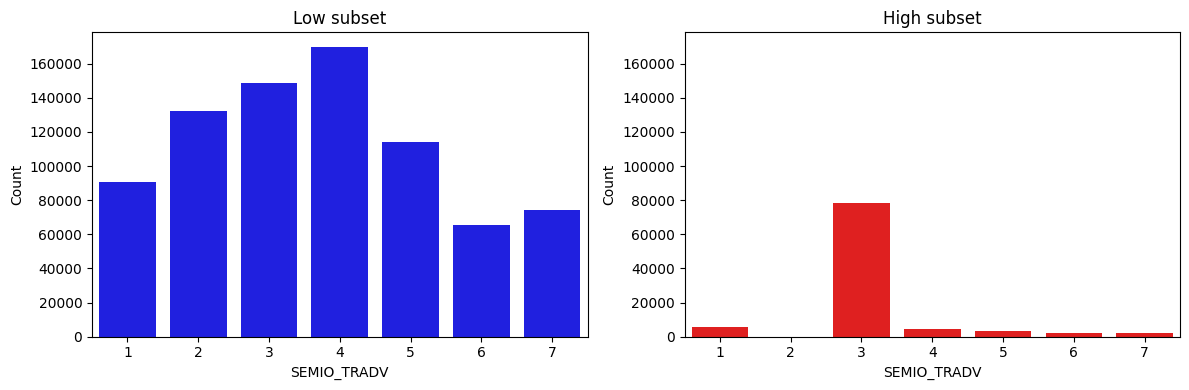

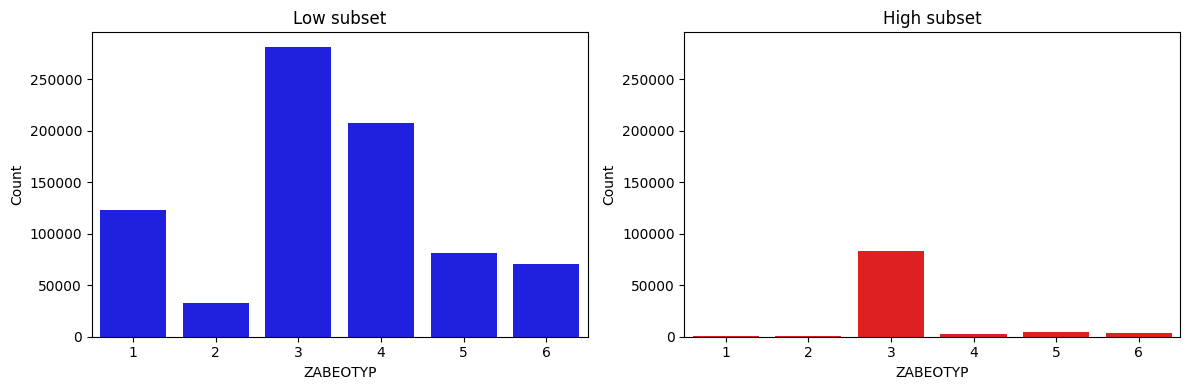

In [51]:
from WGU_D499_P2_DCook.transformations import row_nan_find_dynamic_nan_threshold, row_nan_divide_by_threshold


# The 'row_nan_divide_by_threshold' function will divide the dataframe into two subsets, low row NaN and high row NaN, based on the threshold value determined by the 'row_nan_find_dynamic_nan_threshold' function.
azdias_general_demographics_low_row_nan_dataframe, azdias_general_demographics_high_row_nan_dataframe, row_nan_common_columns, threshold_source, threshold = row_nan_divide_by_threshold(azdias_general_demographics_nan_col_df, max_loss_allowed=0.20, max_nan_per_row=0.10, method='kmeans', return_common_columns=True, allow_noise=False, noise_threshold=0.05, plot_graph=True)



In [52]:
from WGU_D499_P2_DCook.transformations import export_high_row_nan

# Export the high row NaN dataframe to a local file to be saved for later use.
export_high_row_nan(azdias_general_demographics_high_row_nan_dataframe, "archived_data", "azdias_general_demographics_High_Row_NaN")

<class 'pathlib._local.WindowsPath'>


In [53]:

from WGU_D499_P2_DCook.eda import countplot_data_summary_multicol, calculate_proportion_diff, combine_proportion_diff_to_dataframe

#summary_results = countplot_data_summary_multicol(eda_low_row_nan_df, eda_high_row_nan_df, eda_row_nan_common_columns, normalize=False)
#summary_results = countplot_data_summary_multicol(eda_low_row_nan_df, eda_high_row_nan_df, eda_row_nan_common_columns, normalize=False)

summary_results = countplot_data_summary_multicol(eda_low_row_nan_df, eda_high_row_nan_df, eda_row_nan_common_columns)

# Or loop through all:
#for column, dataframe in summary_results.items():
    #print(f"\n=== {column} ===")
    #print(dataframe)


differences_results = calculate_proportion_diff(summary_results)

differences_dataframe = combine_proportion_diff_to_dataframe(differences_results)
differences_dataframe




,column_name,column_value,low_subset,high_subset,low_pct,high_pct,pct_diff
0,ANREDE_KZ,1,380731.0,45185.0,0.478625,0.471896,0.006728
1,ANREDE_KZ,2,414738.0,50567.0,0.521375,0.528104,0.006728
2,FINANZ_MINIMALIST,3,180106.0,76170.0,0.226415,0.795493,0.569078
3,FINANZ_MINIMALIST,2,157523.0,1790.0,0.198025,0.018694,0.179331
4,FINANZ_MINIMALIST,1,138298.0,1289.0,0.173857,0.013462,0.160395
5,FINANZ_MINIMALIST,5,160685.0,8178.0,0.202000,0.085408,0.116592
6,FINANZ_MINIMALIST,4,158857.0,8325.0,0.199702,0.086943,0.112759
7,FINANZ_SPARER,4,122064.0,79159.0,0.153449,0.826709,0.673259
8,FINANZ_SPARER,1,243599.0,6614.0,0.306233,0.069074,0.237159
9,FINANZ_SPARER,5,143554.0,2826.0,0.180465,0.029514,0.150951


In [54]:
#from WGU_D499_P2_DCook.plots import plot_barplot_compare_row_nan_dist_per_column_percentage

#for column in eda_row_nan_common_columns:
    #plot_barplot_compare_row_nan_dist_per_column_percentage(eda_low_row_nan_df, eda_high_row_nan_df, column)


In [55]:
# Creating a new dataframe from a copy of the low row NaN dataframe to be used moving forward. 
azdias_general_demographics_col_row_nan_dataframe = azdias_general_demographics_low_row_nan_dataframe.copy()

In [56]:
from WGU_D499_P2_DCook.utils import check_and_remove_row_nan_columns

# Checking to see if any of the row NaN functions columns there were generated still exist in the dataframe, 
# columns, such as:  'row_nan_total_mean' and the 'row_nan_category' columns.
# If they do exist, then we will remove them from the dataframe.
azdias_general_demographics_col_row_nan_dataframe = check_and_remove_row_nan_columns(azdias_general_demographics_col_row_nan_dataframe)

Temp Columns found in dataframe: row_nan_total_mean
Temp Columns found in dataframe: row_nan_category


In [57]:
from WGU_D499_P2_DCook.dataset import write_checkpoints

# Here I am writing the dataframe to a local file using my 'write_checkpoints' function to store a save state of the dataframe, a checkpoint if you will. 
write_checkpoints("interim_data", "azdias_general_demographics_col_row_nan_dataframe", azdias_general_demographics_col_row_nan_dataframe)

<class 'pathlib._local.WindowsPath'>


In [58]:

# Create a new copy of the dataframe to be used moving forward.
azdias_general_demographics_main_df = azdias_general_demographics_col_row_nan_dataframe.copy()

#### Discussion 1.1.3: Assess Missing Data in Each Row

In the previous section, we identified and removed the features that contained the majority of the missing data, the outlier columns. We also noted in the previous section that roughly two-thirds of  our updated dataset still contained missing values interdispersed throughout the features. As we stated before, these missing values are not necessarily an issue since we have translated values that were purposeful labeled as "missing", "unknown", or "unspecified" into the same value that naturally missing values would be, Numpy NaN. Let's take a closer look into how these missing values are distributed throughout each of the rows throughout our dataset. 

We started by taking our updated dataset and running some simple exploratory data analysis on it to get some rough figures. Using an EDA function I created, we will take a copy of our dataset and create two new columns and append them to the dataset. The first column will store the total number of features that contain a missing value in each row using the sum method, and we will save it into a new column called 'row_nan_total_sum'. The second column will be called 'row_nan_total_mean' and it will store the average number of missing values per row created using the mean method. This function then will print out some descriptive statistics using the describe method and return the new row nan eda dataframe and a value containing the length of the original dataframe calculated using the len function.  

It is here that we can will pass the returned EDA dataframe into our plot functions, specifically the 'plot_hist_row_nan_eda_side_by_side'. This function creates two histograms side by side by plotting each of the previously created row nan columns. The first of these histograms shows us the average percentage of missing values from each row binned into groups. Here we can see that the majority of our columns have less than 10% missing data. The second column shows the total count of missing values per row as a summed total that has been binned as well. This column again validates that the majority of our missing data is less than 10 items per row. The second function we run displays the descriptive statistics generated from the describe method in a side by side dataframe as well. Our visual analysis is further backed up by these stats. We can see that on average missing per row in the proportional eda is roughly 7% missing data from each row with a deviation of 16% in this mean. Our upper quartile of missing data is less than 4%. The average missing in our count totals per row is roughly 6 items, with a deviation of roughly 13 items. The max value see was 49 items, which is 62% of the row, and our upper quartiles have 3 items missing per row. 

This gives us some good idea of how our missing data is distributed. Howevver, let's take it a step further and work towards the isolation and removal of rows that would be considered subpar from a quality stand-point. To do this, we are going to start by dividing our dataset into two parts, one for the rows with a low percentage of missing data and the other for rows for rows that we have determined have a high amount of missing data. However, how should we divided our dataset? Should we divide using a hard-coded maximum value? Should we dynamically calculate the ideal amount? What about quanity? How much data loss from removal is acceptable? These are all really good questions to have when approaching a problem such as this. 

There really isn't a one size fits all solution and we have to be adaptable to resolve these. This is why I decided to take the more difficult approach and design a solution that would be dynamic in nature but also have some fallbacks or fail-safes in place. My solution attempts to dyanamically locate and assign a threshold value to divide my dataset into either low or high. It actually does it by utilizing a technique that we will cover more so later in the project, Clustering. We perform a KMeans clustering analysis on our dataframe. We do this by first converting our dataset into a series of the average percentage of nan values per row. We then reshape this data and pass it into our KMeans object. Once we have fit our data to the KMeans Object, we will extract the center values from our cluster object, and then sort and flatten them into a a list which we will obtain the average value of our centers. This value is what we will set as our optimal threshold value. Now that we have located what we believe is the optimal threshold value to safely divide our dataset into two, we then perform an comparision between the mean value of missing values per row in our dataset against our opitmal threshold value. This generates us a series of true and false values for which we will obtain the porition or average of our dataset that is above our threshold value. This average is then assigned to the 'actual_loss' variable. Why do we do this, this is the first step to one of my safe guards, the actual loss value represents how much of our dataset will be lost if we decided to split our dataset using that threshold value. How is this important you may ask? By knowing how much of our data will be removed by this threshold value, we are able to setup fallbacks to allow us to prevent against shrinking out dataset and affecting the overal quality of our data. It's extremely important to have good quality data, but having too small of a dataset can create issues of its own. So its a balancing act on how much of our data we should keep verus how good the quality of our data is. In my solution, I decided that I never wanted to lose more than 20% of my total data. So how is this used? Well if the threshold value we determiend using our Kmeans clustering analysis was found to create an actual loss of data greater than 20%, then what we will do is fall back to a hard coded threshold value we have set, which in our case is 10% maximum allowed missing data. What about if said hard coded threshold causes greater than 20% loss of data? In my current design, I have built my function to prioritize good quality data in quanitity size. However, if we end up in a fall back scenario due to maximium loss of data with our dynamic threshold value, then our priority scope will shift from a quanity focus to almost purely quality focused. Meaning we will filter out all rows that have greater than 10% missing data. 

So at this point, we have determined a threshold to divide our dataset, so let's do that using our obtained threshold value. To do this, my function then makes a copy of the dataset and creates a new column to hold the row nan mean value. We create a second column to hold a category value based on that rows mean value, if the value is above our threshold value, then the row is labeled as 'high' and if the value is lower than it is labeled as 'low'. Then we split the dataset into two subset based on the row's label. 

Now that we have split the two datasets, let's compare them to see if they have any commonality or patterns to the distribution that we can see. To do this, we will create a new list containing only columns that exist in both datasets for a fair review. We do this by appending any column name that is found to exist in both dataframes.  It is here that you will notice that I have added a noise feature to my comparision. In my function, I added the ability to either accept only columns that have no missing values or the ability to define an acceptable percentage level of missing values per row in each column. If the values are above the accpetable level of noise then they are not included in the column comparision analysis, if the noise functionality is enabled. From there, we will save the list of column names for our next step. 

So now that we've split our dataframe into two subsets and obtained a list of columns that exists in both our low row nan eda dataframe and our high row nan dataframe, we can now graph and compare our results to see the distribution of values between the two dataset. We do this iterating through our list of common columns that we just generated previously with both our dataframes, creating a two figure plot using the countplot function for each column. 

In our analysis, the first thing that is noticable is that the values count are dramatically different. However, it is my opinion that this can be explained based on the differences in the dataset sample sizes. With that in mind, let's take another more close look at the data distribution and adjusted our perspective to compensate for the size difference. One the first things we notice is for the majority of our columns, we are able to see that data distributions are vastly different, almost inversly different. There are a few outliers in this analysis where the analysis appears similar like in the "GREEN_AVANTGARDE" and the "ANDEDE_KZ" column. 

Furthermore, when we look at the shape of the data distrubtion we are able to see that the low nan eda dataframe has more normal distributions shapes, the 'bell shape', there are some skewing and/or peaks but otherwise, I would say they are well spread. The high nan eda dataframe on the other hand has singular peaks or high skews to one side. It would be best to perform further indepth analysis into how the rows that have high values of missing data are associated with their relative high value columns, i.e. the singular peak columns of data in the the high nan eda dataframe. 

Unfortunately, in the scope of this project, we have been instructed to remove the rows that we have identified to have high nan values for now and proceed further with our project. So that is what we will do. The high nan row eda dataset will be exported to the data\archived folder and we will proceed forward with the low nan dataset. To do the split and export I have created a copy of the split eda function used prior but this one is designed to be used with the graph function and export function together in tandem instead of separately. 



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [59]:
# How many features are there of each data type?

from WGU_D499_P2_DCook.utils import get_feature_types_and_count

feature_counts, interval_columns, numeric_columns, ordinal_columns, categorical_columns, mixed_columns = get_feature_types_and_count(features_summary_manual_df)

feature_counts

,type,count
0,ordinal,49
1,categorical,18
2,mixed,6
3,numeric,6


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [60]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

from WGU_D499_P2_DCook.eda import eda_column_identify_binary_multilevel_category

binary_set = set()
multi_set = set()
error_set = set()

binary_set, multi_set, error_set = eda_column_identify_binary_multilevel_category(azdias_general_demographics_main_df, categorical_columns, binary_set, multi_set, error_set)



In [61]:

binary_columns_first_pass_list = list(binary_set)
multilevel_columns_first_pass_list = list(multi_set)
error_columns_first_pass_list = list(error_set)

In [62]:

binary_columns_first_pass_list


['OST_WEST_KZ', 'ANREDE_KZ', 'SOHO_KZ', 'GREEN_AVANTGARDE', 'VERS_TYP']

In [63]:
# Print the length of the binary columns list and the number of unique items in the list to confirm the sizes match
print(len(binary_columns_first_pass_list))
print(len(set(binary_columns_first_pass_list)))



5
5


In [64]:
from WGU_D499_P2_DCook.utils import column_dtype_check

column_dtype_check(azdias_general_demographics_main_df, binary_columns_first_pass_list)

Running column_dtype_check...

Column OST_WEST_KZ has a type of object which is NOT an approved type.

Column ANREDE_KZ has an approved type of int64
Column SOHO_KZ has an approved type of float64
Column GREEN_AVANTGARDE has an approved type of int64
Column VERS_TYP has an approved type of float64


In [65]:
# Re-encode categorical variable(s) to be kept in the analysis.

from WGU_D499_P2_DCook.transformations import apply_if_column_exists
from WGU_D499_P2_DCook.features import column_correction_ost_west_kz 


azdias_general_demographics_main_df =  apply_if_column_exists(
    azdias_general_demographics_main_df,
    'OST_WEST_KZ',
    column_correction_ost_west_kz,
    remove_if_missing=True,
    remove_from_lists=[binary_columns_first_pass_list, multilevel_columns_first_pass_list],
    apply_per_column=True, 
    keep_original = False
)


In [66]:
from WGU_D499_P2_DCook.transformations import apply_if_column_exists
from WGU_D499_P2_DCook.features import column_correction_vers_type 


azdias_general_demographics_main_df =  apply_if_column_exists(
    azdias_general_demographics_main_df,
    'VERS_TYP',
    column_correction_vers_type,
    remove_if_missing=True,
    remove_from_lists=[binary_columns_first_pass_list, multilevel_columns_first_pass_list],
    apply_per_column=True
)

In [67]:
from WGU_D499_P2_DCook.transformations import apply_if_column_exists
from WGU_D499_P2_DCook.features import column_correction_anrede_kz 


azdias_general_demographics_main_df =  apply_if_column_exists(
    azdias_general_demographics_main_df,
    'ANREDE_KZ',
    column_correction_anrede_kz,
    remove_if_missing=True,
    remove_from_lists=[binary_columns_first_pass_list, multilevel_columns_first_pass_list],
    apply_per_column=True
)

In [68]:
multilevel_columns_first_pass_list

['NATIONALITAET_KZ',
 'GEBAEUDETYP',
 'ZABEOTYP',
 'LP_STATUS_FEIN',
 'CAMEO_DEUG_2015',
 'CJT_GESAMTTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_GROB',
 'FINANZTYP',
 'SHOPPER_TYP',
 'LP_FAMILIE_FEIN',
 'CAMEO_DEU_2015',
 'LP_STATUS_GROB']

In [69]:
from WGU_D499_P2_DCook.transformations import apply_if_column_exists
from WGU_D499_P2_DCook.features import column_correction_cameo_deu_2015 

azdias_general_demographics_main_df =  apply_if_column_exists(
    azdias_general_demographics_main_df,
    'CAMEO_DEU_2015',
    column_correction_cameo_deu_2015,
    remove_if_missing=True,
    remove_from_lists=[binary_columns_first_pass_list, multilevel_columns_first_pass_list],
    apply_per_column=True
)

In [70]:

convert_familie_int_to_label = {
    1: 'single', 
    2: 'couple', 
    3: 'single_parent', 
    4: 'family', 
    5: 'multihousehold'
}

convert_status_int_to_label = {
    1: 'low_income', 
    2: 'avg_income', 
    3: 'independant', 
    4: 'houseowner', 
    5: 'top_earner'
}

convert_gfk_urlaubertyp_int_to_label = {
    1: 'event_travelers',
    2: 'family_oriented_vacationists',
    3: 'winter_sportspeople',
    4: 'culture_lovers',
    5: 'nature_fans',
    6: 'hiker',
    7: 'golden_agers',
    8: 'homeland_connected_travelers',
    9: 'package_tour_travelers',
    10: 'connoisseurs',
    11: 'active_families',
    12: 'active_singles',
    13: 'without_vacation',
}

convert_cjt_gesamttyp_int_to_label = {
    1: 'ad_consumption_minimalist',
    2: 'ad_consumption_traditionalist',
    3: 'ad_interested_store_shopper',
    4: 'ad_interested_online_shopper',
    5: 'ad_cross_channel_enthusiast',
    6: 'ad_enthusiast_limited_cross_channel'
}

convert_shopper_typ_int_to_label = {
    0: 'external_supplied_hedonists',
    1: 'shopping_stressed',
    2: 'family_shopper', 
    3: 'demanding_shopper'
}

convert_nationalitaet_kz_int_to_label = {
    1: 'german_sounding',
    2: 'foreign_sounding',
    3: 'assimilated_names'
}

convert_finanztyp_int_to_label = {
    1: 'low_financial_interest_minimalist',
    2: 'money_saver_sparer',
    3: 'home_ownership_hausbauer',
    4: 'be_prepared_vorsorger',
    5: 'investor_anleger',
    6: 'inconspicuous_unauffaelliger'
}

convert_zabeotyp_int_to_label = {
    1: 'green',
    2: 'smart',
    3: 'fair_supplied',
    4: 'price_driven',
    5: 'seeking_orientation',
    6: 'indifferent'
}

conver_gebaeudetyp_int_to_label = {
    1: 'residential_building',
    2: 'residential_building_unknown_household',
    3: 'mixed_residential_company_building',
    4: 'mixed_building_unknown_household_company',
    5: 'company_building_unknown_company',
    6: 'mixed_building_unknown_household',
    7: 'company_building',
    8: 'mixed_building_unknown_company'
}






In [71]:

original_column_names=['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'GFK_URLAUBERTYP', 'CJT_GESAMTTYP', 'SHOPPER_TYP', 'NATIONALITAET_KZ', 'FINANZTYP', 'ZABEOTYP', 'GEBAEUDETYP']

map_dictionary_list=[[convert_familie_int_to_label], [convert_status_int_to_label], [convert_gfk_urlaubertyp_int_to_label], [convert_cjt_gesamttyp_int_to_label], [convert_shopper_typ_int_to_label], [convert_nationalitaet_kz_int_to_label], [convert_finanztyp_int_to_label], [convert_zabeotyp_int_to_label], [conver_gebaeudetyp_int_to_label]]
                     
new_columns_list=[]

In [72]:
from WGU_D499_P2_DCook.transformations import apply_if_column_exists
from WGU_D499_P2_DCook.features import feature_mapping 


azdias_general_demographics_main_df = apply_if_column_exists(
    azdias_general_demographics_main_df,
    original_column_names,
    feature_mapping,
    True,
    [binary_columns_first_pass_list, multilevel_columns_first_pass_list],
    False,
    original_column_names, map_dictionary_list, new_columns_list, True, False, False, True
)

In [73]:
multilevel_columns_first_pass_list.remove("LP_STATUS_FEIN")
multilevel_columns_first_pass_list.remove("LP_FAMILIE_FEIN")


In [74]:
one_hot_encode_column_list = multilevel_columns_first_pass_list

In [75]:
one_hot_encode_column_list

['NATIONALITAET_KZ',
 'GEBAEUDETYP',
 'ZABEOTYP',
 'CAMEO_DEUG_2015',
 'CJT_GESAMTTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_GROB',
 'FINANZTYP',
 'SHOPPER_TYP',
 'CAMEO_DEU_2015',
 'LP_STATUS_GROB']

In [76]:
from WGU_D499_P2_DCook.features import column_encode_multi_category_to_single_onehot


for column in one_hot_encode_column_list:
    azdias_general_demographics_main_df = column_encode_multi_category_to_single_onehot(azdias_general_demographics_main_df, column, drop_first_flag = False, drop_original = True)



In [77]:
from WGU_D499_P2_DCook.utils import convert_column_names_to_uppercase


azdias_general_demographics_main_df = convert_column_names_to_uppercase(azdias_general_demographics_main_df)



In [78]:
azdias_general_demographics_main_df.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_B', 'CAMEO_DEU_2015_C', 'CAMEO_DEU_2015_D',
       'CAMEO_DEU_2015_E', 'CAMEO_DEU_2015_F', 'LP_STATUS_GROB_AVG_INCOME',
       'LP_STATUS_GROB_HOUSEOWNER', 'LP_STATUS_GROB_INDEPENDANT',
       'LP_STATUS_GROB_LOW_INCOME', 'LP_STATUS_GROB_TOP_EARNER'],
      dtype='object', length=138)

In [79]:
from WGU_D499_P2_DCook.utils import get_info_to_dataframe

get_info_to_dataframe(azdias_general_demographics_main_df)

,Column,Non-Null Count,Null Count,Dtype
0,ALTERSKATEGORIE_GROB,792713,2756,float64
1,ANREDE_KZ,795469,0,int64
2,FINANZ_MINIMALIST,795469,0,int64
3,FINANZ_SPARER,795469,0,int64
4,FINANZ_VORSORGER,795469,0,int64
5,FINANZ_ANLEGER,795469,0,int64
6,FINANZ_UNAUFFAELLIGER,795469,0,int64
7,FINANZ_HAUSBAUER,795469,0,int64
8,GREEN_AVANTGARDE,795469,0,int64
9,HEALTH_TYP,759299,36170,float64


#### Discussion 1.2.1: Re-Encode Categorical Features


For the next step of our project, we took a more close inspection into our dataset's features. We began this phase by first by identifying and categorizing our features based on the type of data they contain. We did this by passing our updated features summary dataframe into a function that would filter the dataframe by its 'data_type' column then output a list containing the names of all columns that were of that data type, as well as a summary dataframe that contained the value counts of each data_type. This means that ultimately, we ended up with one summary data frame and five lists (interval, numeric, ordinal, categorical, and mixed). 

Based on our value counts dataframe, we have 49 ordinal columns, 18 categorical, 6 mixed, and 6 numeric columns. First and foremost, we can see that we do not have any interval columns in our updated features summary dataframe, which indicates they were removed during the outlier isolation and removal. We will continue to generate this list as other datasets may have those data types, and with each part of this project I've attempted to build it as if it was a production product. With that said, let's continue on, we were instructed in the project that numeric and interval data can be left as is, and for this project, we should assume that the ordinal data is interval in nature and thus we do not have to modify this. With more time, I would like to circle back around and address this to make the project more universal and able to handle these typical cases and other edge cases. Now, with those columns removed, we have a remaning 24 columns out of the 79 that need to be addressed, 6 of these are mixed and the remaining 18 are categorical. 

To make the process more automated and robust, I developed a function that takes our dataframe and a predefined list of categorical columns to systematically group them based on an initial review of the data, classifying each as either binary or multi-level. The function does this by first creating three empty sets, one for binary, one for multi-level, and one to catch columns that failed to be identified. Then quite simply the function checks the numer of unique values that are within each column's data. If there is exactly two, the column is added to the binary set, if there is more than two, then it is added to the multi-level, and anything else is added to the error set, and returns these when finished. Sets are used to enusre the column names are immutable and no duplicates occur. Once we have our returned sets, we then pass them into the list function to make a list of the column names. We do this because later in the project we will want to be able to remove columns from the lists, since they were generated using the features summary dataframe and not our main dataframe, if they do not exist when performing function calls. 

Let's start with our binary columns, we find that there are five columns that are binary, "GREEN_AVANTGARDE", "SOHO_KZ", "OST_WEST_KZ", "ANREDE_KZ", and "VERS_TYP". In the multi-level categories we identified 13 columns, which were: "GFK_URLAUBERTYP", "CJT_GESAMTTYP", "LP_STATUS_FEIN", "LP_FAMILIE_GROB", "SHOPPER_TYP", "CAMEO_DEUG_2015", "CAMEO_DEU_2015", "LP_STATUS_GROB", "NATIONALITAET_KZ", "FINANZTYP", "ZABEOTYP", "LP_FAMILIE_FEIN", "GEBAEUDETYP". For now, let's set the multi-level categorical columns to the side and switch back over to our binary category items. Moving back to our binary columns, the next check we perform is to see verify the type of value are stored in each column, more specifically if the column is of the int or float type or something else. Upon running this check we discover that the 'OST_WEST_KZ' column is the only one that contains non-numeric based values. All other ones are numirically based binary values. Using our data dictionary, we are able to determine that the 'OST_WEST_KZ' column uses the values "O" and "W" to distigush the historical land reference of the building for that consumer. For this column, we will need to re-encode the values to new ones. As for the other columns like 'VERS_TYP' and 'ANREDE_KZ' have numerical based binary values but they do not follow the typical binary format, instead of '0' and '1', they are '1' and '2'. We will map these to the proper values to keep a more uniform structure throughout our project. 

Now that we've completed our investigation, let's move to correcting these columns. For the 'OST_WEST_KZ' column we will create two new columns called 'OST_WEST_KZ_WEST' and 'OST_WEST_KZ_EST'. Next we will prefil these columns with '0' to handle the our unknown/missing data fields. We fill these nan values in now because by the end of our project we will need to have them removed anyways. It is a safe assumption that missing values can be consider false since we will be applying the false condition to both the new '..._KZ_WEST' and '..._KZ_EAST' columns. Next using the an index matching operation with a data conversion, we will overwrite our pre-fill with the proper matched row values. In the West column, all values that were "W" were marked at true and then converted to binary, resulting in a '1' value for each row where the index match evaluates true. Inversely, the East column matched any row value that was "O". Thus we have effectively encode this single column into two columns for each value in the column thhat contains a binary representation. In other words, we have manually performed the panda's get_dummies fuction, or more commonly known as one hot encoding. 

For the 'VERS_TYP' and 'ANREDE_KZ' columns, we will use the map function to remap the '1' values to '0' and the '2' values to '1' to align them with a more standardized format. Thus conluding our binary categorical columns work, we can now move on to our mutli-level categorical items. 

As stated before, for our multi-level categorical columns we found 13 of them. Again, using the Data dictionary we are able to determine that out of these 13 columns, we are been able to identify that there are six columns of importance, which are: "LP_FAMILIE_GROB", "LP_FAMILIE_FEIN", "LP_STATUS_GROB", "LP_STATUS_FEIN","CAMEO_DEUG_2015", and "CAMEO_DEU_2015". These stand out from the other columns as they display a clear correlation or granulatity of the same data. For this columns, I will be handling them a certain way. As for the other columns, which were: "GFK_URLAUBERTYP", "CJT_GESAMTTYP", "SHOPPER_TYP",  "NATIONALITAET_KZ", "FINANZTYP", "ZABEOTYP", "GEBAEUDETYP", when we compare each value to it's meaning using the data dictionary, we are able to see that for the most part they are unique enough from each other. So what we will do is re-encode each of these columns values from the interger format into the string definition of the value, then convert it to a category data type. Then when we perform one-hot encoding later in the section, each of these columns will be converted in to a one hot encoding of it's value with more understandable names. 

With that said, I will be doing the same technique to the "LP_STATUS_GROB" and "LP_FAMILIE_GROB" columns. These two columns house a more highlevel overview of family type and social status. For a more granular level of detail we can look at their counterpart columns the   "LP_FAMILIE_FEIN" and the "LP_STATUS_FEIN". However, for this project's scope we are going to drop the granular data for now to keep the project a little more streamlined and simple. As for the "CAMEO_DEUG_2015" and "CAMEO_DEU_2015" these two also share a correlation between their data's meanings, but unlike the other four the data can be divided with a little bit less work. In the "CAMEO_DEU_2015" feature column we have data stored in a hexidecimal format, with the first character being a number and the second being a letter. The number is a direct correlation to the data in the "CAMEO_DEUG_2015" feature column, while the letter creates a division in the different wealth-life stage typology from within each core level. So for this column, I will be splitting the two digit values in half and keeping only the character letter. These can then be in junction with the the "CAMEO_DEUG_2015" column during our analysis. 

As stated before, the final step for this phase is to perform one-hot encoding using the Pandas get_dummies function. Doing this will turn all of my original features colums from a single multi-value feature into multiple feature columns representing a binary state for each different unique value for each core feature. I perform this one-hot encoding on the correct columns by assigning my multilevel category list into a new list object then iterating over each item in that list applying the get_dummies function to it. 

Now that our categorical items are done, we can move on to the mixed data features. 


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [80]:
mixed_columns

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


In [81]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.


# PRAEGENDE_JUGENDJAHRE --> three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west)
# two new variables :: an interval-type variable for decade, and a binary variable for movement.
#     Decades: 40s, 50s, 60s, 70s, 80s, 90s
#     Movement: Mainstream = 0, Avantgarde = 1
#     Nation: Can either do One-Hot Encoding -- Possibly more manual then use of the function -- where E+W equals 1 and 1 for both east and west. 
#          Or.. 
#             I can use multihot encoding (MultiLabelBinarizer from sklearn.preprocessing) labeling the nation as [East], [West], ['East', 'West']
#             Then run that through MultiLabelBinarizer() then encode it into two new columns for east and west. The multi-hot encoding allows for multiple 1s in a row

### 1.18. PRAEGENDE_JUGENDJAHRE
# Data dictionary
# Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
# - -1: unknown
# -  0: unknown
# -  1: 40s - war years (Mainstream, E+W)
# -  2: 40s - reconstruction years (Avantgarde, E+W)
# -  3: 50s - economic miracle (Mainstream, E+W)
# -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
# -  5: 60s - economic miracle (Mainstream, E+W)
# -  6: 60s - generation 68 / student protestors (Avantgarde, W)
# -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
# -  8: 70s - family orientation (Mainstream, E+W)
# -  9: 70s - peace movement (Avantgarde, E+W)
# - 10: 80s - Generation Golf (Mainstream, W)
# - 11: 80s - ecological awareness (Avantgarde, W)
# - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
# - 13: 80s - Swords into ploughshares (Avantgarde, E)
# - 14: 90s - digital media kids (Mainstream, E+W)
# - 15: 90s - ecological awareness (Avantgarde, E+W)

# Decades:
# 40s - 1, 2
# 50s - 3, 4
# 60s - 5, 6, 7
# 70s - 8, 9, 
# 80s - 10, 11, 12, 13
# 90s - 14, 15

# Movement:
# Mainstream: 1, 3, 5, 8, 10, 12, 14
# Avantgrade: 2, 4, 6, 7, 9, 11, 13, 15

# East & West
# East: 7, 12, 13
# West: 6, 10, 11, 
# East & West: 1, 2, 3, 4, 5, 8, 9, 14, 15

from WGU_D499_P2_DCook.transformations import apply_if_column_exists
from WGU_D499_P2_DCook.features import column_reengineering_pragende_jugendjahre

azdias_general_demographics_main_df =  apply_if_column_exists(
    azdias_general_demographics_main_df,
    'PRAEGENDE_JUGENDJAHRE',
    column_reengineering_pragende_jugendjahre,
    one_hot_encode=True, keep_original=False,
    remove_if_missing=False,
    remove_from_lists=None,
    apply_per_column=True
)




In [82]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# CAMEO_INTL_2015 --> two axes: wealth and life stage
# Convert two digit, signle code to 2 single value codes. 
#     Tens Place = Wealth Status
#         1 = Wealthy, 
#         2 = Prosperous, 
#         3 = Comfortable, 
#         4 = Less Affluent, 
#         5 = Pooer
#     Ones Place = Life Stage Typology (Struture/Makeup/etc)
#         1 = PreFamily Couples/Singles, 
#         2 = Young Couples With Children, 
#         3 = Families With School Age Children, 
#         4 = Older Familys & Mature Couples, 
#         5 = Elders In Retirement


from WGU_D499_P2_DCook.transformations import apply_if_column_exists
from WGU_D499_P2_DCook.features import column_reengineering_cameo_intl_2015

azdias_general_demographics_main_df =  apply_if_column_exists(
    azdias_general_demographics_main_df,
    'CAMEO_INTL_2015',
    column_reengineering_cameo_intl_2015,
    one_hot_encode=True, keep_original=False,
    remove_if_missing=False,
    remove_from_lists=None,
    apply_per_column=True
)




#### Discussion 1.2.2: Engineer Mixed-Type Features

In the sections above and below, we move to begin to analyze our mixed-values features to determine if they can be utilized through re-engineering or if for now, we should isolate and removed for now. Using the same list of columns prior, we can see that we have six mixed-value columns are: 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN', 'WOHNLAGE', and 'PLZ8_BAUMAX'. Using our Data dictionary to review each feature's data values, I believe that it is possible for use to keep five of the six features, and maintain their data's purpose to a relatively high degree. 

In the section above I performed the reengineering of the two required columns for this project, 'PRAEGENDE_JUGENDJAHRE' and. 'CAMEO_INTL_2015'. 

For the 'PRAEGENDE_JUGENDJAHRE' feature, we can see that there is at least three different types of data being represented within the feature's value. The values represent different time period's social-political movements that were occurring in the Germany. The first of these is the decade of consumer youth. The second of these is whether the political movement at the time was mainstream or avantgarde. The third of these indicates whether the assigned movement was occurring in only occurring in East Germany, only in West Germany, or in both (this include pre-fall and post-fall of the berlin wall). As instructed for this project, we will re-engineer this feature into two separate features, one to indicate the decade for the social-political movement and the other to indicate if the movement was main-stream or avant-garde. 

For now, the region of the movement will be excluded as instructed to do so, but it is my opinion that there is a chance that this column's representation could have been included. To do this, I believe that we could create two new columns to represent each region, east and west. From there, we could map the appropriate binary representation for each movement to their column, but then for columns that have both we would need to assign true values to both columns. However, the first issue with doing this is that Panda's get_dummies or one-hot encoding from sci-kit learn, do not allow for multiple true values in one-hot, but we may be able to use 'multi-label binarizer' from sci-kit learn instead to accomplish them. Otherwise, it's just simple manual mapping like we've been doing for the other categorical columns. I think the second issue would be the possibility that by attempting to include this data and splitting the column, we run the risk of introducing a false relationship between the different region features and the movement types. 

To re-engineer this feature, we started by creating two new columns for the feature, one for the decade and one for the movement type. To do this we start by making a dictionary and storing each of the feature's values as keys. Then for each key we provided an integer value that represented each decade, 1-6. Then for the movement type, we performed the same steps, created a dictionary the same size as our value count as the value, then assigned either a one or two for the movement type to indicate mainstream or avant-garde. The function I created to perform this also takes note of the original column's location in the dataframe and will pop the new columns and insert them into the dataset directly after the original column. This way I maintain some similarity to the original data structure. My function, if enable, then completes by removing the original column and performing one-hot encoding using Panda's get_dummies method. 

For the second column, 'CAMEO_INTL_2015', the process starts the same with a review of the data dictionary details. Here we see that this feature details the wealth to life stage typology for the consumer, or two different types of data. These values represent the different levels of wealth, as well as the life stage the consumer is currently in. We can see that there is a repeating pattern in the way the data is presented, which is that the first value represents the wealth level, and the second value represents the life-stage. 

For this column, my function will start by converting the entire column into string format. Then we create two new columns that will contain the value for wealth and for life stage and prefill them with nan values. Next, I create a mask that I apply to the whole column of data, checking for only numerical items. The next step is done by filtering the column and assigning the result to the corresponding new column. As we obtain the results of the index filter, we will apply our mask to them to ensure they are numbers then using string slicing take the first digit and insert it into the wealth column. We run this again, this time for the second-string item, with the same mask validation, apply those values to the second column for life-stage. Finally, my function will delete the original column after popping and inserting those columns to the correct position. Then apply one-hot encoding using Panda's get_dummies. 

With that done, we now shift our attention to the remaining three columns, 'LP_LEBENSPHASE_FEIN', 'WOHNLAGE', and 'PLZ8_BAUMAX', and what we will do to them in the section below. For the 'LP_LEBENSPHASE_FEIN', we do the same methods we did above for this one, but this time the column has three pieces of data being represented, life stage, wealth status, and family stage. So using the same method as above, I create three dictionary mappings to make the original value into a string label representing them. For the life stage levels, I used 'younger_age', 'middle_age', 'advanced_age', and 'retirement_age'. For the family stage, I used 'single', 'couples', 'single_parent', 'family', and 'multihousehold'. Finally for wealth stage, I used 'low', 'average', 'wealthy', and 'top'. These values were mapped to the appropriate matching integer value and saved to their appropriate column. Then my function performed the same steps as it did above, moved them to the same location, removed the original column, and one-hot encoded the column. 

As for the next two columns, 'WOHNLAGE', and 'PLZ8_BAUMAX', I decided that I would drop the need to drop part of the feature's data meaning. For the 'WOHNLAGE' feature, I decided to convert into two new columns, one for rural or one for neighborhood. I then mapped the values and assigned them to the appropriate column. Effectively, I removed the scoring of the neighborhood and kept it to basically city or no city. For the 'PLZ8_BAUMAX', it was performed basically the exact same steps. I created the two new columns, and they were listed as 'PLZ8_BAUMAX_Family_home' or  ‘PLZ8_BAUMAX_Business'. Effectively, I dropped the amount of housing that was indicated for each value and instead converted it to either family home or business home. Again, moving to the same location, deleting the first column, and one-hot encoding the columns. 

As for the last column, 'LP_LEBENSPHASE_GROB'. I dropped this column from the dataset since I was keeping the 'LP_LEBENSPHASE_FEIN'. As you recall from above, columns that contain the 'GROB' and 'FEIN' indicate different levels of granularity of the same data. Since I reengineered the 'FEIN' column, I will remove the 'GROB' column. After doing this, we will be done with re-encoding and re-engineering. 



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [83]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

from WGU_D499_P2_DCook.transformations import apply_if_column_exists 
from WGU_D499_P2_DCook.features import column_reengineering_lp_lebenshase, column_reengineering_wohnlage, column_reengineering_plz8_family_business_building_flag


azdias_general_demographics_main_df =  apply_if_column_exists(
    azdias_general_demographics_main_df,
    'LP_LEBENSPHASE_FEIN',
    column_reengineering_lp_lebenshase,
    one_hot_encode = True, keep_original = False,
    remove_if_missing=False,
    remove_from_lists=None,
    apply_per_column=True
)



azdias_general_demographics_main_df =  apply_if_column_exists(
    azdias_general_demographics_main_df,
    'WOHNLAGE',
    column_reengineering_wohnlage,
    keep_original = False,
    remove_if_missing=False,
    remove_from_lists=None,
    apply_per_column=True
)


azdias_general_demographics_main_df =  apply_if_column_exists(
    azdias_general_demographics_main_df,
    'PLZ8_BAUMAX',
    column_reengineering_plz8_family_business_building_flag,
    keep_original = False,
    remove_if_missing=False,
    remove_from_lists=None,
    apply_per_column=True
)

In [84]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#azdias_general_demographics = azdias_general_demographics.drop(columns='LP_LEBENSPHASE_GROB')
#azdias_general_demographics = azdias_general_demographics.drop(columns='LP_FAMILIE_FEIN')
#azdias_general_demographics = azdias_general_demographics.drop(columns='LP_STATUS_FEIN')

# Drop the following mixed columns
azdias_general_demographics_main_df.drop(columns=['LP_STATUS_FEIN', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_GROB'], inplace=True)


In [85]:
from WGU_D499_P2_DCook.utils import convert_column_names_to_uppercase

azdias_general_demographics_main_df = convert_column_names_to_uppercase(azdias_general_demographics_main_df)

In [86]:
azdias_general_demographics_cleaned_prescaled_main_df = azdias_general_demographics_main_df.copy()

In [87]:
from WGU_D499_P2_DCook.utils import get_info_to_dataframe

get_info_to_dataframe(azdias_general_demographics_cleaned_prescaled_main_df)

,Column,Non-Null Count,Null Count,Dtype
0,ALTERSKATEGORIE_GROB,792713,2756,float64
1,ANREDE_KZ,795469,0,int64
2,FINANZ_MINIMALIST,795469,0,int64
3,FINANZ_SPARER,795469,0,int64
4,FINANZ_VORSORGER,795469,0,int64
5,FINANZ_ANLEGER,795469,0,int64
6,FINANZ_UNAUFFAELLIGER,795469,0,int64
7,FINANZ_HAUSBAUER,795469,0,int64
8,GREEN_AVANTGARDE,795469,0,int64
9,HEALTH_TYP,759299,36170,float64


In [88]:

from WGU_D499_P2_DCook.dataset import write_checkpoints

# Here I am writing the dataframe to a local file using my 'write_checkpoints' function to store a save state of the dataframe, a checkpoint if you will. 
write_checkpoints("interim_data", "azdias_general_demographics_cleaned_prescaled_main_df", azdias_general_demographics_cleaned_prescaled_main_df)

<class 'pathlib._local.WindowsPath'>


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [89]:
def clean_data(cd_dataframe_original, cd_features_dataframe, ft_ops, FeatureTransformer):
    """
    Cleans the input dataframe by performing various data cleaning steps such as
    converting missing value codes into NaNs, removing selected columns and rows,
    selecting, re-encoding, and engineering column values.
    Parameters:
    - dataframe: pd.DataFrame
        The input dataframe to be cleaned.  
    - features_dataframe: pd.DataFrame
        The features summary dataframe containing information about the columns.
    - ft_ops: list
        A list of operations to be performed on the dataframe through the FeatureTransformer class.
    - FeatureTransformer: class
        A class that contains methods for transforming the dataframe based on the specified operations.

    Returns:    
    - pd.DataFrame
        The cleaned dataframe after performing all the specified operations.


    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...

    from WGU_D499_P2_DCook.dataset import write_checkpoints
    from WGU_D499_P2_DCook.utils import convert_unknown_missing_to_nan, check_and_remove_row_nan_columns, get_feature_types_and_count, convert_column_names_to_uppercase
    from WGU_D499_P2_DCook.eda import eda_identify_outlier_columns, get_invalid_level_eda_identify_outlier_columns, eda_column_identify_binary_multilevel_category
    from WGU_D499_P2_DCook.transformations import remove_outlier_columns, update_features_summary_dataframe, row_nan_divide_by_threshold, export_high_row_nan
    from WGU_D499_P2_DCook.features import FeatureTransformer, column_correction_cameo_deu_2015, column_reengineering_cameo_intl_2015, column_encode_multi_category_to_single_onehot


    # Convert features summary dataframe into missing or unknown identifier dataframe.

    cd_missing_unknown_identifier_df = cd_features_dataframe[['attribute', 'missing_or_unknown']].copy()
    cd_missing_unknown_identifier_df.reset_index(drop=True)

    # Convert unknown and missing values in the main dataframe to NaN.
    cd_dataframe_original, null_dictionary = convert_unknown_missing_to_nan(cd_dataframe_original, cd_missing_unknown_identifier_df, verbose=True)
    
    # Create a copy of the original dataframe for as a checkpoint.
    write_checkpoints("archived_data", "cd_dataframe_original", cd_dataframe_original)

    # Identify columns with outliers 
    cd_column_nan_eda_dataframe, cd_outlier_column_name_list = eda_identify_outlier_columns(cd_dataframe_original, cd_features_dataframe, False, .2, ['Medium High','High', 'Very High'])

    # Print the outlier column names
    print("Outlier Columns Identified:")
    for column in cd_outlier_column_name_list:
        print(f" - {column}")

    # Print Invalid Level Columns Identified
    cd_invalid_level = get_invalid_level_eda_identify_outlier_columns()

    if cd_invalid_level:
        print("Invalid Level Columns Identified:")
        for column in cd_invalid_level:
            print(f" - {column}")
            
    # Create a copy of the column eda dataframe for as a checkpoint.
    write_checkpoints("archived_data", "cd_eda_column_nan_dataframe", cd_column_nan_eda_dataframe)

    # Remove outlier columns from the main dataframe and updated features summary dataframe.
    cd_dataframe_col_outlier_removed = remove_outlier_columns(cd_dataframe_original, cd_outlier_column_name_list, export_outliers_to_file = True, export_file_path = "archived_data", export_file_name = "cd_outlier_columns", update_features_summary_dataframe = False, features_summary_dataframe_object = cd_features_dataframe)
    print(cd_dataframe_col_outlier_removed.info())
    print(cd_dataframe_col_outlier_removed.shape)

    # Issues with Update_features_summary call from Remove_outlier Columns function. 
    # Will need to troubleshoot. Calling manually for now. 
    cd_features_dataframe_col_outliers_removed = update_features_summary_dataframe(cd_features_dataframe, cd_outlier_column_name_list)
    print(cd_features_dataframe_col_outliers_removed.info())
    print(cd_features_dataframe_col_outliers_removed.shape)

    # Create a copy of the column eda dataframe for as a checkpoint.
    write_checkpoints("archived_data", "cd_dataframe_outliers_removed", cd_dataframe_col_outlier_removed)
    write_checkpoints("archived_data", "cd_features_dataframe_col_outliers_removed", cd_features_dataframe_col_outliers_removed)

    # Identify and and split dataframe into rows with low and high NaN counts based on a dynamic threshold.
    cd_low_row_nan_dataframe, cd_high_row_nan_dataframe, cd_row_nan_common_columns, cd_threashold_source, cd_threshold = row_nan_divide_by_threshold(cd_dataframe_col_outlier_removed, max_loss_allowed=0.20, max_nan_per_row=0.10, method='kmeans', return_common_columns=True, allow_noise=False, noise_threshold=0.05, plot_graph=True) 
    
    print(f"Threshold Source: {cd_threashold_source}")
    print(f"Threshold Value: {cd_threshold}")
    print(f"Common Columns: {cd_row_nan_common_columns}")

    
    # Export the high row NaN dataframe to a file.
    export_high_row_nan(cd_high_row_nan_dataframe, "archived_data", "cd_high_row_nan_dataframe")

    # Save the low row NaN dataframe to a new variable for further processing.
    cd_dataframe_col_row_cleaned = cd_low_row_nan_dataframe.copy()
    print(cd_dataframe_col_row_cleaned.info())
    print(cd_dataframe_col_row_cleaned.shape)

    # Check and remove columns with NaN values in the low row NaN dataframe.
    cd_dataframe_col_row_cleaned = check_and_remove_row_nan_columns(cd_dataframe_col_row_cleaned)

    # Create a copy of the cleaned dataframe for as a checkpoint before any further transformations.
    write_checkpoints("archived_data", "cd_dataframe_col_row_nans_cleaned", cd_dataframe_col_row_cleaned)

    # Get the feature types and counts from the features summary dataframe.
    cd_feature_counts, cd_interval_columns, cd_numeric_columns, cd_ordinal_columns, cd_categorical_columns, cd_mixed_columns = get_feature_types_and_count(cd_features_dataframe_col_outliers_removed)
    
    cd_binary_set = set()
    cd_multi_set = set()
    cd_error_set = set()

    eda_column_identify_binary_multilevel_category(cd_dataframe_col_row_cleaned, cd_categorical_columns, cd_binary_set, cd_multi_set, cd_error_set)

    # Convert the sets to lists for further processing.
    cd_binary_columns_first_pass_list = list(cd_binary_set)
    cd_multilevel_columns_first_pass_list = list(cd_multi_set)
    cd_error_columns_first_pass_list = list(cd_error_set)

    if not cd_error_columns_first_pass_list:
        print("Error Columns Identified:")
        for column in cd_error_columns_first_pass_list: 
            print(f" - {column}")



    # select, re-encode, and engineer column values.
    ft = FeatureTransformer(operations=ft_ops)
    
    # Transformating the dataframe using the FeatureTransformer class.
    cd_dataframe_transformed = ft.transform_safe(cd_dataframe_col_row_cleaned) 

    print("Skipped columns:", ft.skipped_columns)

    # dropping the following columns
    cd_dataframe_transformed = cd_dataframe_transformed.drop(columns=[
        'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN'
    ], errors='ignore')


    # Performing column re-engineering on cameo_intl_2015.
    cd_dataframe_transformed = column_reengineering_cameo_intl_2015(cd_dataframe_transformed, one_hot_encode=True, keep_original = False)

    # Performing column re-engineering on cameo_deu_2015.
    cd_dataframe_transformed = column_correction_cameo_deu_2015(cd_dataframe_transformed)


    # Re-encode categorical variable(s) to be kept in the analysis.
    cd_multilevel_columns_first_pass_list.remove("LP_STATUS_FEIN")

    cd_multilevel_columns_first_pass_list.remove("LP_FAMILIE_FEIN")

    # Saving the multilevel category column list into one-hot encoded columns list.
    cd_one_hot_encode_column_list = cd_multilevel_columns_first_pass_list
    print(cd_one_hot_encode_column_list)

    # Saving dataframe into a new dataframe prior to one-hot encoding.
    cd_dataframe_transformed_pre_encoded = cd_dataframe_transformed.copy()

    # Writing a checkpoint of the pre-encoded dataframc
    write_checkpoints("archived_data", "cd_dataframe_tc_encoded", cd_dataframe_transformed_pre_encoded)

    # One-hot encoding the multi-category columns.
    for column in cd_one_hot_encode_column_list:
        print("starting one hot encoding")
        print(column)
        cd_dataframe_transformed_pre_encoded = column_encode_multi_category_to_single_onehot(cd_dataframe_transformed_pre_encoded, column, drop_first_flag = False, drop_original = True)
        print(cd_dataframe_transformed_pre_encoded.shape)

    cd_dataframe_transformed_encoded = cd_dataframe_transformed_pre_encoded.copy()

    write_checkpoints("archived_data", "cd_dataframe_transformed_encoded", cd_dataframe_transformed_encoded)

    # Convert column names to uppercase.
    cd_dataframe_transformed_encoded = convert_column_names_to_uppercase(cd_dataframe_transformed_encoded)

    # Pre-fill NaN values with 0.
    cd_dataframe_transformed_encoded['PLZ8_BAUMAX_FAMILY_BUILDING'] = cd_dataframe_transformed_encoded['PLZ8_BAUMAX_FAMILY_BUILDING'].fillna(0).astype(float)
    cd_dataframe_transformed_encoded['PLZ8_BAUMAX_BUSINESS_BUILDING'] = cd_dataframe_transformed_encoded['PLZ8_BAUMAX_BUSINESS_BUILDING'].fillna(0).astype(float)

    cd_dataframe_transformed_encoded['WOHNLAGE_NEIGHBOURHOOD'] = cd_dataframe_transformed_encoded['WOHNLAGE_NEIGHBOURHOOD'].fillna(0).astype(float)
    cd_dataframe_transformed_encoded['WOHNLAGE_RURAL'] = cd_dataframe_transformed_encoded['WOHNLAGE_RURAL'].fillna(0).astype(float)


    # Create a copy of the cleaned dataframe for as a checkpoint before any further transformations.
    write_checkpoints("interim_data", "cd_dataframe_transformed_encoded", cd_dataframe_transformed_encoded)


    # Return the cleaned dataframe.
    
    # Debugging
    #return cd_feature_counts, cd_interval_columns, cd_numeric_columns, cd_ordinal_columns, cd_categorical_columns, cd_mixed_columns, cd_one_hot_encode_column_list, cd_dataframe_transformed_encoded, cd_features_dataframe_col_outliers_remove

    return cd_dataframe_transformed_encoded, cd_features_dataframe_col_outliers_removed
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [90]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

print(azdias_general_demographics_cleaned_prescaled_main_df.isnull().sum()[azdias_general_demographics_cleaned_prescaled_main_df.isnull().sum()>0])

ALTERSKATEGORIE_GROB     2756
HEALTH_TYP              36170
RETOURTYP_BK_S           4515
VERS_TYP                36170
W_KEIT_KIND_HH          58497
ANZ_HAUSHALTE_AKTIV      6236
ANZ_HH_TITEL             3640
KONSUMNAEHE                57
KBA05_ANTG1             37640
KBA05_ANTG2             37640
KBA05_ANTG3             37640
KBA05_ANTG4             37640
KBA05_GBZ               37640
BALLRAUM                  577
EWDICHTE                  577
INNENSTADT                577
GEBAEUDETYP_RASTER          5
KKK                     62802
MOBI_REGIO              37640
ONLINE_AFFINITAET        4515
REGIOTYP                62802
KBA13_ANZAHL_PKW        10899
PLZ8_ANTG1              20897
PLZ8_ANTG2              20897
PLZ8_ANTG3              20897
PLZ8_ANTG4              20897
PLZ8_HHZ                20897
PLZ8_GBZ                20897
ARBEIT                   4190
ORTSGR_KLS9              4091
RELAT_AB                 4190
dtype: int64


In [91]:
from WGU_D499_P2_DCook.eda import eda_get_missing_percentages

eda_missing_data_dataframe = eda_get_missing_percentages(azdias_general_demographics_cleaned_prescaled_main_df, features_summary_manual_df)

In [92]:

eda_missing_data_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   column_name         31 non-null     object
 1   missing_percentage  31 non-null     object
 2   total_missing       31 non-null     int64 
 3   data_type           31 non-null     object
 4   information_level   31 non-null     object
dtypes: int64(1), object(4)
memory usage: 1.3+ KB


In [93]:
eda_missing_data_dataframe

,column_name,missing_percentage,total_missing,data_type,information_level
0,KKK,7.89%,62802,ordinal,region_rr1
1,REGIOTYP,7.89%,62802,ordinal,region_rr1
2,W_KEIT_KIND_HH,7.35%,58497,ordinal,household
3,KBA05_ANTG4,4.73%,37640,ordinal,microcell_rr3
4,KBA05_ANTG1,4.73%,37640,ordinal,microcell_rr3
5,KBA05_ANTG2,4.73%,37640,ordinal,microcell_rr3
6,KBA05_ANTG3,4.73%,37640,ordinal,microcell_rr3
7,MOBI_REGIO,4.73%,37640,ordinal,region_rr1
8,KBA05_GBZ,4.73%,37640,ordinal,microcell_rr3
9,HEALTH_TYP,4.55%,36170,ordinal,person


In [94]:
# How I'll impute


# Most frequent
#ALTERSKATEGORIE_GROB - dd 1.2 - most frequent
#HEALTH_TYP - dd 1.10 - most frequent
#VERS_TYP - dd 1.24 - most frequent
#W_KEIT_KIND_HH - dd 2.6 - most frequent
#KONSUMNAEHE - dd 3.4 - most frequent
#KBA05_ANTG1 - dd 5.1 - most frequent
#KBA05_ANTG2 - dd 5.2 - most frequent
#KBA05_ANTG3 - dd 5.3 - most frequen
#KBA05_ANTG4 - dd 5.4 - most frequen
#KBA05_GBZ - dd 5.6 - most frequen
#BALLRAUM - dd 6.1 - most frequent
#EWDICHTE - dd 6.2 - most frequent
#INNENSTADT - dd 6.3 - most frequent
#GEBAEUDETYP_RASTER - dd 7.1 - most frequent
#KKK - dd 7.2 - most frequent
#REGIOTYP - dd 7.5 - most frequent 

#PLZ8_ANTG1 - dd 8.2 - most frequent
#PLZ8_ANTG2 - dd 8.3 - most frequent
#PLZ8_ANTG3 - dd 8.4 - most frequent
#PLZ8_ANTG4 - dd 8.5 - most frequent
#PLZ8_HHZ - dd 8.7 - most frequent
#PLZ8_GBZ - dd 8.8 - most frequent
#ARBEIT - dd 9.1  - most frequent
#ORTSGR_KLS9 - dd 9.2  - most frequent
#RELAT_AB - dd 9.3  - most frequent

# Mean
#ANZ_HAUSHALTE_AKTIV - dd 3.1 - mean
#ANZ_HH_TITEL - dd 3.2 -  mean
#KBA13_ANZAHL_PKW - dd 8.1 - most frequent

In [95]:
from WGU_D499_P2_DCook.utils import get_imput_lists

category_imputed_columns_list, numeric_imputed_columns_list, imputed_columns_list = get_imput_lists(eda_missing_data_dataframe)

In [96]:
azdias_general_demographics_cleaned_prescaled_main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 795469 entries, 1 to 891220
Columns: 165 entries, ALTERSKATEGORIE_GROB to LP_LEBENSPHASE_FEIN_WEALTH_STAGE_WEALTHY
dtypes: bool(100), float64(37), int64(28)
memory usage: 476.4 MB


In [97]:
temp_azdias_general_demographics_nan_removed = azdias_general_demographics_cleaned_prescaled_main_df.dropna().reset_index(drop=True)

In [98]:
from sklearn.impute import SimpleImputer

temp_category_imputer = SimpleImputer(strategy='most_frequent')

temp_azdias_genebral_demographics_category_imputed =  pd.DataFrame(temp_category_imputer.fit_transform(temp_azdias_general_demographics_nan_removed[category_imputed_columns_list]), columns = category_imputed_columns_list)

In [99]:
temp_azdias_general_demographics_numeric_columns = temp_azdias_general_demographics_nan_removed[numeric_imputed_columns_list].reset_index(drop=True)

In [100]:
temp_azdias_general_demographics_untouched_columns = temp_azdias_general_demographics_nan_removed.drop(columns=imputed_columns_list).reset_index(drop=True)

In [101]:
temp_azdias_general_demographics_recombined = pd.concat([temp_azdias_general_demographics_untouched_columns, temp_azdias_general_demographics_numeric_columns, temp_azdias_genebral_demographics_category_imputed], axis=1)

In [102]:
temp_azdias_general_demographics_recombined_encoded = pd.get_dummies(temp_azdias_general_demographics_recombined, columns = category_imputed_columns_list, drop_first = False)

In [103]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(temp_azdias_general_demographics_recombined_encoded)

StandardScaler()

In [104]:
# Apply feature scaling to the general population demographics data.

from sklearn.impute import SimpleImputer
number_imputer = SimpleImputer(strategy='mean')

azdias_general_demographics_numeric_imputed = pd.DataFrame(number_imputer.fit_transform(azdias_general_demographics_cleaned_prescaled_main_df[numeric_imputed_columns_list]), columns = numeric_imputed_columns_list)

In [105]:
category_imputer = SimpleImputer(strategy='most_frequent')

azdias_genebral_demographics_category_imputed =  pd.DataFrame(category_imputer.fit_transform(azdias_general_demographics_cleaned_prescaled_main_df[category_imputed_columns_list]), columns = category_imputed_columns_list)

In [106]:
azdias_general_demographics_untouched = azdias_general_demographics_cleaned_prescaled_main_df.drop(columns = imputed_columns_list).reset_index(drop=True)

In [107]:
azdias_general_demographics_recombined = pd.concat([azdias_general_demographics_untouched, azdias_general_demographics_numeric_imputed, azdias_genebral_demographics_category_imputed], axis = 1)

In [108]:
azdias_general_demographics_recombined_encoded = pd.get_dummies(azdias_general_demographics_recombined, columns = category_imputed_columns_list, drop_first = False)

In [109]:
azdias_general_demographics_recombined_encoded = azdias_general_demographics_recombined_encoded.reindex(columns=scaler.feature_names_in_, fill_value=0)

In [110]:
azdias_general_demographics_recombined_encoded_scaled = pd.DataFrame(scaler.transform(azdias_general_demographics_recombined_encoded), columns = scaler.feature_names_in_)

In [111]:
azdias_general_demographics_recombined_encoded_scaled.head()

,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,WOHNDAUER_2008,MIN_GEBAEUDEJAHR,OST_WEST_KZ_EAST,OST_WEST_KZ_WEST,WOHNLAGE_RURAL,WOHNLAGE_NEIGHBOURHOOD,PLZ8_BAUMAX_FAMILY_BUILDING,PLZ8_BAUMAX_BUSINESS_BUILDING,NATIONALITAET_KZ_ASSIMILATED_NAMES,NATIONALITAET_KZ_FOREIGN_SOUNDING,NATIONALITAET_KZ_GERMAN_SOUNDING,GEBAEUDETYP_COMPANY_BUILDING_UNKNOWN_COMPANY,GEBAEUDETYP_MIXED_BUILDING_UNKNOWN_COMPANY,GEBAEUDETYP_MIXED_BUILDING_UNKNOWN_HOUSEHOLD,GEBAEUDETYP_MIXED_BUILDING_UNKNOWN_HOUSEHOLD_COMPANY,GEBAEUDETYP_MIXED_RESIDENTIAL_COMPANY_BUILDING,GEBAEUDETYP_RESIDENTIAL_BUILDING,GEBAEUDETYP_RESIDENTIAL_BUILDING_UNKNOWN_HOUSEHOLD,ZABEOTYP_FAIR_SUPPLIED,ZABEOTYP_GREEN,ZABEOTYP_INDIFFERENT,ZABEOTYP_PRICE_DRIVEN,ZABEOTYP_SEEKING_ORIENTATION,ZABEOTYP_SMART,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CJT_GESAMTTYP_AD_CONSUMPTION_MINIMALIST,CJT_GESAMTTYP_AD_CONSUMPTION_TRADITIONALIST,CJT_GESAMTTYP_AD_CROSS_CHANNEL_ENTHUSIAST,CJT_GESAMTTYP_AD_ENTHUSIAST_LIMITED_CROSS_CHANNEL,CJT_GESAMTTYP_AD_INTERESTED_ONLINE_SHOPPER,CJT_GESAMTTYP_AD_INTERESTED_STORE_SHOPPER,GFK_URLAUBERTYP_ACTIVE_FAMILIES,GFK_URLAUBERTYP_ACTIVE_SINGLES,GFK_URLAUBERTYP_CONNOISSEURS,GFK_URLAUBERTYP_CULTURE_LOVERS,GFK_URLAUBERTYP_EVENT_TRAVELERS,GFK_URLAUBERTYP_FAMILY_ORIENTED_VACATIONISTS,GFK_URLAUBERTYP_GOLDEN_AGERS,GFK_URLAUBERTYP_HIKER,GFK_URLAUBERTYP_HOMELAND_CONNECTED_TRAVELERS,GFK_URLAUBERTYP_NATURE_FANS,GFK_URLAUBERTYP_PACKAGE_TOUR_TRAVELERS,GFK_URLAUBERTYP_WINTER_SPORTSPEOPLE,LP_FAMILIE_GROB_COUPLE,LP_FAMILIE_GROB_FAMILY,LP_FAMILIE_GROB_MULTIHOUSEHOLD,LP_FAMILIE_GROB_SINGLE,LP_FAMILIE_GROB_SINGLE_PARENT,FINANZTYP_BE_PREPARED_VORSORGER,FINANZTYP_HOME_OWNERSHIP_HAUSBAUER,FINANZTYP_INCONSPICUOUS_UNAUFFAELLIGER,FINANZTYP_INVESTOR_ANLEGER,FINANZTYP_LOW_FINANCIAL_INTEREST_MINIMALIST,FINANZTYP_MONEY_SAVER_SPARER,SHOPPER_TYP_DEMANDING_SHOPPER,SHOPPER_TYP_EXTERNAL_SUPPLIED_HEDONISTS,SHOPPER_TYP_FAMILY_SHOPPER,SHOPPER_TYP_SHOPPING_STRESSED,CAMEO_DEU_2015_A,CAMEO_DEU_2015_B,CAMEO_DEU_2015_C,CAMEO_DEU_2015_D,CAMEO_DEU_2015_E,CAMEO_DEU_2015_F,LP_STATUS_GROB_AVG_INCOME,LP_STATUS_GROB_HOUSEOWNER,LP_STATUS_GROB_INDEPENDANT,LP_STATUS_GROB_LOW_INCOME,LP_STATUS_GROB_TOP_EARNER,PRAEGENDE_JUGENDJAHRE_GENERATION_1.0,PRAEGENDE_JUGENDJAHRE_GENERATION_2.0,PRAEGENDE_JUGENDJAHRE_GENERATION_3.0,PRAEGENDE_JUGENDJAHRE_GENERATION_4.0,PRAEGENDE_JUGENDJAHRE_GENERATION_5.0,PRAEGENDE_JUGENDJAHRE_GENERATION_6.0,PRAEGENDE_JUGENDJAHRE_MOVEMENT_1.0,PRAEGENDE_JUGENDJAHRE_MOVEMENT_2.0,CI2015_WEALTH_1.0,CI2015_WEALTH_2.0,CI2015_WEALTH_3.0,CI2015_WEALTH_4.0,CI2015_WEALTH_5.0,CI2015_LIFE_STAGE_1.0,CI2015_LIFE_STAGE_2.0,CI2015_LIFE_STAGE_3.0,CI2015_LIFE_STAGE_4.0,CI2015_LIFE_STAGE_5.0,LP_LEBENSPHASE_FEIN_LIFE_STAGE_ADVANCED_AGE,LP_LEBENSPHASE_FEIN_LIFE_STAGE_MIDDLE_AGE,LP_LEBENSPHASE_FEIN_LIFE_STAGE_RETIREMENT_AGE,LP_LEBENSPHASE_FEIN_LIFE_STAGE_YOUNGER_AGE,LP_LEBENSPHASE_FEIN_FAMILY_STAGE_COUPLES,LP_LEBENSPHASE_FEIN_FAMILY_STAGE_FAMILY,LP_LEBENSPHASE_FEIN_FAMILY_STAGE_MULTIHOUSEHOLD,LP_LEBENSPHASE_FEIN_FAMILY_STAGE_SINGLE,LP_LEBENSPHASE_FEIN_FAMILY_STAGE_SINGLE_PARENT,LP_LEBENSPHASE_FEIN_WEALTH_STAGE_AVERAGE,LP_LEBENSPHASE_FEIN_WEALTH_STAGE_LOW,LP_LEBENSPHASE_FEIN_WEALTH_STAGE_TOP,LP_LEBENSPHASE_FEIN_WEALTH_STAGE_WEALTHY,KBA13_ANZAHL_PKW,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KKK_1.0,KKK_2.0,KKK_3.0,KKK_4.0,REGIOTYP_1.0,REGIOTYP_2.0,REGIOTYP_3.0,REGIOTYP_4.0,REGIOTYP_5.0,REGIOTYP_6.0,REGIOTYP_7.0,W_KEIT_KIND_HH_1.0,W_KEIT_KIND_HH_2.0,W_KEIT_KIND_HH_3.0,W_KEIT_KIND_HH_4.0,W_KEIT_KIND_HH_5.0,W_KEIT_KIND_HH_6.0,KBA05_ANTG4_0.0,KBA05_ANTG4_1.0,KBA05_ANTG4_2.0,KBA05_ANTG1_0.0,KBA05_ANTG1_1.0,KBA05_ANTG1_2.0,KBA05_ANTG1_3.0,KBA05_

In [112]:
azdias_general_demographics_recombined_encoded_scaled.isna().sum()

ANREDE_KZ                                               0
FINANZ_MINIMALIST                                       0
FINANZ_SPARER                                           0
FINANZ_VORSORGER                                        0
FINANZ_ANLEGER                                          0
FINANZ_UNAUFFAELLIGER                                   0
FINANZ_HAUSBAUER                                        0
GREEN_AVANTGARDE                                        0
SEMIO_SOZ                                               0
SEMIO_FAM                                               0
SEMIO_REL                                               0
SEMIO_MAT                                               0
SEMIO_VERT                                              0
SEMIO_LUST                                              0
SEMIO_ERL                                               0
SEMIO_KULT                                              0
SEMIO_RAT                                               0
SEMIO_KRIT    

In [113]:
write_checkpoints("interim_data", "azdias_general_demographics_recombined_encoded_scaled", azdias_general_demographics_recombined_encoded_scaled)

<class 'pathlib._local.WindowsPath'>


### Discussion 2.1: Apply Feature Scaling

Moving into the next section, feature scaling. The reason we need to perform the feature scaling is to normalize all of our features in to a similar range. This is important to remove potential instability caused by vastly different sized data values, which is very important when we are training model to be accurate. 

Before we can perform our feature scaling, we will need to remove any remaining null values from our dataset. As we were informed in the instructions, there are several different methods we can do this, which was to simply remove the rows that had missing values or impute the missing values. I decided the more accurate method would be to perform the imputation. From here, we are brough to our second choice, do we impute and scale or go complicated and separate the null values from the dataset, create a scaler of the data, then impute the missing data, and apply the scaler to the full dataset. I decided to go with the more complicated method. 

To do this, I started by first obtaining a count of the missing values from my dataset. This was by performing the is null function with the sum function to get a count of the total nulls per column, then I removed all columns from the results that had zero null values. From here, I took it a step further and created a custom function to generate me a dataframe that contained the column name, the percentage of missing values, the total amount of missing values, the data type the column contains, and the information level of the data. I then used this dataframe, the features summary dataframe, and the data dictionary to review all the 31 columns found to have null values. I performed this review so I could determine what type of data I was using, what the data represented, and what strategy I would use to impute the missing values. To impute the information, I used the 'SimpleImputer' from ski-kit learn and there are two strategies that I will be using to impute the missing data in this project, 'mean' for 'numeric' data and 'most frequency' will be used for 'ordinal' and 'categorical' data. To make this process more fluid, I created another new function to generate lists of the columns for each strategy, numeric and categorical. I also make a third column that is a combination of the two columns. 

With that done, I start by creating a copy of my dataset by assigning it to a new frame after removing the null values. Next, I imported in the SimpleImputer and create a temporary imputer set to the 'most_frequent' strategy. Next, I perform the fit and transform on the columns from my categorical imputed columns list, applying the new temporary category imputer to those columns. The result of this operation is saved to a new dataframe. The next step I perform is to split my dataset into the numeric columns and all other columns, I do this the same way be filtering by list to either match all or get all but the ones in the list. Once this is done, I then create a new dataframe by concatenating all the three dataframes together. I then perform one-hot encoding on just the category imputed columns. Finally, I can now move on to creating a scaler model and fitting it to my temporary dataframe. 

With that done, we can move on the next step of this phase of our impute and scale process. Here, I will start by creating a new StandardScaler with the mean strategy and call it numeric imputer. I then fit and transform the numeric imputer onto the main dataset and apply it to just the numeric columns identified before. Next, I create a new category scaler using the 'most_frequent' strategy and perform a fit and transform to all of the categorical/ordinal columns identified before. This is followed by creating a third dataframe that will contain all the columns that did not need imputing or contain any null values. This is followed by the creation of a fourth dataset, which is a concatenation of the three dataset we just created. Once they are joined, I then will perform the one-hot encoding on only the category columns. I utilized the re-index function to filter this dataset to contain only columns that exist inside the scaler that we just created. 

Speaking of scaler, it is here what I will apply the scaler that we tuned in the previous step onto the full dataset, again filtering the columns to contain only the column who exist in the scaler object's features_names_in. At this point, we are done with the feature scaling phase with a final shape of 281 features. Next, we will move onto PCA. 



### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [114]:
# Apply PCA to the data.

from sklearn.decomposition import PCA
pca = PCA()


azdias_general_demographics_main_pca = pca.fit(azdias_general_demographics_recombined_encoded_scaled)

In [115]:
azdias_general_demographics_main_pca.explained_variance_ratio_.sum()

np.float64(1.0)

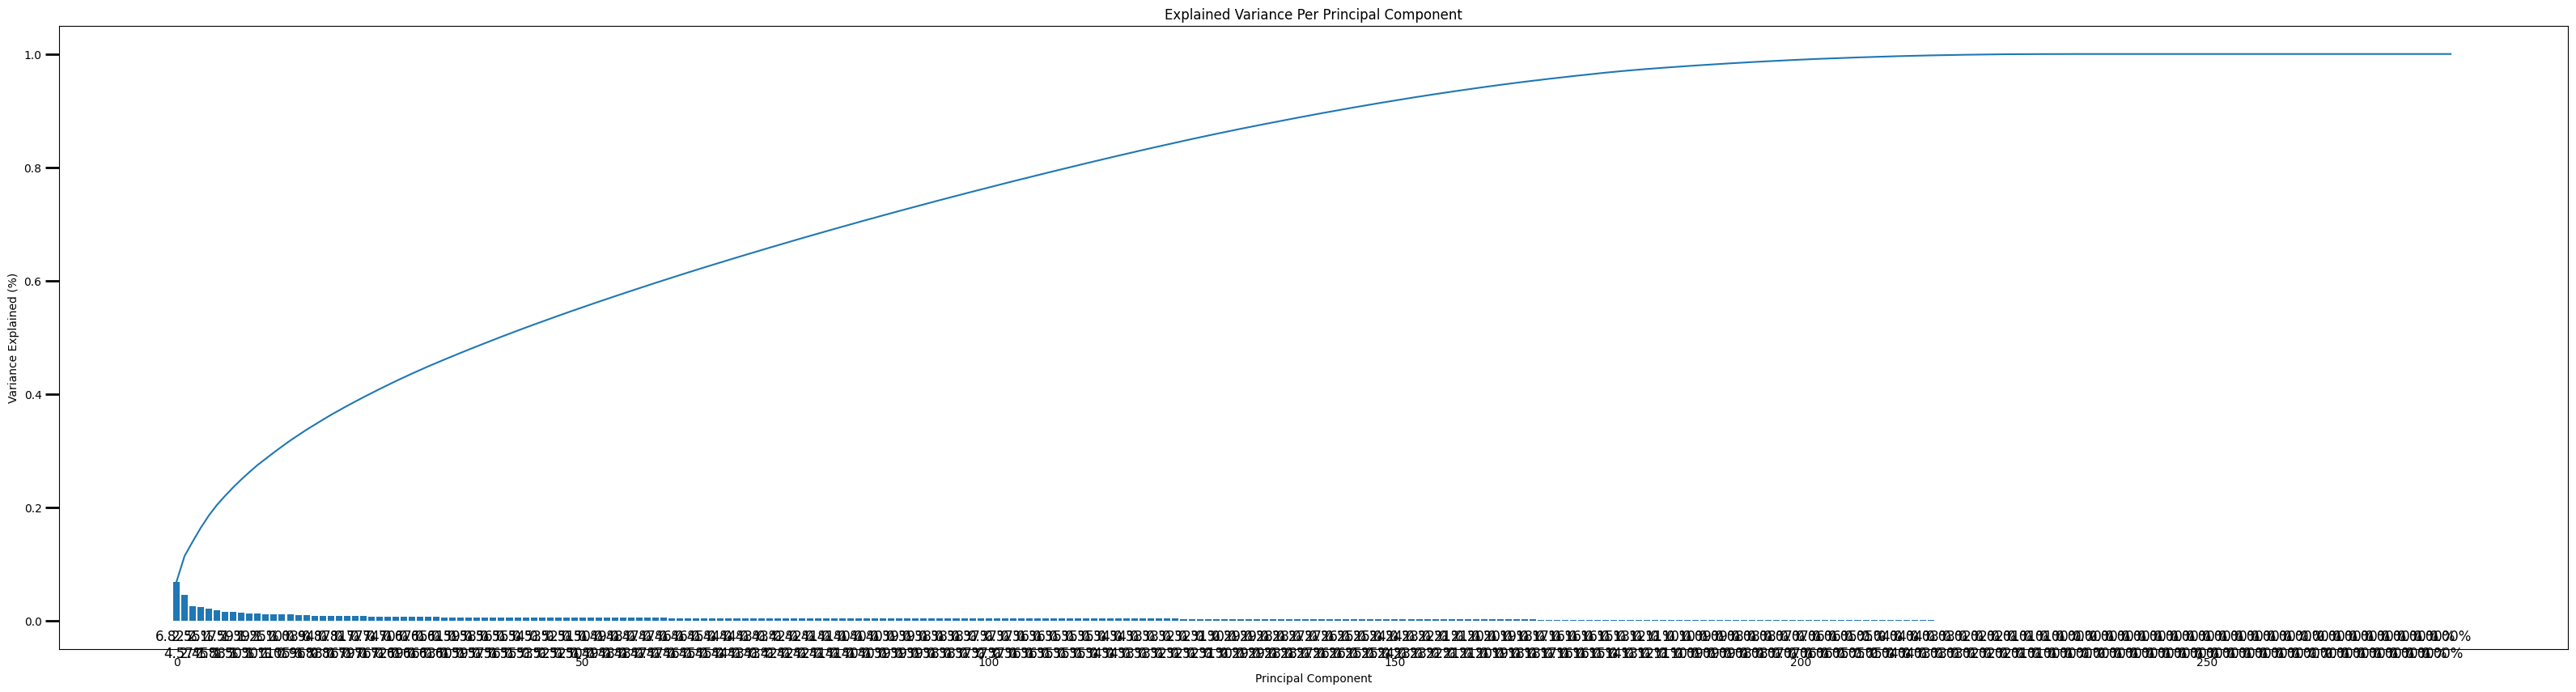

In [116]:
# Investigate the variance accounted for by each principal component.

from WGU_D499_P2_DCook.plots import scree_plot_v2

scree_plot_v2(azdias_general_demographics_main_pca)

In [117]:
from WGU_D499_P2_DCook.pca import explained_variance_component_check, do_pca_v2


num_components, final_pca, final_variance_df = explained_variance_component_check(
    dataframe=azdias_general_demographics_recombined_encoded_scaled,
    pca_function=do_pca_v2,
    explained_variance_threshold=0.90,
    plot= False
)

✅ Using 144 components, we can explain 90.08% of the variance in the data.


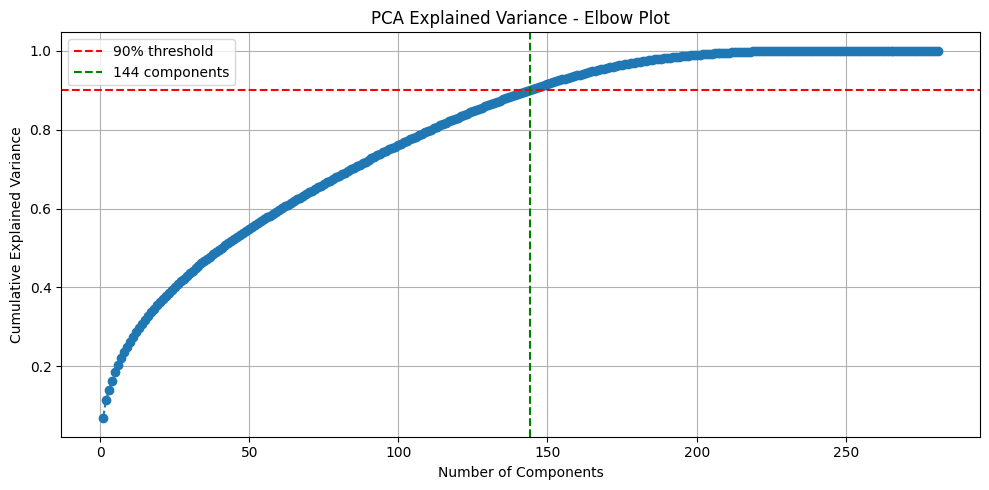

✅ Auto-selected 144 components explaining 90.07% of the variance.


In [118]:
from WGU_D499_P2_DCook.pca import auto_pick_pca_components


pca, n_components = auto_pick_pca_components(azdias_general_demographics_recombined_encoded_scaled, explained_variance_threshold=0.90)


In [119]:
# Re-apply PCA to the data while selecting for number of components to retain.

# Generating PCA Object with the number of components to retain.
pca = PCA(n_components=n_components)

# Fitting the PCA object to the scaled data.
pca.fit(azdias_general_demographics_recombined_encoded_scaled)

# Transforming the scaled data using the fitted PCA object.
pca_data = pca.transform(azdias_general_demographics_recombined_encoded_scaled)

In [120]:
pca_data.shape

(795469, 144)

### Discussion 2.2: Perform Dimensionality Reduction

In the section above, we move onto performing dimensionality reduction using Principle Component Analysis, PCA. 

I begin by importing PCA module from the decomposition sklearn library. After importing the library, I created a new PCA object by simply calling the object. With the PCA object instantiated, I fit the imputed and scaled dataset into the PCA object. After the PCA object has been fitted with the dataset, I then graph the output of the fitment using a screen plot and display the results. The results are slightly hard to determine but we are able make out that roughly after 130 items. 

Let's take a closer look out our PCA data to see if we can determine an optimal amount of components with more accuracy. I do this by running the performing a looped analysis on the PCA data by inputting a different number of PCA components for each iteration and recording the explained variance ratio output. My function is essentially performing a goal seek loop looking to obtain an output of 90% explained variance. My function completed with a result of 144 components, where we can explain 90.08% of the variance in the data. To ensure that my function is accurate, I work through several resources to attempt to generate an automated function to calculate and return the optimal number of PCA components. This function also determined that the optimal number of components is 144 components to explain 90.07% of the variance. 

We started with 281 features and after PCA we have narrowed that down to 144 components. 




### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [121]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

from WGU_D499_P2_DCook.pca import investigate_PC

investigate_PC(pca, 0, azdias_general_demographics_recombined_encoded_scaled.columns)

Principal Component 1
---------------

TOP 10 PRINCIPAL COMPONENTS 
        weight                                  name
101  0.172598             LP_STATUS_GROB_LOW_INCOME
25   0.163341                    HH_EINKOMMEN_SCORE
131  0.154558  LP_LEBENSPHASE_FEIN_WEALTH_STAGE_LOW
205  0.152763                        PLZ8_ANTG1_1.0
157  0.146194                       KBA05_ANTG1_0.0
190  0.140148                        PLZ8_ANTG3_3.0
6    0.138732                      FINANZ_HAUSBAUER
253  0.135276                          EWDICHTE_6.0
115  0.132280                     CI2015_WEALTH_5.0
193  0.129409                        PLZ8_ANTG4_2.0

 BOTTOM 10 PRINCIPAL COMPONENTS 
        weight                         name
27  -0.101238             MIN_GEBAEUDEJAHR
207 -0.102265               PLZ8_ANTG1_3.0
99  -0.104140    LP_STATUS_GROB_HOUSEOWNER
167 -0.106799              KBA05_ANTG3_0.0
32  -0.107580  PLZ8_BAUMAX_FAMILY_BUILDING
175 -0.108855               MOBI_REGIO_5.0
30  -0.113893          

In [122]:

# LP_STATUS_GROB_LOW_INCOME - Status and Wealth - Low Income
# HH_EINKOMMEN_SCORE - Household net income
# LP_LEBENSPHASE_FEIN_WEALTH_STAGE_LOW - Life Stage and Wealth - Low Wealth Stage
# PLZ8_ANTG1_1.0 - lower share of 1-2 family homes
# KBA05_ANTG1_0.0 - no 1-2 family homes
# PLZ8_ANTG3_3.0 - high share of 1-2 family homes
# FINANZ_HAUSBAUER - financial typology home ownership
# EWDICHTE_6.0 - homehold density per square kilometer, more than 999 households per square kilometer
# CI2015_WEALTH_5.0 - Wealth and life typology - elders in retirement
# PLZ8_ANTG4_2.0 - Average share of 1-2 family homes

# MIN_GEBAEUDEJAHR - first year building was mentioned 
# PLZ8_ANTG1_3.0 - average share of 1-2 family homes
# LP_STATUS_GROB_HOUSEOWNER - status and wealth - houseowner
# KBA05_ANTG3_0.0 - number of family house in microcell no 6-10 family homes
# PLZ8_BAUMAX_FAMILY_BUILDING - family building most common in plz8 region
# MOBI_REGIO_5.0 - very love movement patterns
# WOHNLAGE_RURAL - rural flag 
# KBA05_ANTG4_0.0 - Number of 10+ family houses in the microcell - no 10+ family homes
# PLZ8_ANTG4_0.0 - Number of 10+ family houses in the PLZ8 region - no 10+ family homes
# FINANZ_MINIMALIST - low financial interest financial typology



In [123]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

investigate_PC(pca, 1, azdias_general_demographics_recombined_encoded_scaled.columns)

Principal Component 2
---------------

TOP 10 PRINCIPAL COMPONENTS 
        weight                                        name
2    0.228005                               FINANZ_SPARER
5    0.212881                       FINANZ_UNAUFFAELLIGER
10   0.204743                                   SEMIO_REL
4    0.198411                              FINANZ_ANLEGER
108  0.196639        PRAEGENDE_JUGENDJAHRE_GENERATION_6.0
21   0.192880                                 SEMIO_TRADV
20   0.190007                               SEMIO_PFLICHT
16   0.159385                                   SEMIO_RAT
124  0.154115  LP_LEBENSPHASE_FEIN_LIFE_STAGE_YOUNGER_AGE
15   0.148556                                  SEMIO_KULT

 BOTTOM 10 PRINCIPAL COMPONENTS 
        weight                                           name
1   -0.109802                              FINANZ_MINIMALIST
105 -0.112403           PRAEGENDE_JUGENDJAHRE_GENERATION_3.0
121 -0.116043    LP_LEBENSPHASE_FEIN_LIFE_STAGE_ADVANCED_AGE
123 -0.131420 

In [124]:

# FINANZ_SPARER - financial typology money saver
# FINANZ_UNAUFFAELLIGER - financial typology inconspicuous
# SEMIO_REL - personality typology religious
# FINANZ_ANLEGER - financial typology investor
# PRAEGENDE_JUGENDJAHRE_GENERATION_6.0 - dominating movement, generation - 60s
# SEMIO_TRADV - personality typology traditional-minded
# SEMIO_PFLICHT - personality typology dutiful
# SEMIO_RAT - personality typology rational
# LP_LEBENSPHASE_FEIN_LIFE_STAGE_YOUNGER_AGE - Life stage, fine scale - life stage younger age
# SEMIO_KULT - personality typology cultural-minded

# FINANZ_MINIMALIST - financial typology low financial interest minimalist
# PRAEGENDE_JUGENDJAHRE_GENERATION_3.0 - dominating movement, generation - 30s
# LP_LEBENSPHASE_FEIN_LIFE_STAGE_ADVANCED_AGE - Life stage, fine scale - life stage advanced age
# LP_LEBENSPHASE_FEIN_LIFE_STAGE_RETIREMENT_AGE - life stage, fine scale - life stage retirement age
# RETOURTYP_BK_S_5.0 - return type determined minimal-returner
# SEMIO_LUST - personality typology sensual-minded
# SEMIO_ERL - personality typology event-oriented
# ALTERSKATEGORIE_GROB_4.0 - Estimated age based on given name analysis, greater than 60 years old
# ZABEOTYP_FAIR_SUPPLIED - energy consumption typology fair supplied
# FINANZ_VORSORGER - financial typology be prepared

In [125]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

investigate_PC(pca, 2, azdias_general_demographics_recombined_encoded_scaled.columns)

Principal Component 3
---------------

TOP 10 PRINCIPAL COMPONENTS 
        weight                                name
0    0.226806                           ANREDE_KZ
109  0.194978  PRAEGENDE_JUGENDJAHRE_MOVEMENT_1.0
27   0.192156                    MIN_GEBAEUDEJAHR
17   0.190832                          SEMIO_KRIT
19   0.189885                          SEMIO_KAEM
14   0.160688                           SEMIO_ERL
30   0.150706                      WOHNLAGE_RURAL
18   0.148954                           SEMIO_DOM
4    0.134634                      FINANZ_ANLEGER
248  0.133457                        EWDICHTE_1.0

 BOTTOM 10 PRINCIPAL COMPONENTS 
        weight                                  name
85  -0.130709            FINANZTYP_INVESTOR_ANLEGER
132 -0.148831  LP_LEBENSPHASE_FEIN_WEALTH_STAGE_TOP
31  -0.157055                WOHNLAGE_NEIGHBOURHOOD
102 -0.159489             LP_STATUS_GROB_TOP_EARNER
15  -0.171970                            SEMIO_KULT
9   -0.177735                     

In [126]:

# ANREDE_KZ - gender
# PRAEGENDE_JUGENDJAHRE_MOVEMENT_1.0 - dominating movement - movement - mainstream
# MIN_GEBAEUDEJAHR - First year building was mentioned in the database
# SEMIO_KRIT - personality typology critical-minded
# SEMIO_KAEM - personality typology combative attitude
# SEMIO_ERL - personality typology event-oriented
# WOHNLAGE_RURAL - rural building flag
# SEMIO_DOM - personality typology dominant-minded 
# FINANZ_ANLEGER - financial typology investor
# EWDICHTE_1.0 - Density of households per square kilometer - ess than 34 households per km^2


# FINANZTYP_INVESTOR_ANLEGER - Most descriptive financial type for individual, investor
# LP_LEBENSPHASE_FEIN_WEALTH_STAGE_TOP Life stage, fine scale - wealth stage - top wealth stage
# WOHNLAGE_NEIGHBOURHOOD - neighbourhood flag 
# LP_STATUS_GROB_TOP_EARNER - Social status, rough scale, wealth - top earner
# SEMIO_KULT - personality typology cultural-minded
# SEMIO_FAM - personality typology family-oriented
# SEMIO_SOZ - personality typology social-minded
# GREEN_AVANTGARDE - Membership in environmental sustainability as part of youth
# PRAEGENDE_JUGENDJAHRE_MOVEMENT_2.0 - dominating movement - movement - avantgarde
# SEMIO_VERT - personality typology environmentally-minded

### Discussion 2.3: Interpret Principal Components

To investigate our first few principal components, I pulled a function from our course material to assist me in this endeavor. This function creates a map containing the weights of the features that are associated with the PCA component. We can obtain the top ten positive and the top ten negative features for the component. This is very meaningful for us, as we can 

For the first PCA component, we can see that the component is positively influenced by low income, higher density urban living, and low-to-moderate wealth stages. While the component is negatively influenced by wealthier, more rural or stable living situations. 

For the second PCA component, we can see that the component is positively influenced by younger consumers with more traditional financial habits and personality values, like religion. While the component is negatively influenced by older, more hedonistic, minimal return-oriented consumers with low financial involvement. 

For the third PCA component, we can see that the component is positively influenced by rural or low-density living, people who have a more dominant, critical, or combative/responsive/reactive mindset and are typically aligned to the mainstream generation. While the component is negatively influenced by more family and environment focused consumers who are wealthy, socially active, and cultured engaged and typically more aligned to progressive, avant-garde, or younger generations. 




## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [127]:
from WGU_D499_P2_DCook.clustering import get_Kmeans_scores

model_scores, cluster_range = get_Kmeans_scores(pca_data, (2, 30), 2)

Performing K-Means clustering
Given range min:2, max:30, step:2

Training for n_clusters:  2
Done! Score:  189572741.16572174

Training for n_clusters:  4
Done! Score:  180985515.99788263

Training for n_clusters:  6
Done! Score:  175595227.6966315

Training for n_clusters:  8
Done! Score:  171895864.43024024

Training for n_clusters:  10
Done! Score:  169853735.35105383

Training for n_clusters:  12
Done! Score:  168064164.93299848

Training for n_clusters:  14
Done! Score:  166148025.3513168

Training for n_clusters:  16
Done! Score:  165097382.79506058

Training for n_clusters:  18
Done! Score:  163803230.20756263

Training for n_clusters:  20
Done! Score:  162236564.7281521

Training for n_clusters:  22
Done! Score:  160783315.05362338

Training for n_clusters:  24
Done! Score:  160184775.02151495

Training for n_clusters:  26
Done! Score:  158859686.6333647

Training for n_clusters:  28
Done! Score:  157963918.51438046

Training for n_clusters:  30
Done! Score:  157268611.68125778

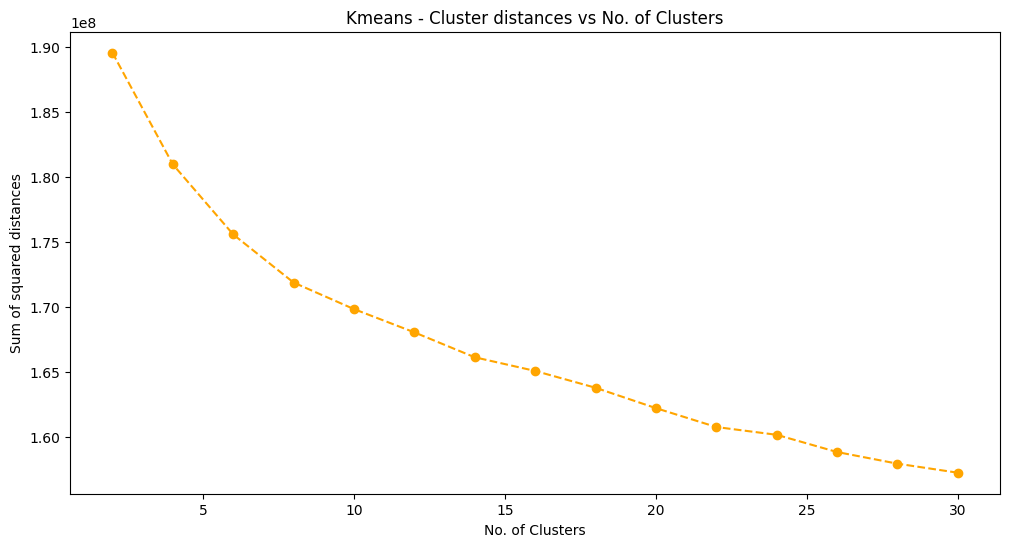

In [128]:
from WGU_D499_P2_DCook.plots import plot_elbow

plot_elbow(model_scores, cluster_range)

In [129]:
from WGU_D499_P2_DCook.clustering import find_optimal_k_knee


optimal_k = find_optimal_k_knee(model_scores, cluster_range)



Optimal number of clusters according to KneeLocator: 8


In [130]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = optimal_k).fit(pca_data)
population_labels = kmeans.predict(pca_data)

### Discussion 3.1: Apply Clustering to General Population

In our next step, we start performing clustering to group our components into groups of similar items. 

To do this, we will start by importing the Kmeans module from the clusters library of sklearn. Once imported the module, we will create an empty list to hold our kmeans score and a second list to hold the number of clusters we would like to check. Then using a loop, we loop through the clusters list items applying the current iterations integer to our kmeans model. As we create our kmeans model with that iterations number of clusters, we then fit the pca data to the model, then calculate the absolute value of the kmeans score and append it to our model score list. We repeat this process until we loop through all of our cluster list item. This is all done on the clustering.py file where I have several versions of this function stored. The function we will use is my second one that has more formatted printing and returns our scores and the range values generated during the loop. 

Once this has been completed, we can then review the values list by calling the list to be printed. Otherwise, we can go ahead and pass the list into our plotting function to plot an elbow graph of the values. Doing so, we are able to see that roughly around 8 that our values start to change very slightly. 

I have found another library called the Knee Locator which performs kmeans analysis and can locate the optimal k value. To confirm my results, I installed, imported, and created a function to run the knee locator module, which found the optimal k value is 8, as well. 




### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [131]:
# Load in the customer demographics data.
customers = load_csv_with_parameters("Udacity_CUSTOMERS_Subset.csv", sep=";", na_values=np.nan)

2025-06-17 19:34:00.822 | INFO     | WGU_D499_P2_DCook.dataset:load_csv_with_parameters:68 - Loaded dataset from D:\WGU\D499\WGU_D499_P2_DCook\data\raw\Udacity_CUSTOMERS_Subset.csv with 191652 rows and 85 columns.


In [132]:
customers.shape

(191652, 85)

In [133]:
FT_ops = [
    {"type": "map", "params": {
        "column": "OST_WEST_KZ",
        "mappings": [{"O": 1, "W": 0}, {"W": 1, "O": 0}],
        "new_names": ["WEST","EAST"],
        "pre_fill_na": True,
        "fill_na_value": '',
        "create_new": True,
        "keep_index": True,
        "keep_original": False,
        "encode_column": False
    }},
    {"type": "map", "params": {
        "column": "LP_FAMILIE_GROB",
        "mappings": [{1: 'single', 2: 'couple', 3: 'single_parent', 4: 'family', 5: 'multihousehold'}],
        "new_names": [],
        "pre_fill_na": False,
        "fill_na_value": None,
        "create_new": False,
        "keep_index": False,
        "keep_original": True,
        "encode_column": True
    }},
    {"type": "map", "params": { 
        "column": "LP_STATUS_GROB",
        "mappings": [{1: 'low_income', 2: 'avg_income', 3: 'independant', 4: 'houseowner', 5: 'top_earner'}],
        "new_names": [],
        "pre_fill_na": False,
        "fill_na_value": None,
        "create_new": False,
        "keep_index": False,
        "keep_original": True,
        "encode_column": True
    }},
    {"type": "map", "params": { 
        "column": "GFK_URLAUBERTYP",
        "mappings": [{1: 'event_travelers', 2: 'family_oriented_vacationists', 3: 'winter_sportspeople', 4: 'culture_lovers', 5: 'nature_fans', 6: 'hiker', 7: 'golden_agers', 8: 'homeland_connected_travelers', 9: 'package_tour_travelers', 10: 'connoisseurs', 11: 'active_families', 12: 'active_singles', 13: 'without_vacation'}],
        "new_names": [],
        "pre_fill_na": False,
        "fill_na_value": None,
        "create_new": False,
        "keep_index": False,
        "keep_original": True,
        "encode_column": True
    }},
    {"type": "map", "params": { 
        "column": "CJT_GESAMTTYP",
        "mappings": [{1: 'ad_consumption_minimalist', 2: 'ad_consumption_traditionalist', 3: 'ad_interested_store_shopper', 4: 'ad_interested_online_shopper', 5: 'ad_cross_channel_enthusiast', 6: 'ad_enthusiast_limited_cross_channel'}],
        "new_names": [],
        "pre_fill_na": False,
        "fill_na_value": None,
        "create_new": False,
        "keep_index": False,
        "keep_original": True,
        "encode_column": True
    }},
    {"type": "map", "params": { 
        "column": "SHOPPER_TYP",
        "mappings": [{0: 'external_supplied_hedonists',1: 'shopping_stressed',2: 'family_shopper', 3: 'demanding_shopper'}],
        "new_names": [],
        "pre_fill_na": False,
        "fill_na_value": None,
        "create_new": False,
        "keep_index": False,
        "keep_original": True,
        "encode_column": True
    }},
    {"type": "map", "params": { 
        "column": "NATIONALITAET_KZ",
        "mappings": [{1: 'german_sounding', 2: 'foreign_sounding', 3: 'assimilated_names'}],
        "new_names": [],
        "pre_fill_na": False,
        "fill_na_value": None,
        "create_new": False,
        "keep_index": False,
        "keep_original": True,
        "encode_column": True
    }},
    {"type": "map", "params": { 
        "column": "FINANZTYP",
        "mappings": [{1: 'low_financial_interest_minimalist', 2: 'money_saver_sparer', 3: 'home_ownership_hausbauer', 4: 'be_prepared_vorsorger', 5: 'investor_anleger', 6: 'inconspicuous_unauffaelliger'}],
        "new_names": [],
        "pre_fill_na": False,
        "fill_na_value": None,
        "create_new": False,
        "keep_index": False,
        "keep_original": True,
        "encode_column": True
    }},
    {"type": "map", "params": { 
        "column": "ZABEOTYP",
        "mappings": [{1: 'green', 2: 'smart', 3: 'fair_supplied', 4: 'price_driven', 5: 'seeking_orientation', 6: 'indifferent'}],
        "new_names": [],
        "pre_fill_na": False,
        "fill_na_value": None,
        "create_new": False,
        "keep_index": False,
        "keep_original": True,
        "encode_column": True
    }},
    {"type": "map", "params": { 
        "column": "GEBAEUDETYP",
        "mappings": [{1: 'residential_building', 2: 'residential_building_unknown_household', 3: 'mixed_residential_company_building', 4: 'mixed_building_unknown_household_company', 5: 'company_building_unknown_company', 6: 'mixed_building_unknown_household', 7: 'company_building', 8: 'mixed_building_unknown_company'}],
        "new_names": [],
        "pre_fill_na": False,
        "fill_na_value": None,
        "create_new": False,
        "keep_index": False,
        "keep_original": True,
        "encode_column": True
    }},
    {"type": "map", "params": { 
        "column": "PRAEGENDE_JUGENDJAHRE",
        "mappings": [{1: 1, 2: 2, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5, 14: 6, 15: 6}, 
                     {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1, 2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2}],
        "new_names": ["GENERATION", "MOVEMENT"],
        "pre_fill_na": False,
        "fill_na_value": None,
        "create_new": True,
        "keep_index": True,
        "keep_original": False,
        "encode_column": True
    }},   
    {"type": "map", "params": { 
        "column": "LP_LEBENSPHASE_FEIN",
        "mappings": [{1: 'younger_age', 2: 'middle_age', 3: 'younger_age', 4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age', 7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age', 10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age', 13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age', 16: 'advanced_age', 17: 'middle_age', 18: 'younger_age', 19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age', 22: 'middle_age', 23: 'middle_age', 24: 'middle_age', 25: 'middle_age', 26: 'middle_age', 27: 'middle_age', 28: 'middle_age', 29: 'younger_age', 30: 'younger_age', 31: 'advanced_age', 32: 'advanced_age',  33: 'younger_age', 34: 'younger_age', 35: 'younger_age', 36: 'advanced_age', 37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age', 40: 'retirement_age'}, 
                     {1: 'single', 2: 'single', 3: 'single', 4: 'single', 5: 'single', 6: 'single', 7: 'single', 8: 'single', 9: 'single', 10: 'single', 11: 'single', 12: 'single', 13: 'single', 14: 'couples', 15: 'couples', 16: 'couples', 17: 'couples', 18: 'couples', 19: 'couples', 20: 'couples', 21: 'single_parent', 22: 'single_parent', 23: 'single_parent', 24: 'family', 25: 'family', 26: 'family', 27: 'family', 28: 'family', 29: 'multihousehold', 30: 'multihousehold', 31: 'multihousehold', 32: 'multihousehold', 33: 'multihousehold', 34: 'multihousehold', 35: 'multihousehold', 36: 'multihousehold', 37: 'multihousehold', 38: 'multihousehold', 39: 'multihousehold', 40: 'multihousehold'}, 
                     {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low', 7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average', 12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average', 17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low', 22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average', 27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low', 32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average', 37: 'average', 38: 'average', 39: 'top', 40: 'top'}],
        "new_names": ["LIFE_STAGE", "FAMILY_STAGE", "WEALTH_STAGE"],
        "pre_fill_na": False,
        "fill_na_value": None,
        "create_new": True,
        "keep_index": True,
        "keep_original": False,
        "encode_column": True
    }},   
    {"type": "map", "params": { 
        "column": "WOHNLAGE",
        "mappings": [{1:0, 2:0, 3:0, 4:0, 5:0, 7:1, 8:1}, 
                     {1:1, 2:1, 3:1, 4:1, 5:1, 7:0, 8:0}],
        "new_names": ["RURAL", "NEIGHBOURHOOD"],
        "pre_fill_na": True,
        "fill_na_value": 0,
        "create_new": True,
        "keep_index": True,
        "keep_original": False,
        "encode_column": False
    }},     
    {"type": "map", "params": { 
        "column": "PLZ8_BAUMAX",
        "mappings": [{1: 1, 2: 1, 3: 1, 4: 1, 5: 0}, 
                     {1: 0, 2: 0, 3: 0, 4: 0, 5: 1}],
        "new_names": ["FAMILY_BUILDING", "BUSINESS_BUILDING"],
        "pre_fill_na": True,
        "fill_na_value": 0,
        "create_new": True,
        "keep_index": True,
        "keep_original": False,
        "encode_column": False
    }},   
    {"type": "replace", "params": {
        "column": "VERS_TYP",
        "replacements": {1: 0, 2: 1}
    }},
    {"type": "replace", "params": {
        "column": "ANREDE_KZ",
        "replacements": {1: 0, 2: 1}
    }},
    {"type": "convert_data_type", "params": {
        "column": "PRAEGENDE_JUGENDJAHRE_GENERATION",
        "data_type": "category"
    }},    
    {"type": "convert_data_type", "params": {
        "column": "PRAEGENDE_JUGENDJAHRE_MOVEMENT",
        "data_type": "category"
    }},
    {"type": "convert_data_type", "params": {
        "column": "LP_LEBENSPHASE_FEIN_LIFE_STAGE",
        "data_type": "category"
    }},
    {"type": "convert_data_type", "params": {
        "column": "LP_LEBENSPHASE_FEIN_FAMILY_STAGE",
        "data_type": "category"
    }},
    {"type": "convert_data_type", "params": {
        "column": "LP_LEBENSPHASE_FEIN_WEALTH_STAGE",
        "data_type": "category"
    }},
]

D:\WGU\D499\WGU_D499_P2_DCook\WGU_D499_P2_DCook\utils.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main_df[column_name].replace(to_replace=item, value=replace_with, inplace=True)


AGER_TYP: 0 --> 96738 nulls after converting 96738 values
ALTERSKATEGORIE_GROB: 0 --> 240 nulls after converting 240 values
ANREDE_KZ: 0 --> 0 nulls after converting 0 values
CJT_GESAMTTYP: 3213 --> 3213 nulls after converting 0 values
FINANZ_MINIMALIST: 0 --> 0 nulls after converting 0 values
FINANZ_SPARER: 0 --> 0 nulls after converting 0 values
FINANZ_VORSORGER: 0 --> 0 nulls after converting 0 values
FINANZ_ANLEGER: 0 --> 0 nulls after converting 0 values
FINANZ_UNAUFFAELLIGER: 0 --> 0 nulls after converting 0 values
FINANZ_HAUSBAUER: 0 --> 0 nulls after converting 0 values
FINANZTYP: 0 --> 0 nulls after converting 0 values
GEBURTSJAHR: 0 --> 93024 nulls after converting 93024 values
GFK_URLAUBERTYP: 3213 --> 3213 nulls after converting 0 values
GREEN_AVANTGARDE: 0 --> 0 nulls after converting 0 values
HEALTH_TYP: 0 --> 48990 nulls after converting 48990 values
LP_LEBENSPHASE_FEIN: 3213 --> 51053 nulls after converting 47840 values
LP_LEBENSPHASE_GROB: 3213 --> 50941 nulls after co

D:\WGU\D499\WGU_D499_P2_DCook\WGU_D499_P2_DCook\utils.py:143: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  match_count = main_df[column_name].value_counts().get(item, 0)
D:\WGU\D499\WGU_D499_P2_DCook\WGU_D499_P2_DCook\utils.py:149: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main_df[column_name].replace(to_replace=item, value=replace_with,

CAMEO_INTL_2015: 50428 --> 50554 nulls after converting 126 values
KBA05_ANTG1: 55980 --> 55980 nulls after converting 0 values
KBA05_ANTG2: 55980 --> 55980 nulls after converting 0 values
KBA05_ANTG3: 55980 --> 55980 nulls after converting 0 values
KBA05_ANTG4: 55980 --> 55980 nulls after converting 0 values
KBA05_BAUMAX: 55980 --> 109535 nulls after converting 53555 values
KBA05_GBZ: 55980 --> 55982 nulls after converting 2 values
BALLRAUM: 49959 --> 49959 nulls after converting 0 values
EWDICHTE: 49959 --> 49959 nulls after converting 0 values
INNENSTADT: 49959 --> 49959 nulls after converting 0 values
GEBAEUDETYP_RASTER: 49927 --> 49927 nulls after converting 0 values
KKK: 54260 --> 60064 nulls after converting 5804 values
MOBI_REGIO: 55980 --> 55980 nulls after converting 0 values
ONLINE_AFFINITAET: 3213 --> 3213 nulls after converting 0 values
REGIOTYP: 54260 --> 60064 nulls after converting 5804 values
KBA13_ANZAHL_PKW: 51281 --> 51281 nulls after converting 0 values
PLZ8_ANTG1:

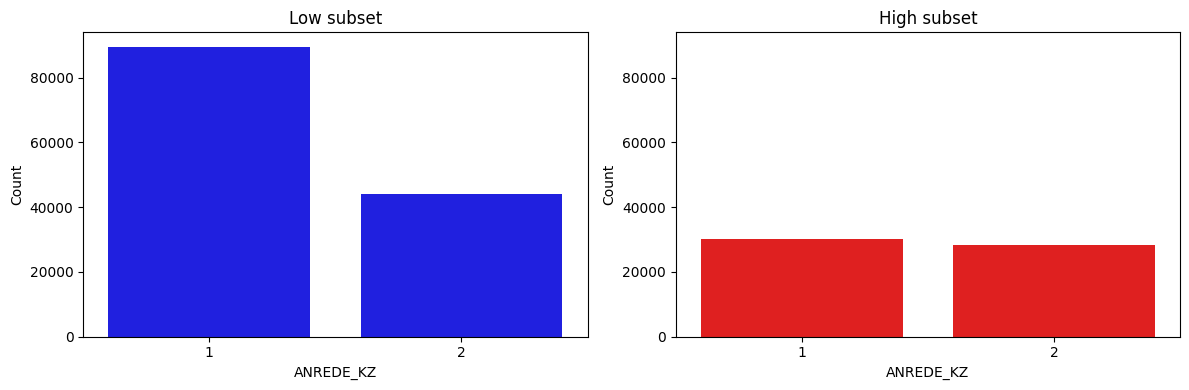

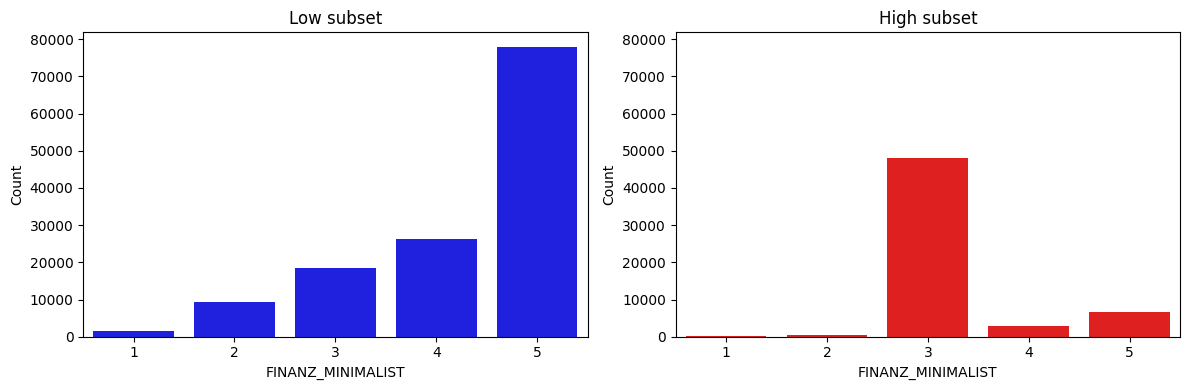

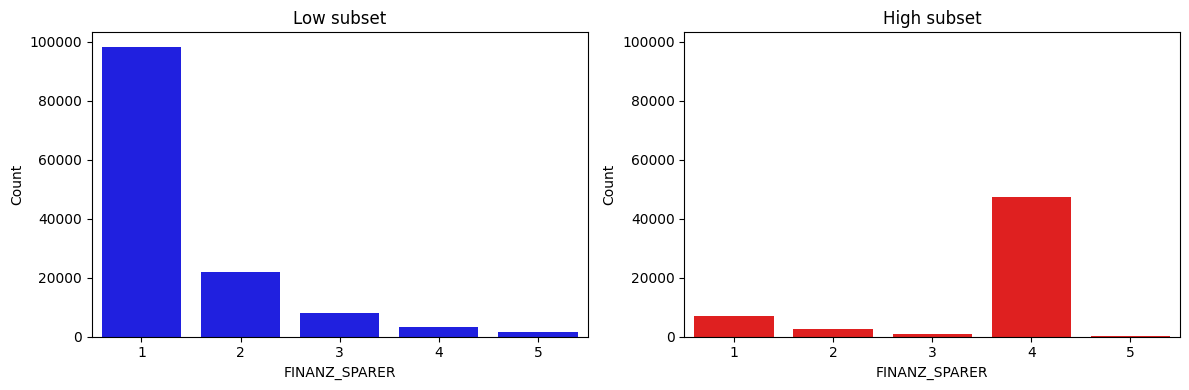

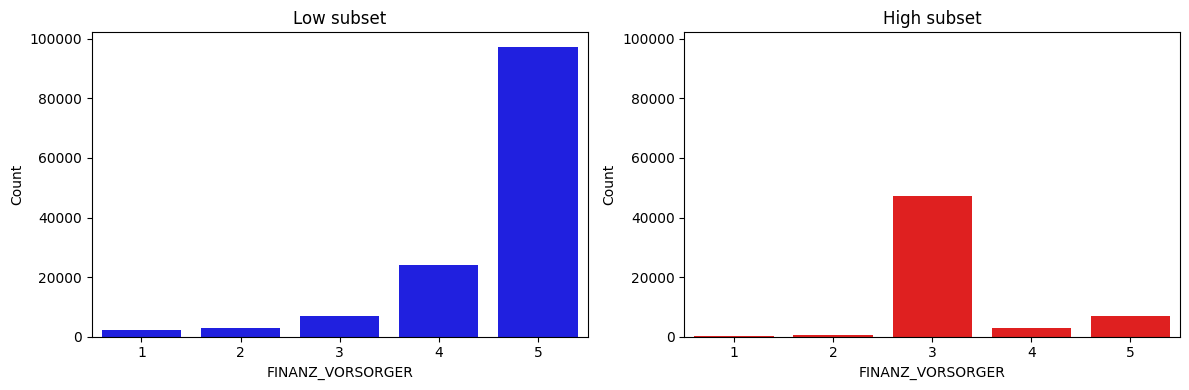

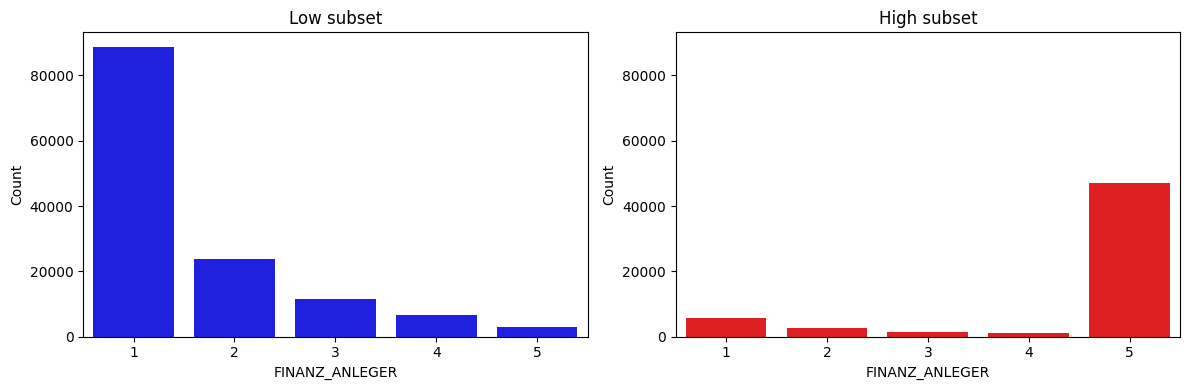

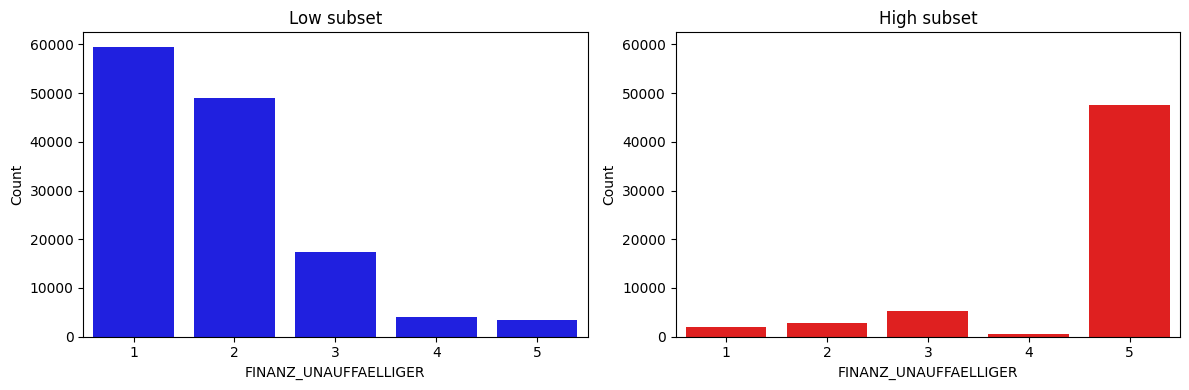

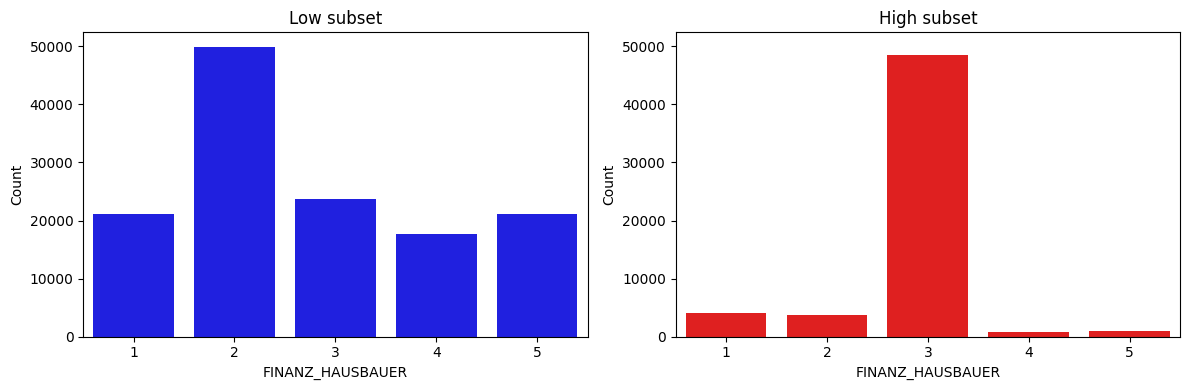

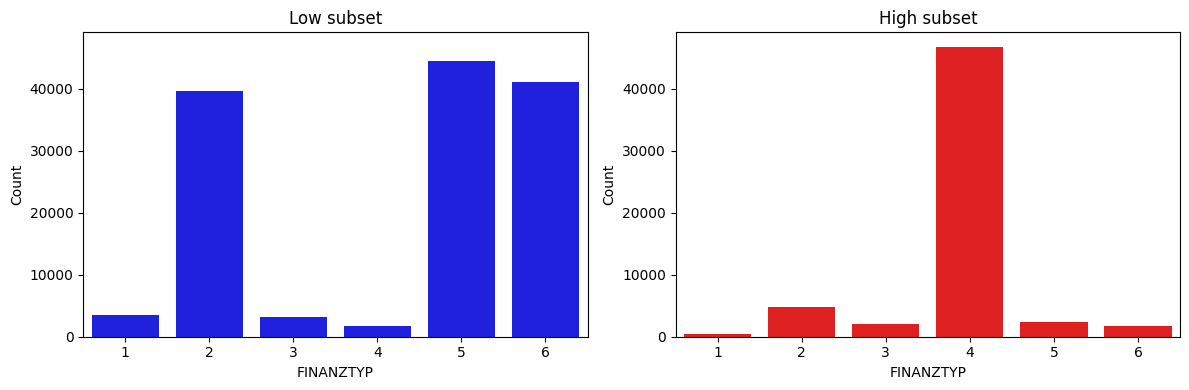

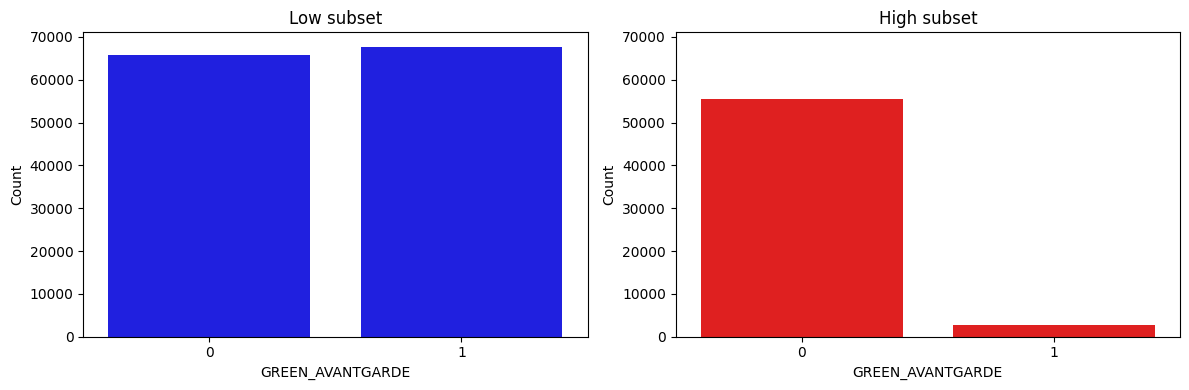

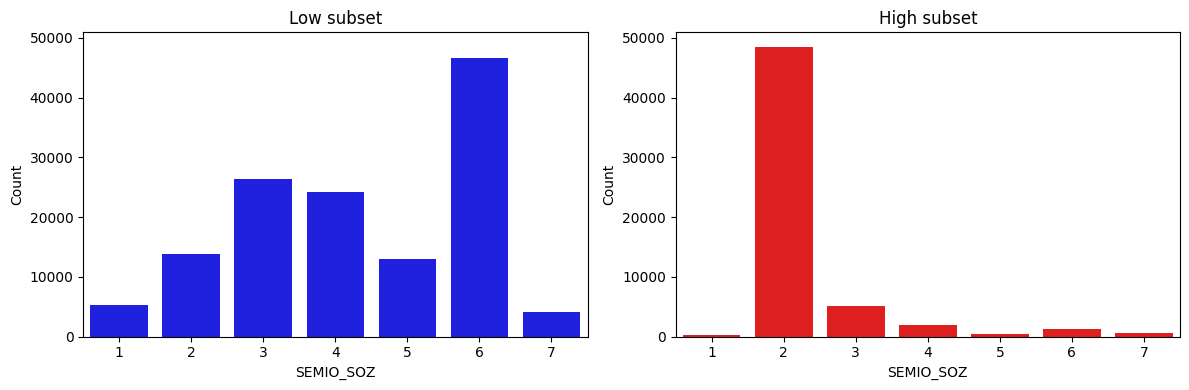

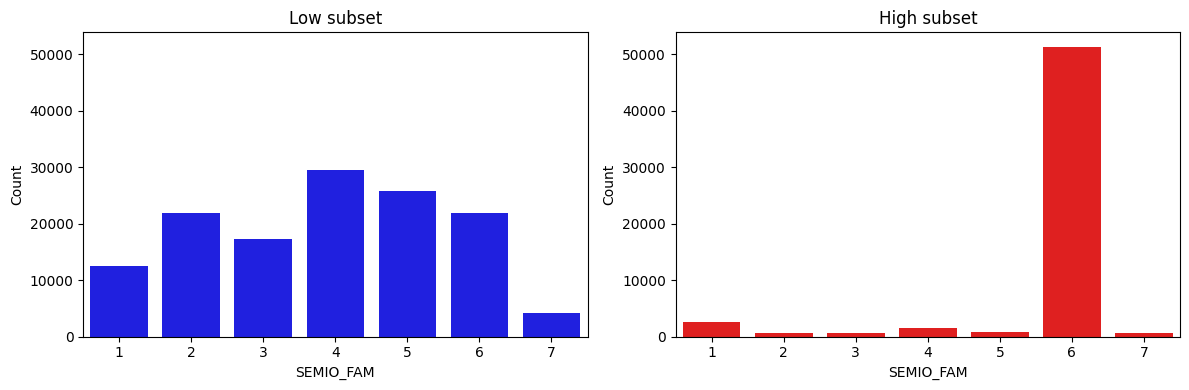

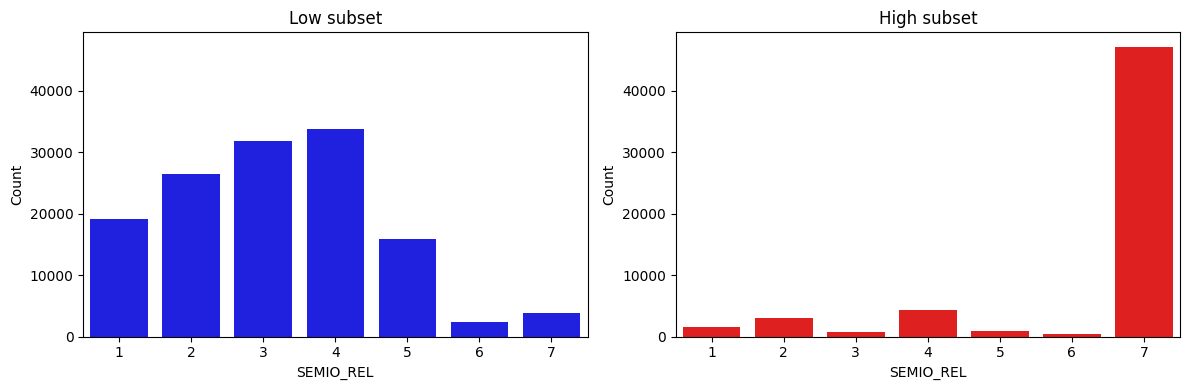

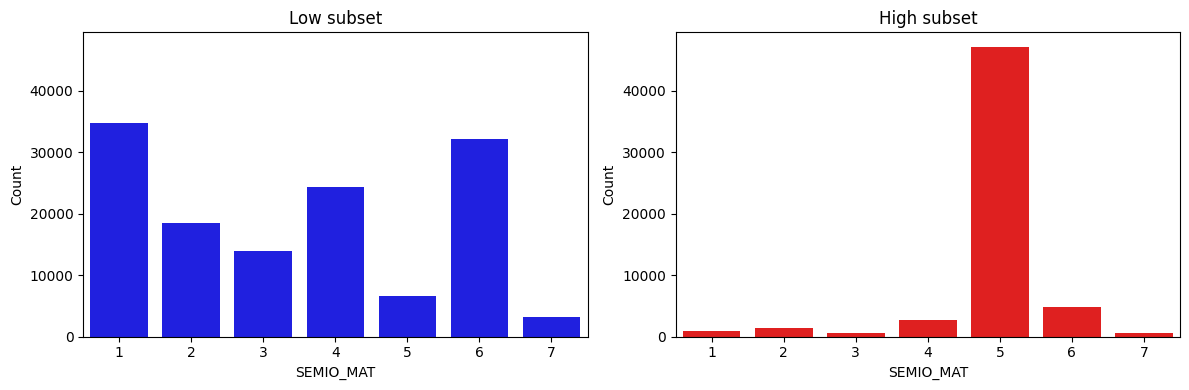

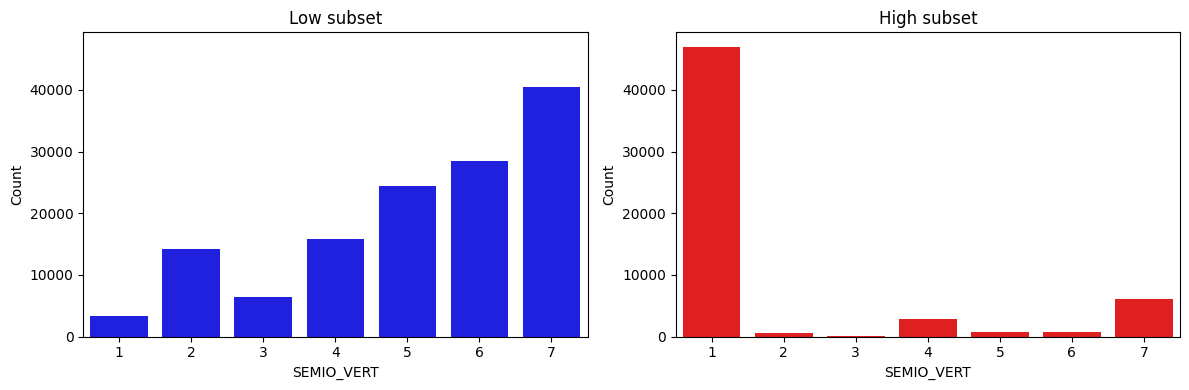

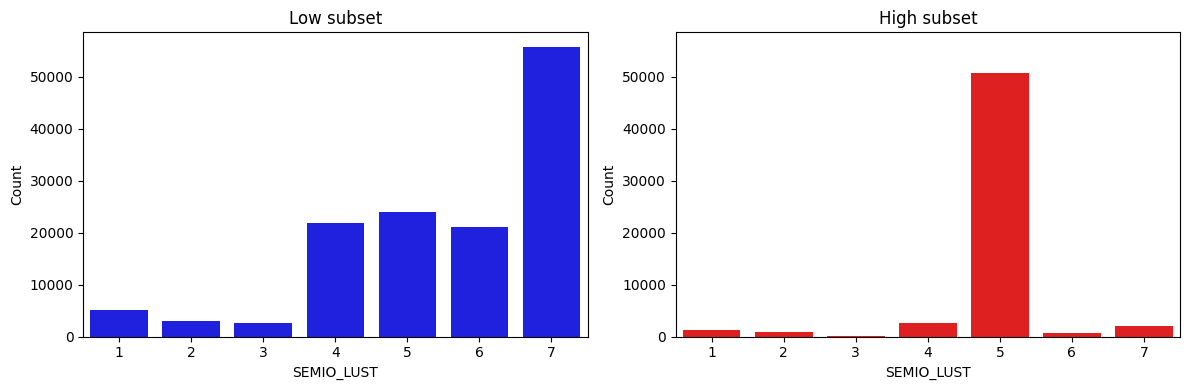

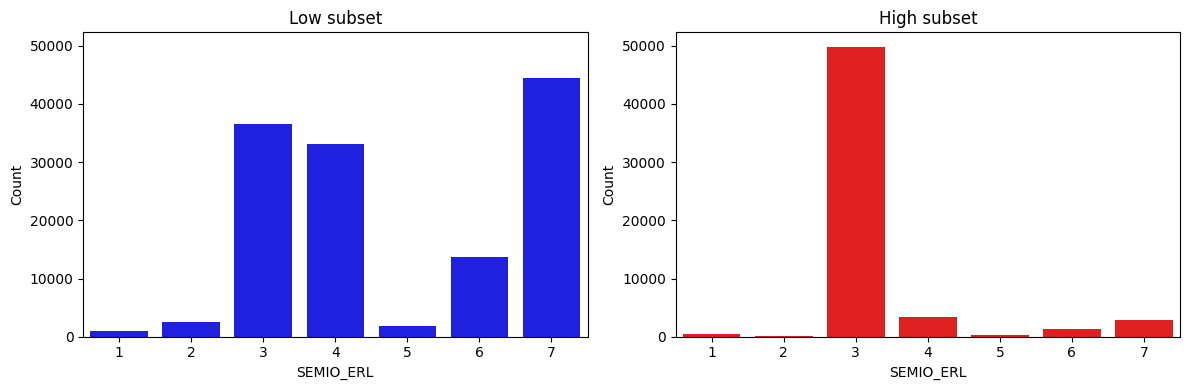

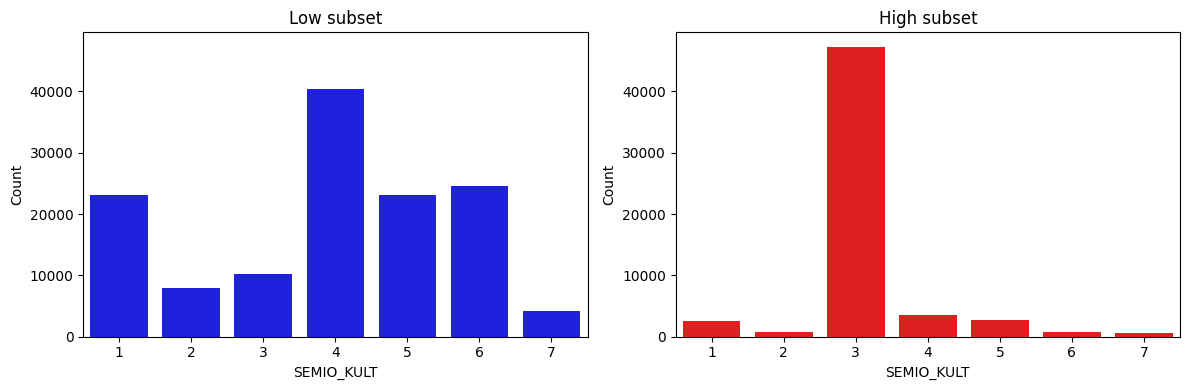

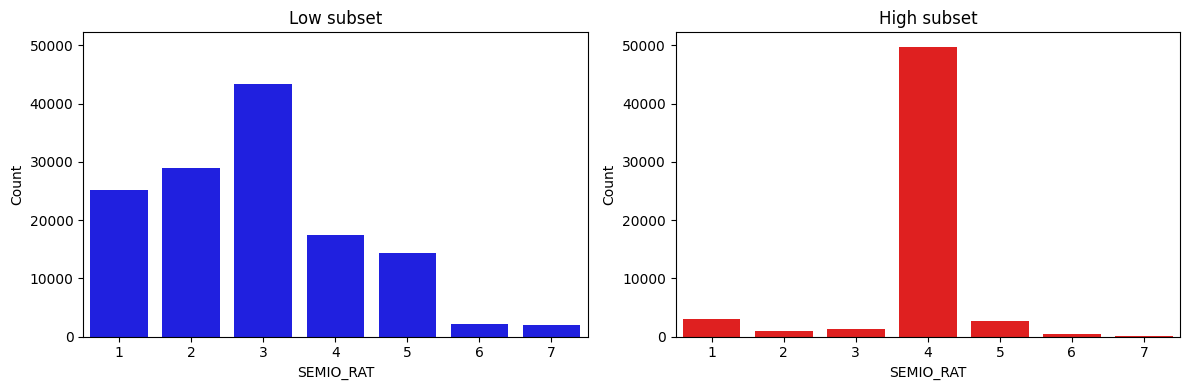

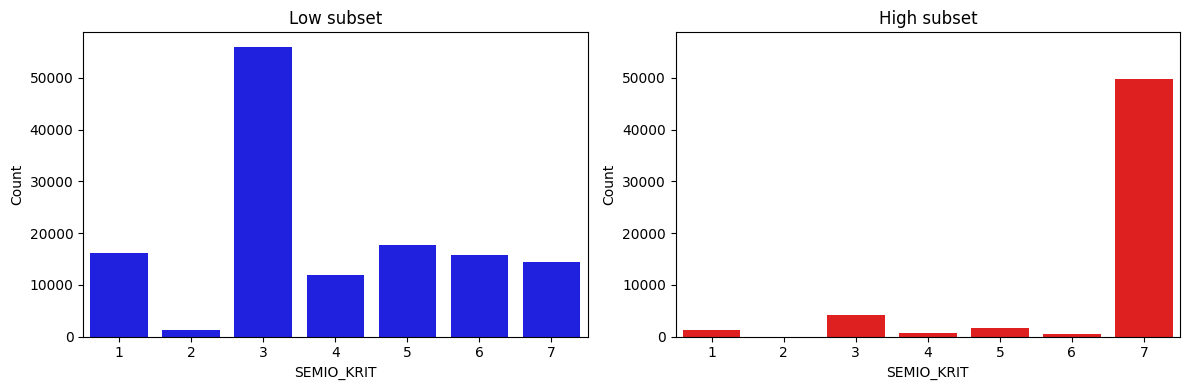

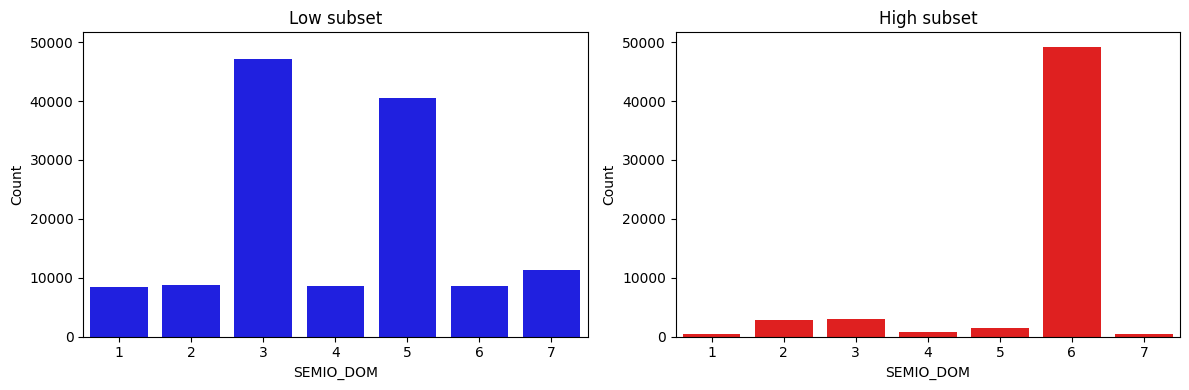

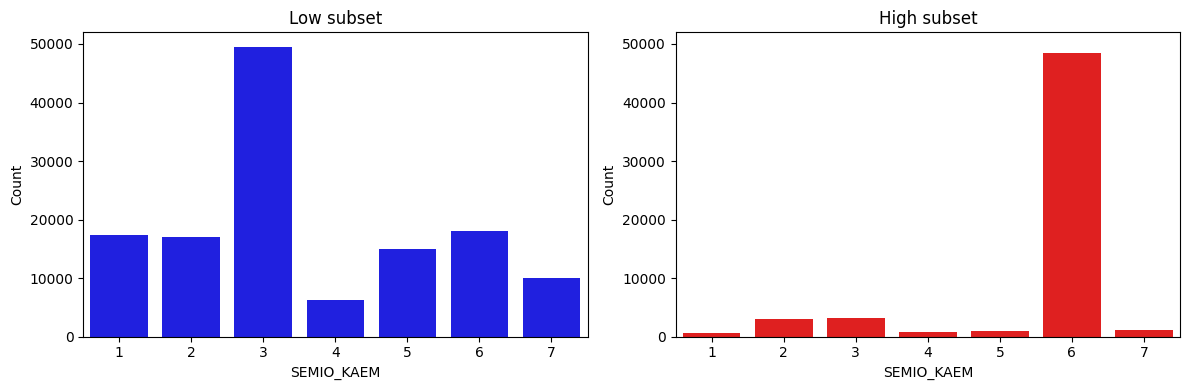

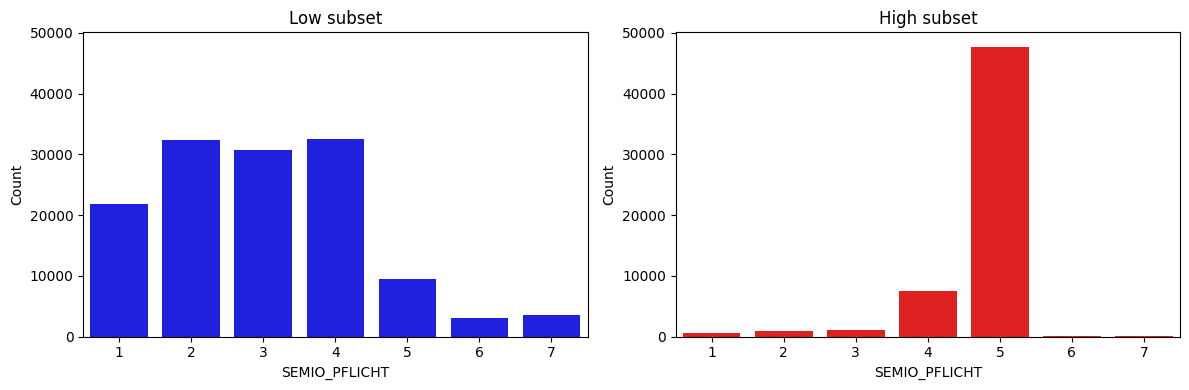

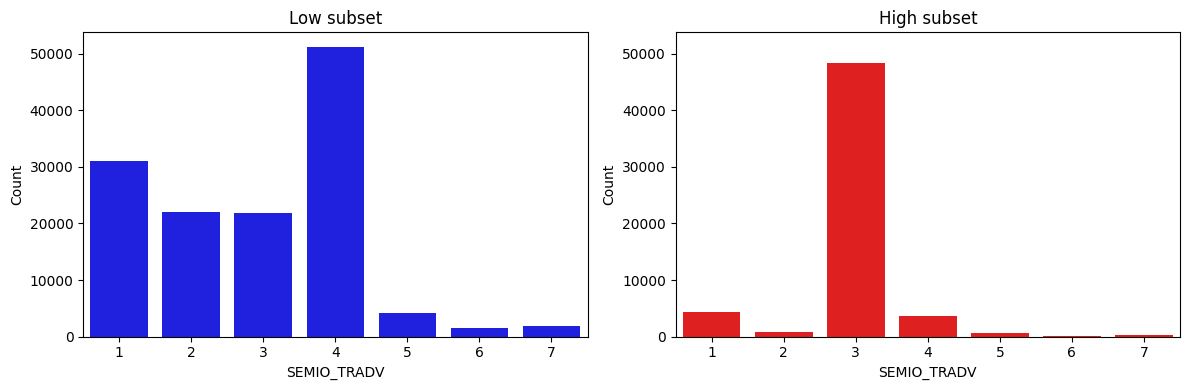

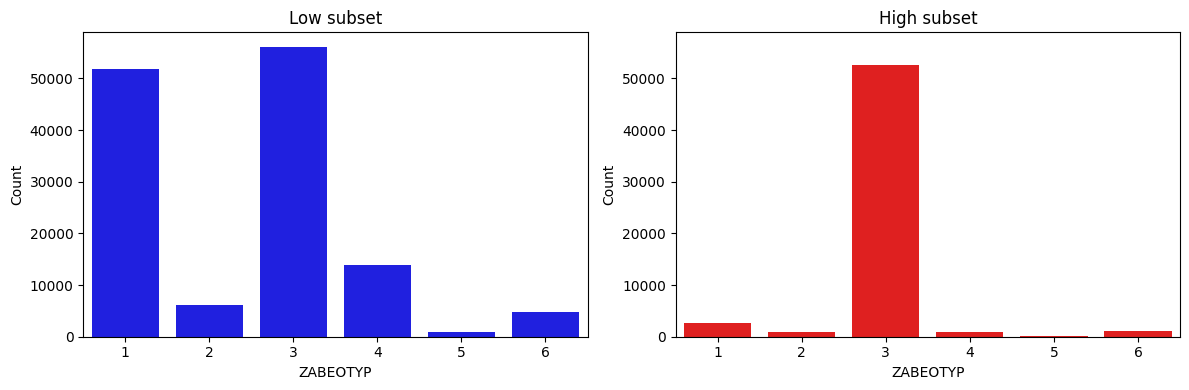

Threshold Source: quantile_fallback
Threshold Value: 0.1
Common Columns: ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP']
<class 'pathlib._local.WindowsPath'>
<class 'pandas.core.frame.DataFrame'>
Index: 133427 entries, 0 to 191651
Data columns (total 81 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   133224 non-null  float64
 1   ANREDE_KZ              133427 non-null  int64  
 2   CJT_GESAMTTYP          133427 non-null  float64
 3   FINANZ_MINIMALIST      133427 non-null  int64  
 4   FINANZ_SPARER          133427 non-null  int64  
 5   FINANZ_VORSORGER       133427 non-n

In [134]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

from WGU_D499_P2_DCook.features import FeatureTransformer


customers_cleaned, azdias_feature_summary_auto =  clean_data(customers, features_summary_auto_df, FT_ops, FeatureTransformer)

In [135]:
customers_cleaned.shape

(133427, 164)

In [136]:
customers_cleaned.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_B', 'CAMEO_DEU_2015_C', 'CAMEO_DEU_2015_D',
       'CAMEO_DEU_2015_E', 'CAMEO_DEU_2015_F', 'LP_STATUS_GROB_AVG_INCOME',
       'LP_STATUS_GROB_HOUSEOWNER', 'LP_STATUS_GROB_INDEPENDANT',
       'LP_STATUS_GROB_LOW_INCOME', 'LP_STATUS_GROB_TOP_EARNER'],
      dtype='object', length=164)

In [137]:
get_info_to_dataframe(customers_cleaned)

,Column,Non-Null Count,Null Count,Dtype
0,ALTERSKATEGORIE_GROB,133224,203,float64
1,ANREDE_KZ,133427,0,int64
2,FINANZ_MINIMALIST,133427,0,int64
3,FINANZ_SPARER,133427,0,int64
4,FINANZ_VORSORGER,133427,0,int64
5,FINANZ_ANLEGER,133427,0,int64
6,FINANZ_UNAUFFAELLIGER,133427,0,int64
7,FINANZ_HAUSBAUER,133427,0,int64
8,GREEN_AVANTGARDE,133427,0,int64
9,HEALTH_TYP,131533,1894,float64


In [138]:
get_info_to_dataframe(azdias_general_demographics_cleaned_prescaled_main_df)

,Column,Non-Null Count,Null Count,Dtype
0,ALTERSKATEGORIE_GROB,792713,2756,float64
1,ANREDE_KZ,795469,0,int64
2,FINANZ_MINIMALIST,795469,0,int64
3,FINANZ_SPARER,795469,0,int64
4,FINANZ_VORSORGER,795469,0,int64
5,FINANZ_ANLEGER,795469,0,int64
6,FINANZ_UNAUFFAELLIGER,795469,0,int64
7,FINANZ_HAUSBAUER,795469,0,int64
8,GREEN_AVANTGARDE,795469,0,int64
9,HEALTH_TYP,759299,36170,float64


In [139]:
from WGU_D499_P2_DCook.utils import compare_dataframe_info

comparison_df = compare_dataframe_info(azdias_general_demographics_cleaned_prescaled_main_df, customers_cleaned)

In [140]:
comparison_df

,Column (df1),Non-Null Count (df1),Null Count (df1),Dtype (df1),Non-Null Count (df2),Null Count (df2),Dtype (df2),Column Match,Non-Null Match,Null Match,Dtype Match
0,ALTERSKATEGORIE_GROB,792713,2756,float64,133224.0,203.0,float64,True,False,False,True
1,ANREDE_KZ,795469,0,int64,133427.0,0.0,int64,True,False,True,True
2,ANZ_HAUSHALTE_AKTIV,789233,6236,float64,131346.0,2081.0,float64,True,False,False,True
3,ANZ_HH_TITEL,791829,3640,float64,131558.0,1869.0,float64,True,False,False,True
4,ANZ_PERSONEN,795469,0,float64,133427.0,0.0,float64,True,False,True,True
5,ANZ_TITEL,795469,0,float64,133427.0,0.0,float64,True,False,True,True
6,ARBEIT,791279,4190,float64,132914.0,513.0,float64,True,False,False,True
7,BALLRAUM,794892,577,float64,133402.0,25.0,float64,True,False,False,True
8,CAMEO_DEUG_2015_1,795469,0,bool,133427.0,0.0,bool,True,False,True,True
9,CAMEO_DEUG_2015_2,795469,0,bool,133427.0,0.0,bool,True,False,True,True


In [ ]:
from WGU_D499_P2_DCook.utils import find_differences_between_columns

difference_list = find_differences_between_columns(azdias_general_demographics_cleaned_prescaled_main_df, customers_cleaned)

difference_list

# One column difference
# Customers_cleaned doesn't contained GEBAEUDETYP_COMPANY_BUILDING_UNKNOWN_COMPANY


['GEBAEUDETYP_COMPANY_BUILDING_UNKNOWN_COMPANY']

In [ ]:
from WGU_D499_P2_DCook.impute_and_scale import apply_existing_scaling_v3

customers_scaled = apply_existing_scaling_v3(
    prescaled_df=customers_cleaned,
    features_df=azdias_feature_summary_auto,
    num_imputer = number_imputer,
    cat_imputer = category_imputer,
    scaler=scaler
)

In [143]:
pca_customers = pd.DataFrame(pca.transform(customers_scaled))

In [ ]:
customer_labels = kmeans.predict(pca_customers)
#customer_labels


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [186]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

from WGU_D499_P2_DCook.clustering import generate_cluster_comparision_dataframe, generate_cluster_comparision_dataframe_v2

dataframes_list = [azdias_general_demographics_recombined_encoded_scaled, customers_scaled]
labels_list = [population_labels, customer_labels]
dataset_names_list = ["population", "customers"]

combined_cluster_dataframe, cluster_comparision_dataframe = generate_cluster_comparision_dataframe_v2(dataframes_list, labels_list, dataset_names_list, baseline_dataset='population')

2025-06-18 02:13:52.384 | WARNING  | WGU_D499_P2_DCook.clustering:generate_cluster_comparision_dataframe_v2:301 - More than two datasets found. Proceeding with cluster comparison.


In [193]:
cluster_comparision_dataframe

,cluster,dataset,count,proportion,difference_to_baseline,ratio_to_baseline,compared_to
0,0,population,85703,0.107739,0.000000,1.000000,population
8,0,customers,5709,0.042787,-0.064952,0.397140,population
1,1,population,121507,0.152749,0.000000,1.000000,population
9,1,customers,30791,0.230770,0.078022,1.510783,population
2,2,population,114772,0.144282,0.000000,1.000000,population
10,2,customers,1113,0.008342,-0.135941,0.057815,population
3,3,population,78454,0.098626,0.000000,1.000000,population
11,3,customers,4326,0.032422,-0.066204,0.328739,population
4,4,population,77169,0.097011,0.000000,1.000000,population
12,4,customers,8763,0.065676,-0.031334,0.677001,population


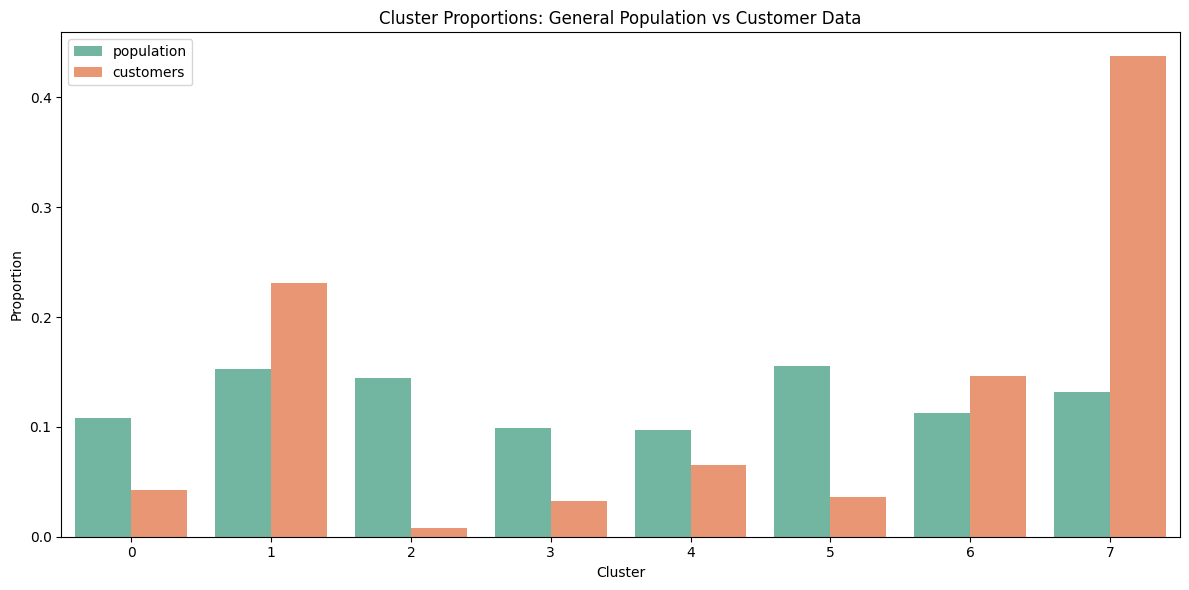

In [217]:
from WGU_D499_P2_DCook.plots import plot_absolute_cluster_proportions

plot_absolute_cluster_proportions(cluster_comparision_dataframe)

In [225]:
# Although my cluster comparision dataframe can handle more than 2 datasets, we will be hardcoding here for the two we have. 
# 

target_dataset = 'customers'
baseline_dataset = 'population'

population_dataframe = cluster_comparision_dataframe[
    (cluster_comparision_dataframe['dataset'] == baseline_dataset) &
    (cluster_comparision_dataframe['compared_to'] == baseline_dataset)
]

customer_dataframe = cluster_comparision_dataframe[
    (cluster_comparision_dataframe['dataset'] == target_dataset) &
    (cluster_comparision_dataframe['compared_to'] == baseline_dataset)
]


cluster_info_dataframe = pd.merge(
    population_dataframe[['cluster', 'proportion']].rename(columns={'proportion': 'Population'}),
    customer_dataframe[['cluster', 'proportion']].rename(columns={'proportion': 'Customers'}),
    on='cluster',
    how='outer'   # ensures all clusters are included!
)

# Optional: sort
cluster_info_dataframe = cluster_info_dataframe.sort_values('cluster').reset_index(drop=True)

# Rename column
cluster_info_dataframe = cluster_info_dataframe.rename(columns={'cluster': 'Cluster'})


In [226]:
print(cluster_info_dataframe.head())

   Cluster  Population  Customers
0        0    0.107739   0.042787
1        1    0.152749   0.230770
2        2    0.144282   0.008342
3        3    0.098626   0.032422
4        4    0.097011   0.065676


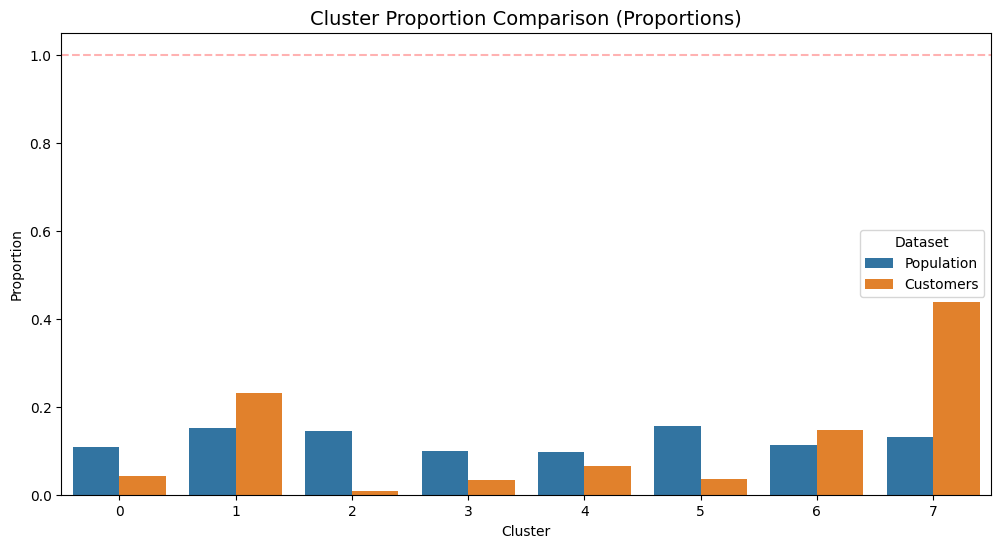

In [227]:
from WGU_D499_P2_DCook.plots import plot_cluster_distribution, plot_combined_cluster_distribution

#plot_cluster_distribution(cluster_info_dataframe)
plot_combined_cluster_distribution(cluster_info_dataframe, title_suffix="(Proportions)")

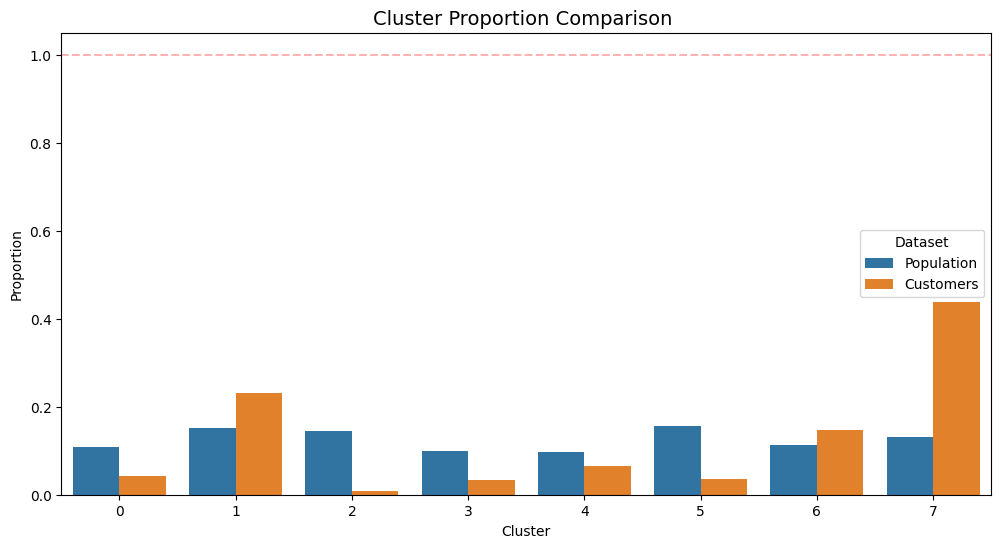

In [228]:
from WGU_D499_P2_DCook.plots import plot_combined_cluster_distribution

plot_combined_cluster_distribution(cluster_info_dataframe)


In [229]:
target_dataset = 'customers'

subset = cluster_comparision_dataframe[
    cluster_comparision_dataframe['dataset'] == target_dataset
]


#row_over_idx  = cluster_comparision_dataframe['ratio_to_baseline'].idxmax()
row_over_idx  = subset['ratio_to_baseline'].idxmax()
#row_under_idx = cluster_comparision_dataframe['ratio_to_baseline'].idxmin()
row_under_idx = subset['ratio_to_baseline'].idxmin()


over_cluster = cluster_comparision_dataframe.loc[row_over_idx, 'cluster']
under_cluster = cluster_comparision_dataframe.loc[row_under_idx, 'cluster']



In [234]:
cluster_centroid_scaled = pca.inverse_transform(kmeans.cluster_centers_)
cluster_centroid_original = scaler.inverse_transform(cluster_centroid_scaled)

original_feature_names = azdias_general_demographics_recombined_encoded.columns.tolist()

centroids_dataframe = pd.DataFrame(cluster_centroid_original, columns=original_feature_names)
centroids_dataframe.index.name = 'cluster'

In [240]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

from WGU_D499_P2_DCook.clustering import show_top_features_per_centroid

show_top_features_per_centroid(centroids_dataframe, top_x=10, only_clusters=[over_cluster])


Cluster 7 - Top 10 POSITIVE features:


MIN_GEBAEUDEJAHR     1992.896088
KBA13_ANZAHL_PKW      701.658522
WOHNDAUER_2008          8.623772
SEMIO_LUST              5.150350
SEMIO_ERL               5.074247
SEMIO_VERT              4.743508
SEMIO_DOM               4.680756
FINANZ_MINIMALIST       4.537430
SEMIO_KRIT              4.347117
FINANZ_VORSORGER        4.209163
Name: 7, dtype: float64


Cluster 7 - Top 10 NEGATIVE features:


ONLINE_AFFINITAET_0.0                          -5.136094e-03
FINANZTYP_LOW_FINANCIAL_INTEREST_MINIMALIST    -3.252431e-03
KBA05_ANTG4_2.0                                -2.642793e-03
KBA05_GBZ_1.0                                  -2.348900e-03
KBA05_GBZ_2.0                                  -1.987746e-03
ZABEOTYP_SEEKING_ORIENTATION                   -2.277355e-04
PLZ8_GBZ_1.0                                   -1.281637e-04
GEBAEUDETYP_COMPANY_BUILDING_UNKNOWN_COMPANY    8.657610e-07
KBA05_ANTG3_2.0                                 2.726297e-04
PLZ8_ANTG1_0.0                                  2.849120e-04
Name: 7, dtype: float64


------------------------------------------------------------


In [239]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

from WGU_D499_P2_DCook.clustering import show_top_features_per_centroid

show_top_features_per_centroid(centroids_dataframe, top_x=10, only_clusters=[under_cluster])


Cluster 2 - Top 10 POSITIVE features:


MIN_GEBAEUDEJAHR       1992.552923
KBA13_ANZAHL_PKW        606.830751
ANZ_HAUSHALTE_AKTIV      10.545765
WOHNDAUER_2008            7.087689
SEMIO_PFLICHT             5.964834
SEMIO_REL                 5.799947
SEMIO_TRADV               5.459711
HH_EINKOMMEN_SCORE        5.455771
SEMIO_KULT                5.340196
SEMIO_RAT                 5.286670
Name: 2, dtype: float64


Cluster 2 - Top 10 NEGATIVE features:


LP_STATUS_GROB_HOUSEOWNER                              -6.043392e-03
PRAEGENDE_JUGENDJAHRE_GENERATION_4.0                   -5.505865e-03
ONLINE_AFFINITAET_0.0                                  -2.262741e-03
LP_LEBENSPHASE_FEIN_WEALTH_STAGE_TOP                   -2.162386e-03
GEBAEUDETYP_COMPANY_BUILDING_UNKNOWN_COMPANY            8.429007e-08
MOBI_REGIO_6.0                                          8.694154e-05
PRAEGENDE_JUGENDJAHRE_GENERATION_1.0                    1.769506e-04
GEBAEUDETYP_MIXED_BUILDING_UNKNOWN_HOUSEHOLD            4.590813e-04
GEBAEUDETYP_MIXED_BUILDING_UNKNOWN_HOUSEHOLD_COMPANY    6.265259e-04
LP_LEBENSPHASE_FEIN_LIFE_STAGE_RETIREMENT_AGE           7.367125e-04
Name: 2, dtype: float64


------------------------------------------------------------


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Clusters 


Cluster 3 of the customer's dataset is under represented to the populations dataset. It has a difference of .3084870198, or roughly a 3.321% difference. 



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.